### 引入相关三方库并忽略相关警告

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.cof import COF
from pyod.models.pca import PCA

## 对wine_banchmark中的数据集进行处理

In [2]:
# 将所有的csv文件读取出来
# 读取所有csv文件并合并成一个dataframe,把包含noise和不包含noise的分为两个数据集
from os import walk
data_wine=[]
data_wine_noise = []
for root,dirs,files in walk("wine/benchmarks"):
    for i in files:
        temp = pd.read_csv(root+'/'+i)
        if temp.shape[1] ==17:
            data_wine.append(temp)
        else:
            data_wine_noise.append(temp)

### dataframe的合并

In [3]:
data_wine_all = pd.concat(data_wine)
data_wine_noise_all = pd.concat(data_wine_noise)
print(data_wine_all.columns)
print(data_wine_noise_all.columns)

Index(['point.id', 'motherset', 'origin', 'original.label', 'diff.score',
       'ground.truth', 'fixed.acidity', 'volatile.acidity', 'citric.acid',
       'residual.sugar', 'chlorides', 'free.sulfur.dioxide',
       'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
      dtype='object')
Index(['point.id', 'motherset', 'origin', 'original.label', 'diff.score',
       'ground.truth', 'fixed.acidity', 'volatile.acidity', 'citric.acid',
       'residual.sugar', 'chlorides', 'free.sulfur.dioxide',
       'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'noise..1', 'noise..2', 'noise..3', 'noise..4', 'noise..5', 'noise..6',
       'noise..7', 'noise..8', 'noise..9', 'noise..10', 'noise..11',
       'noise..12', 'noise..13', 'noise..14', 'noise..15', 'noise..16',
       'noise..17', 'noise..18', 'noise..19', 'noise..20', 'noise..21',
       'noise..22', 'noise..23', 'noise..24', 'noise..25', 'noise..26',
       'noise..27', 'noise..28', 'noise..29', 'no

### 舍弃motherset、origin属性

In [4]:
print(data_wine_all['origin'].value_counts())
print(data_wine_all['motherset'].value_counts())

regression    1049492
Name: origin, dtype: int64
wine    1049492
Name: motherset, dtype: int64


In [5]:
# 建立对应的属性列表
column_names = data_wine_all.columns.tolist()
noise_column_names = data_wine_noise_all.columns.tolist()
print(column_names)
print(noise_column_names)

['point.id', 'motherset', 'origin', 'original.label', 'diff.score', 'ground.truth', 'fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar', 'chlorides', 'free.sulfur.dioxide', 'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol']
['point.id', 'motherset', 'origin', 'original.label', 'diff.score', 'ground.truth', 'fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar', 'chlorides', 'free.sulfur.dioxide', 'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'noise..1', 'noise..2', 'noise..3', 'noise..4', 'noise..5', 'noise..6', 'noise..7', 'noise..8', 'noise..9', 'noise..10', 'noise..11', 'noise..12', 'noise..13', 'noise..14', 'noise..15', 'noise..16', 'noise..17', 'noise..18', 'noise..19', 'noise..20', 'noise..21', 'noise..22', 'noise..23', 'noise..24', 'noise..25', 'noise..26', 'noise..27', 'noise..28', 'noise..29', 'noise..30', 'noise..31', 'noise..32', 'noise..33']


In [6]:
wine_DF = data_wine_all[column_names]
print('删除前元组数：'+str(len(wine_DF)))
# 删除所有属性值都相同的元组
wine_DF = wine_DF.drop_duplicates()
print('删除后元组数：'+str(len(wine_DF)))


wine_noise_DF = data_wine_noise_all[noise_column_names]
print('noise数据集删除前元组数：'+str(len(wine_noise_DF)))
# 删除所有属性值都相同的元组
wine_noise_DF = wine_noise_DF.drop_duplicates()
print('noise数据集删除后元组数：'+str(len(wine_noise_DF)))

删除前元组数：1049492
删除后元组数：6497
noise数据集删除前元组数：3134767
noise数据集删除后元组数：3134767


In [7]:
wine_noise_DF = wine_noise_DF.dropna()
wine_DF = wine_DF.dropna()
#序号索引需要重新创建
wine_DF.reset_index(inplace=True,drop=True)
# 对noise数据集进行随机抽样
wine_noise_DF = wine_noise_DF.sample(20000)

### 创建模型字典

#### 我们使用不同的算法对数据集进行训练

In [8]:
# 离群点分析
random_state = np.random.RandomState(52)
outliers_fraction = 0.1

classifiers = {
        'Fast Angle-based Outlier Detector (F_ABOD)': ABOD(contamination=outliers_fraction,method='fast'),
        #'Original Angle-based Outlier Detector (O_ABOD)': ABOD(contamination=outliers_fraction,method='default'),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(n_neighbors=250, method='largest',contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction),
        'Local Outlier Factor (LOF)':LOF(contamination=outliers_fraction,n_neighbors=200),
        'Connectivity-Based Outlier Factor (COF)':LOF(contamination=outliers_fraction,n_neighbors=200),
        'Principal Component Analysis Outlier Detector (PCA)':PCA(contamination=outliers_fraction,weighted=True,n_components='mle',svd_solver ='full')
}

### 处理不包含noise的数据集

In [9]:
# 创建数据集
train_DF = wine_DF
train_DF['ground.truth']=train_DF['ground.truth'].map({'nominal': 0,'anomaly':1})

### 对数据集进行训练，并在测试数据集上进行预测

In [10]:
from pyod.utils.data import evaluate_print 
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn import model_selection

In [11]:
X = train_DF[[ 'fixed.acidity', 'volatile.acidity', 'citric.acid',
       'residual.sugar', 'chlorides', 'free.sulfur.dioxide',
       'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol']].values
Y = train_DF['ground.truth'].values

In [12]:
%matplotlib inline

#解决中文乱码问题!
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

使用算法Fast Angle-based Outlier Detector (F_ABOD) 进行建模：

在训练数据集中:
Fast Angle-based Outlier Detector (F_ABOD) ROC:0.519, precision @ rank n:0.3829

在测试数据集中:
Fast Angle-based Outlier Detector (F_ABOD) ROC:0.5009, precision @ rank n:0.3832


<Figure size 432x288 with 0 Axes>

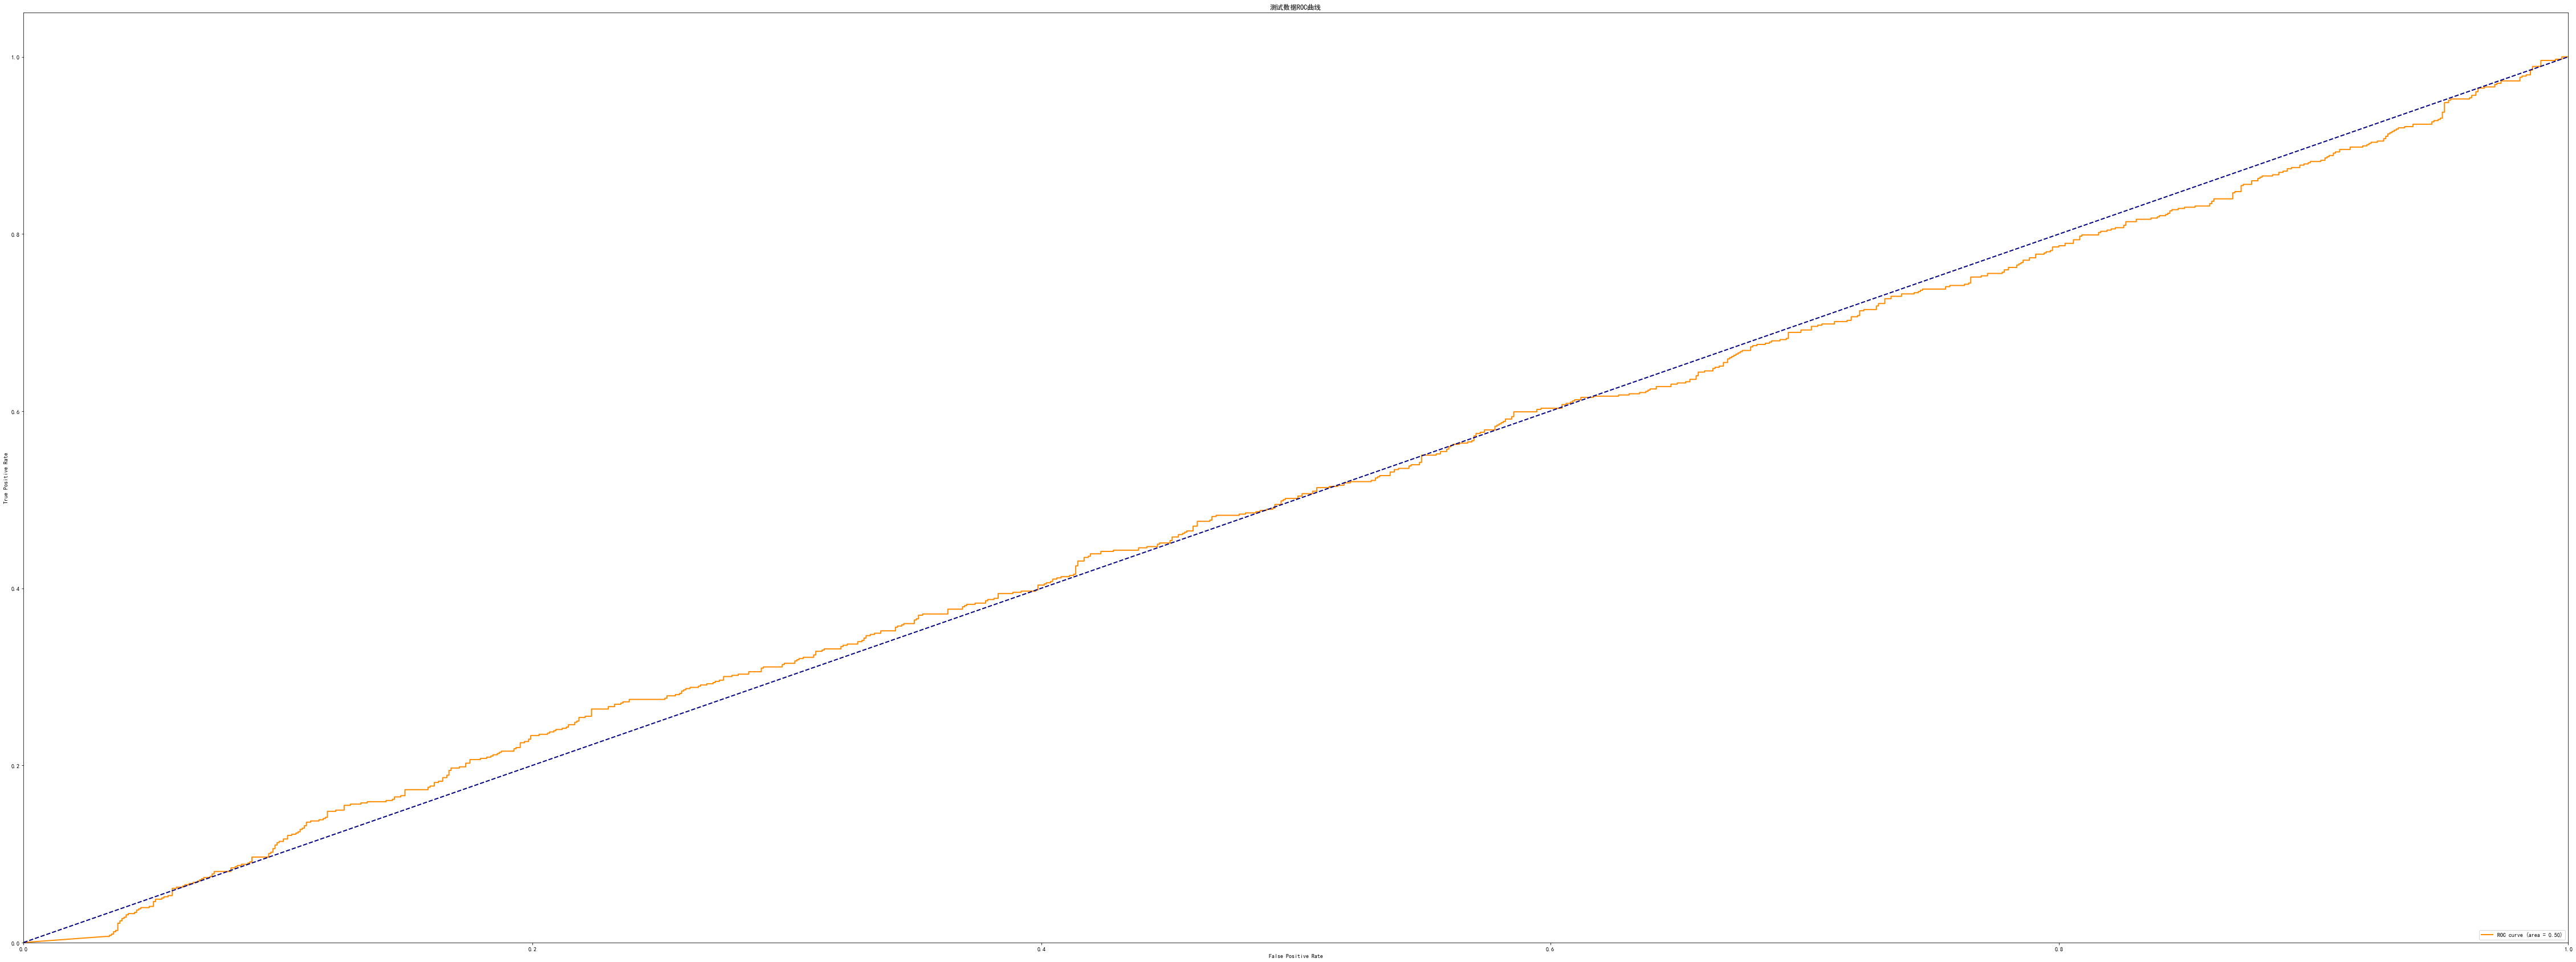

OUTLIERS :  0 INLIERS :  1950 Fast Angle-based Outlier Detector (F_ABOD)
使用算法Cluster-based Local Outlier Factor (CBLOF) 进行建模：

在训练数据集中:
Cluster-based Local Outlier Factor (CBLOF) ROC:0.5633, precision @ rank n:0.4308

在测试数据集中:
Cluster-based Local Outlier Factor (CBLOF) ROC:0.5717, precision @ rank n:0.4429


<Figure size 432x288 with 0 Axes>

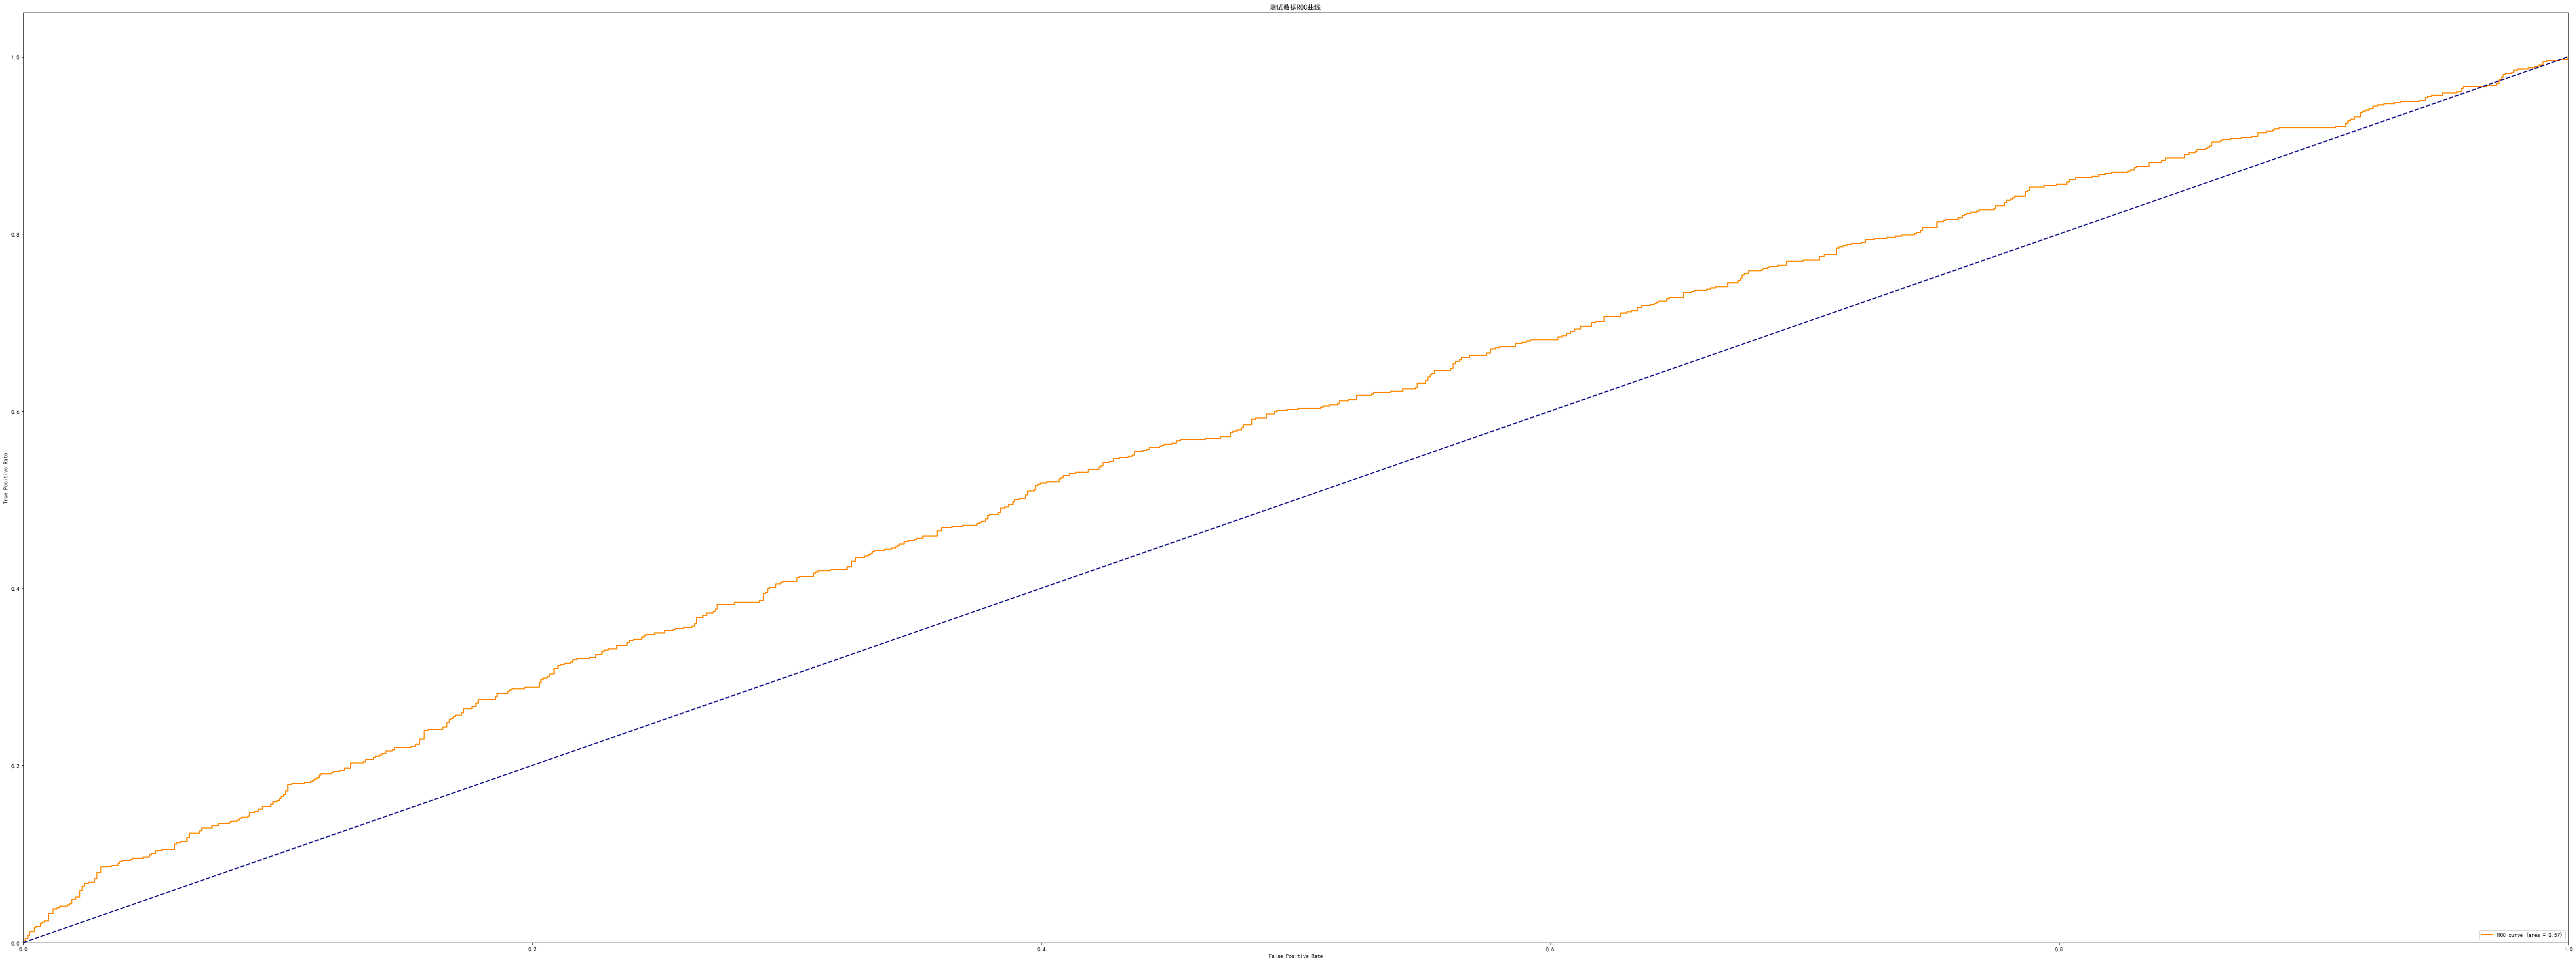

OUTLIERS :  196 INLIERS :  1754 Cluster-based Local Outlier Factor (CBLOF)
使用算法Feature Bagging 进行建模：

在训练数据集中:
Feature Bagging ROC:0.559, precision @ rank n:0.4144

在测试数据集中:
Feature Bagging ROC:0.5568, precision @ rank n:0.4185


<Figure size 432x288 with 0 Axes>

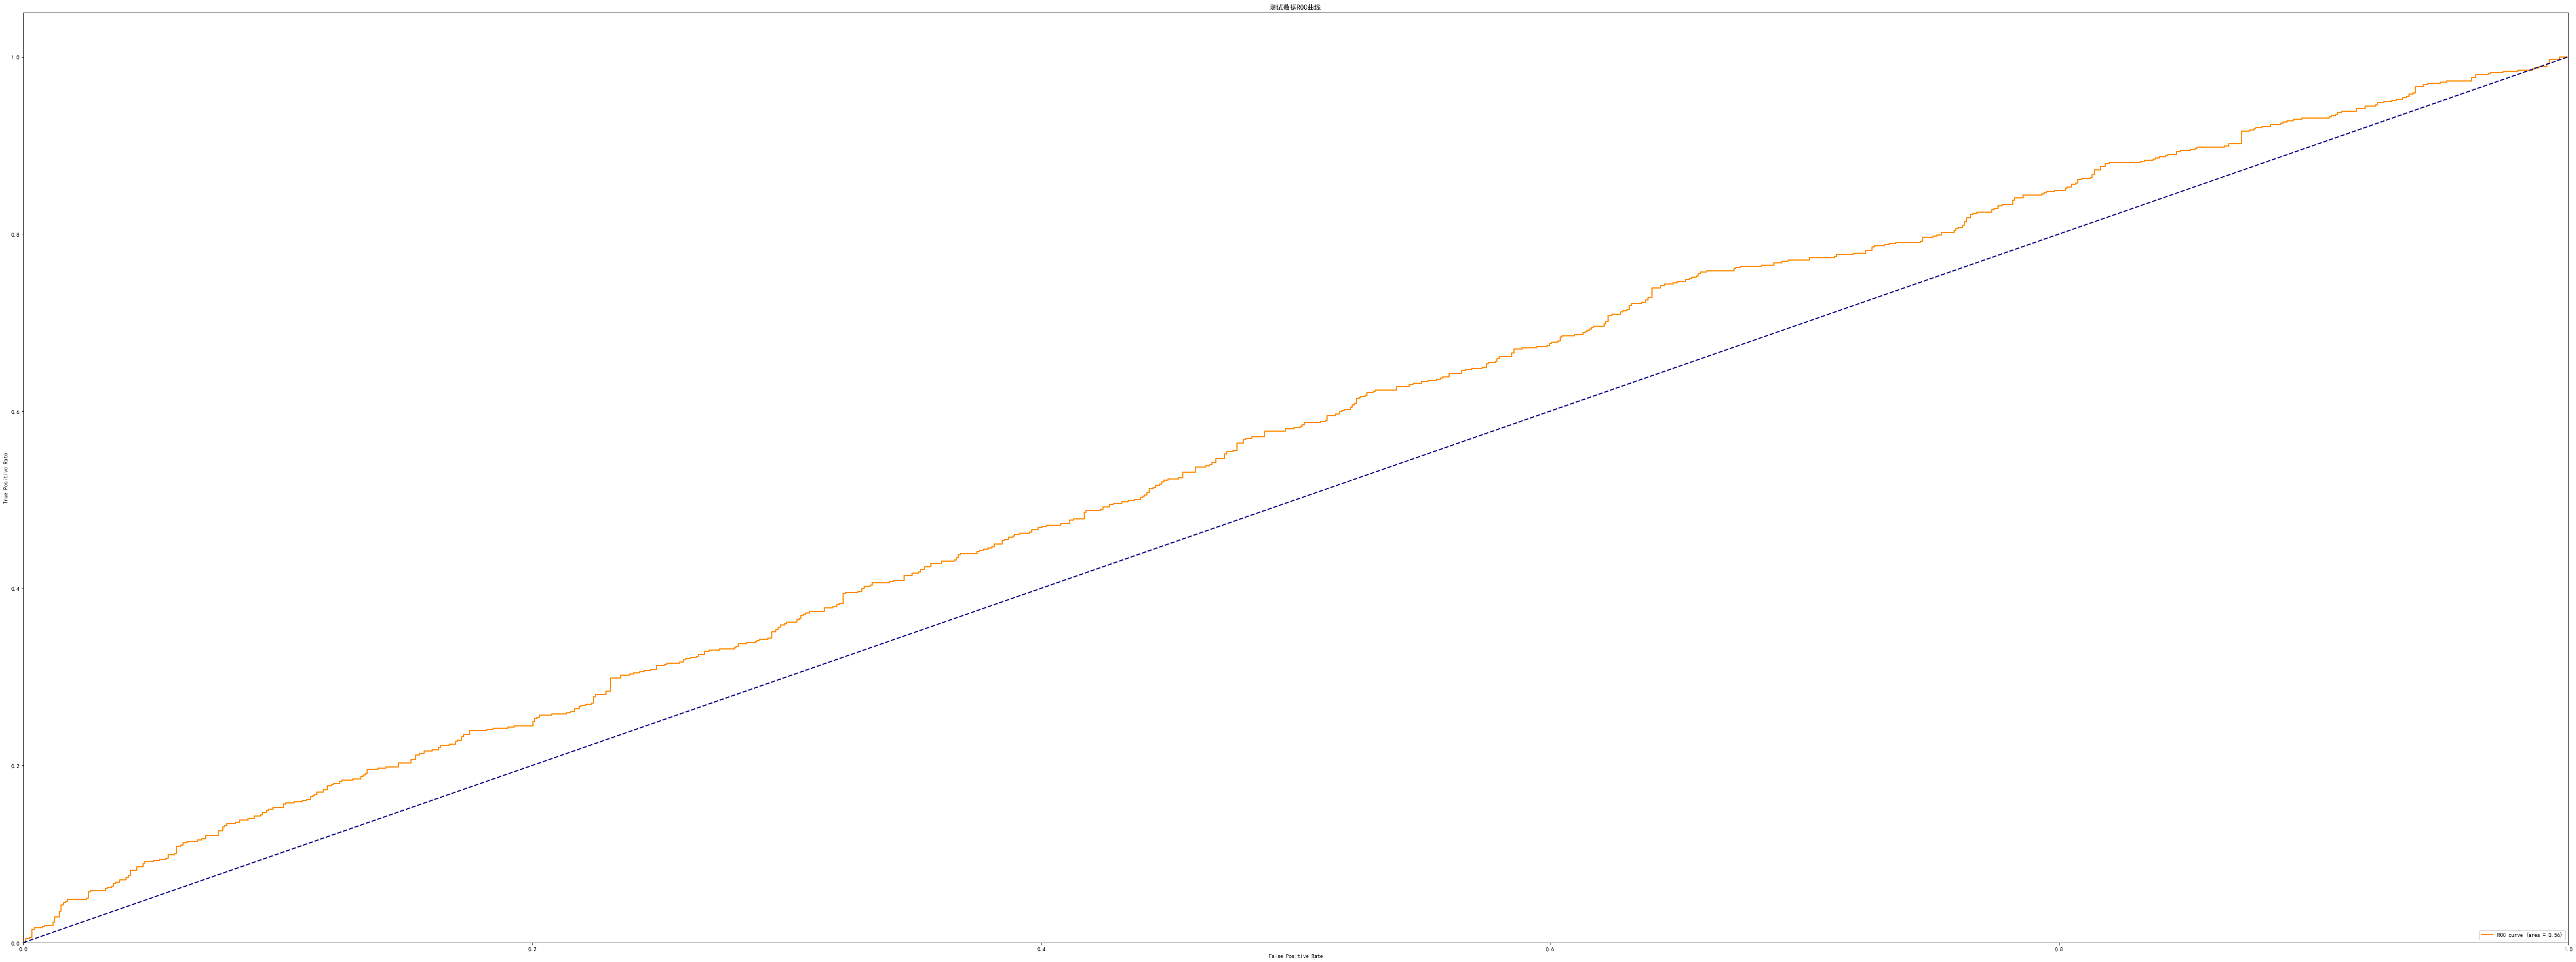

OUTLIERS :  217 INLIERS :  1733 Feature Bagging
使用算法Histogram-base Outlier Detection (HBOS) 进行建模：

在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5535, precision @ rank n:0.4203

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5636, precision @ rank n:0.4416


<Figure size 432x288 with 0 Axes>

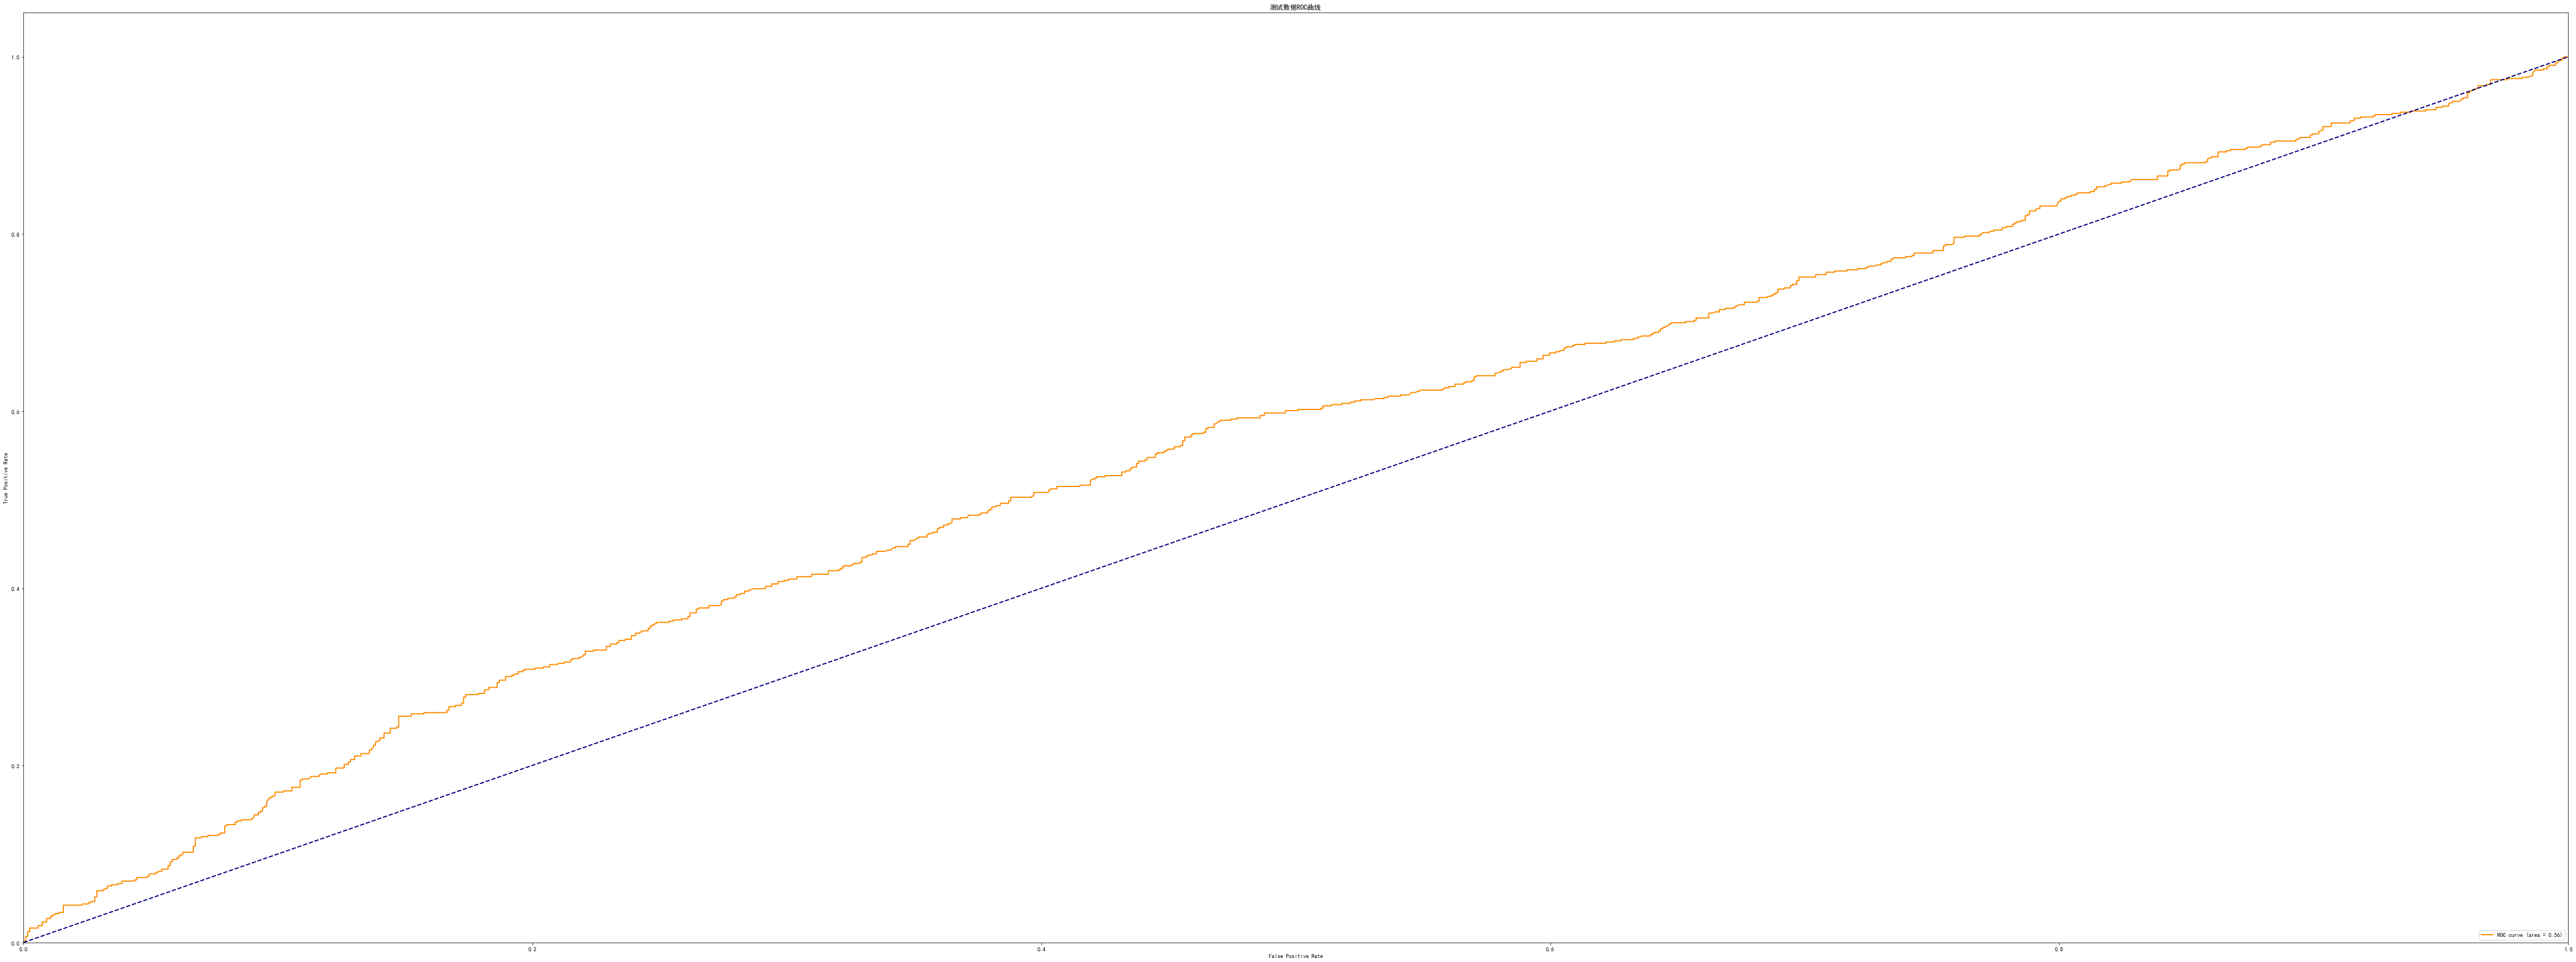

OUTLIERS :  178 INLIERS :  1772 Histogram-base Outlier Detection (HBOS)
使用算法Isolation Forest 进行建模：

在训练数据集中:
Isolation Forest ROC:0.5088, precision @ rank n:0.3807

在测试数据集中:
Isolation Forest ROC:0.5271, precision @ rank n:0.3954


<Figure size 432x288 with 0 Axes>

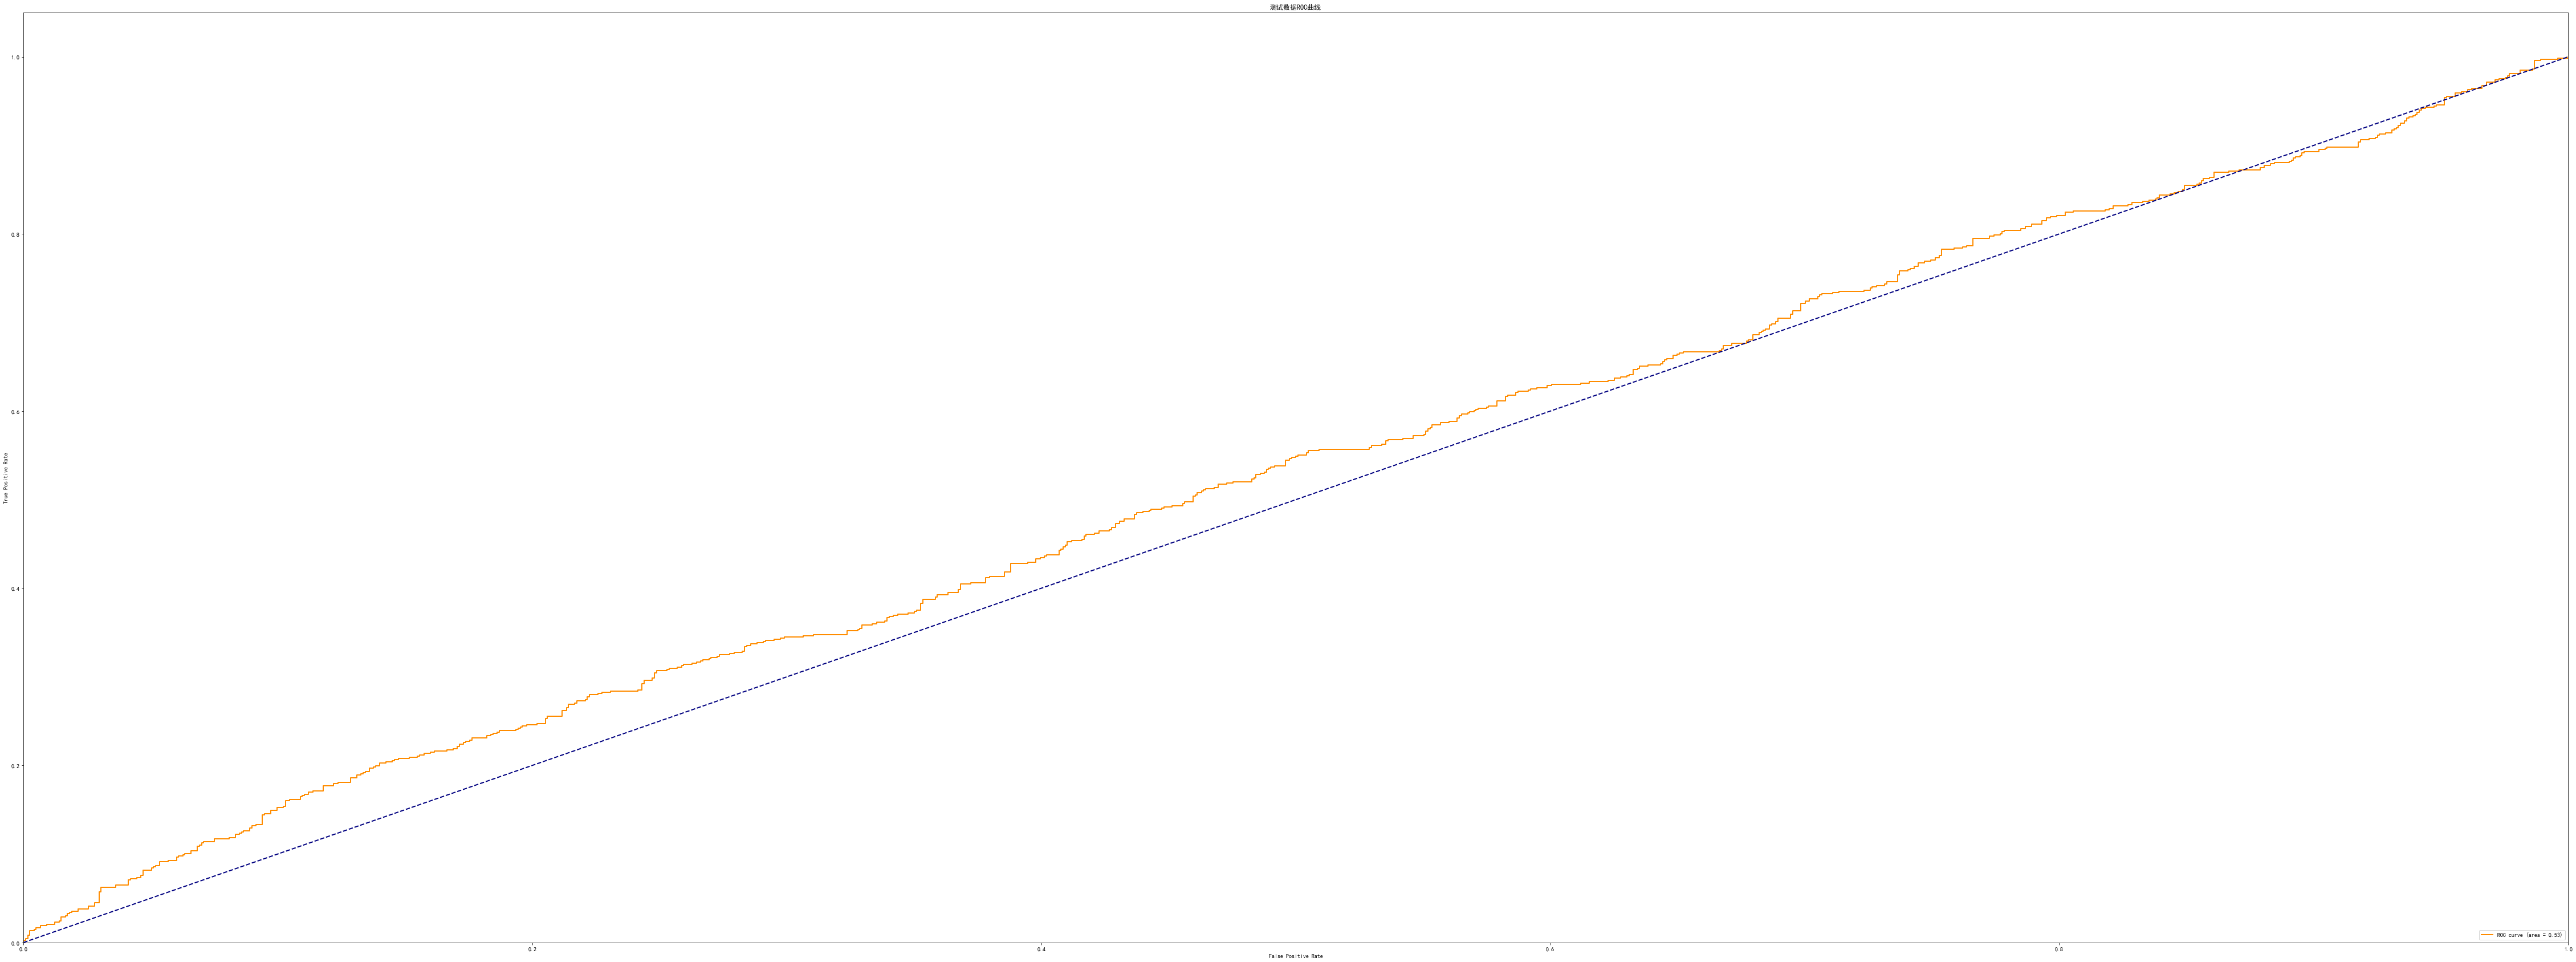

OUTLIERS :  194 INLIERS :  1756 Isolation Forest
使用算法K Nearest Neighbors (KNN) 进行建模：

在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5842, precision @ rank n:0.4308

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6002, precision @ rank n:0.466


<Figure size 432x288 with 0 Axes>

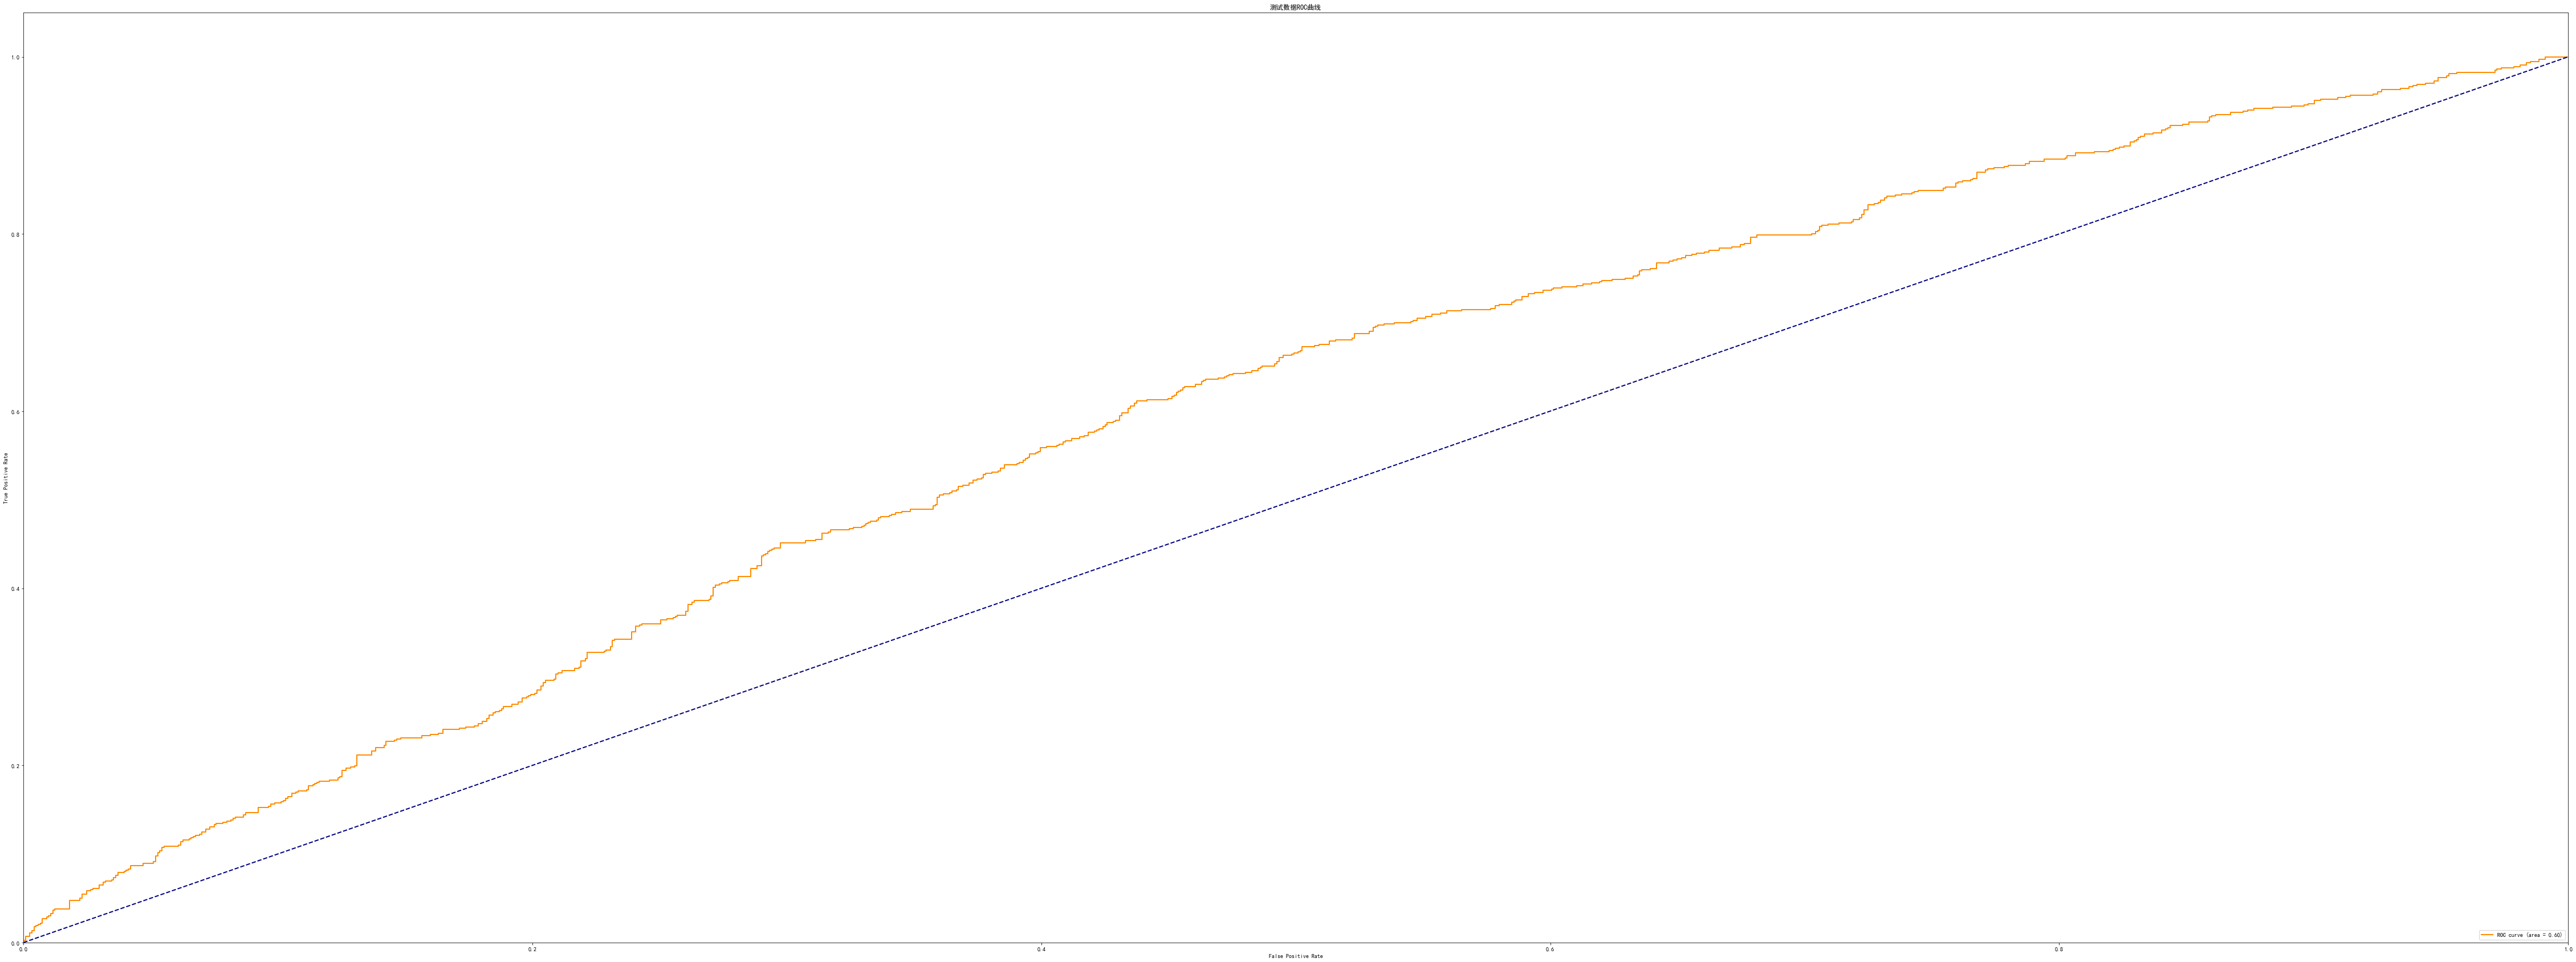

OUTLIERS :  189 INLIERS :  1761 K Nearest Neighbors (KNN)
使用算法Average KNN 进行建模：

在训练数据集中:
Average KNN ROC:0.537, precision @ rank n:0.3999

在测试数据集中:
Average KNN ROC:0.5505, precision @ rank n:0.4266


<Figure size 432x288 with 0 Axes>

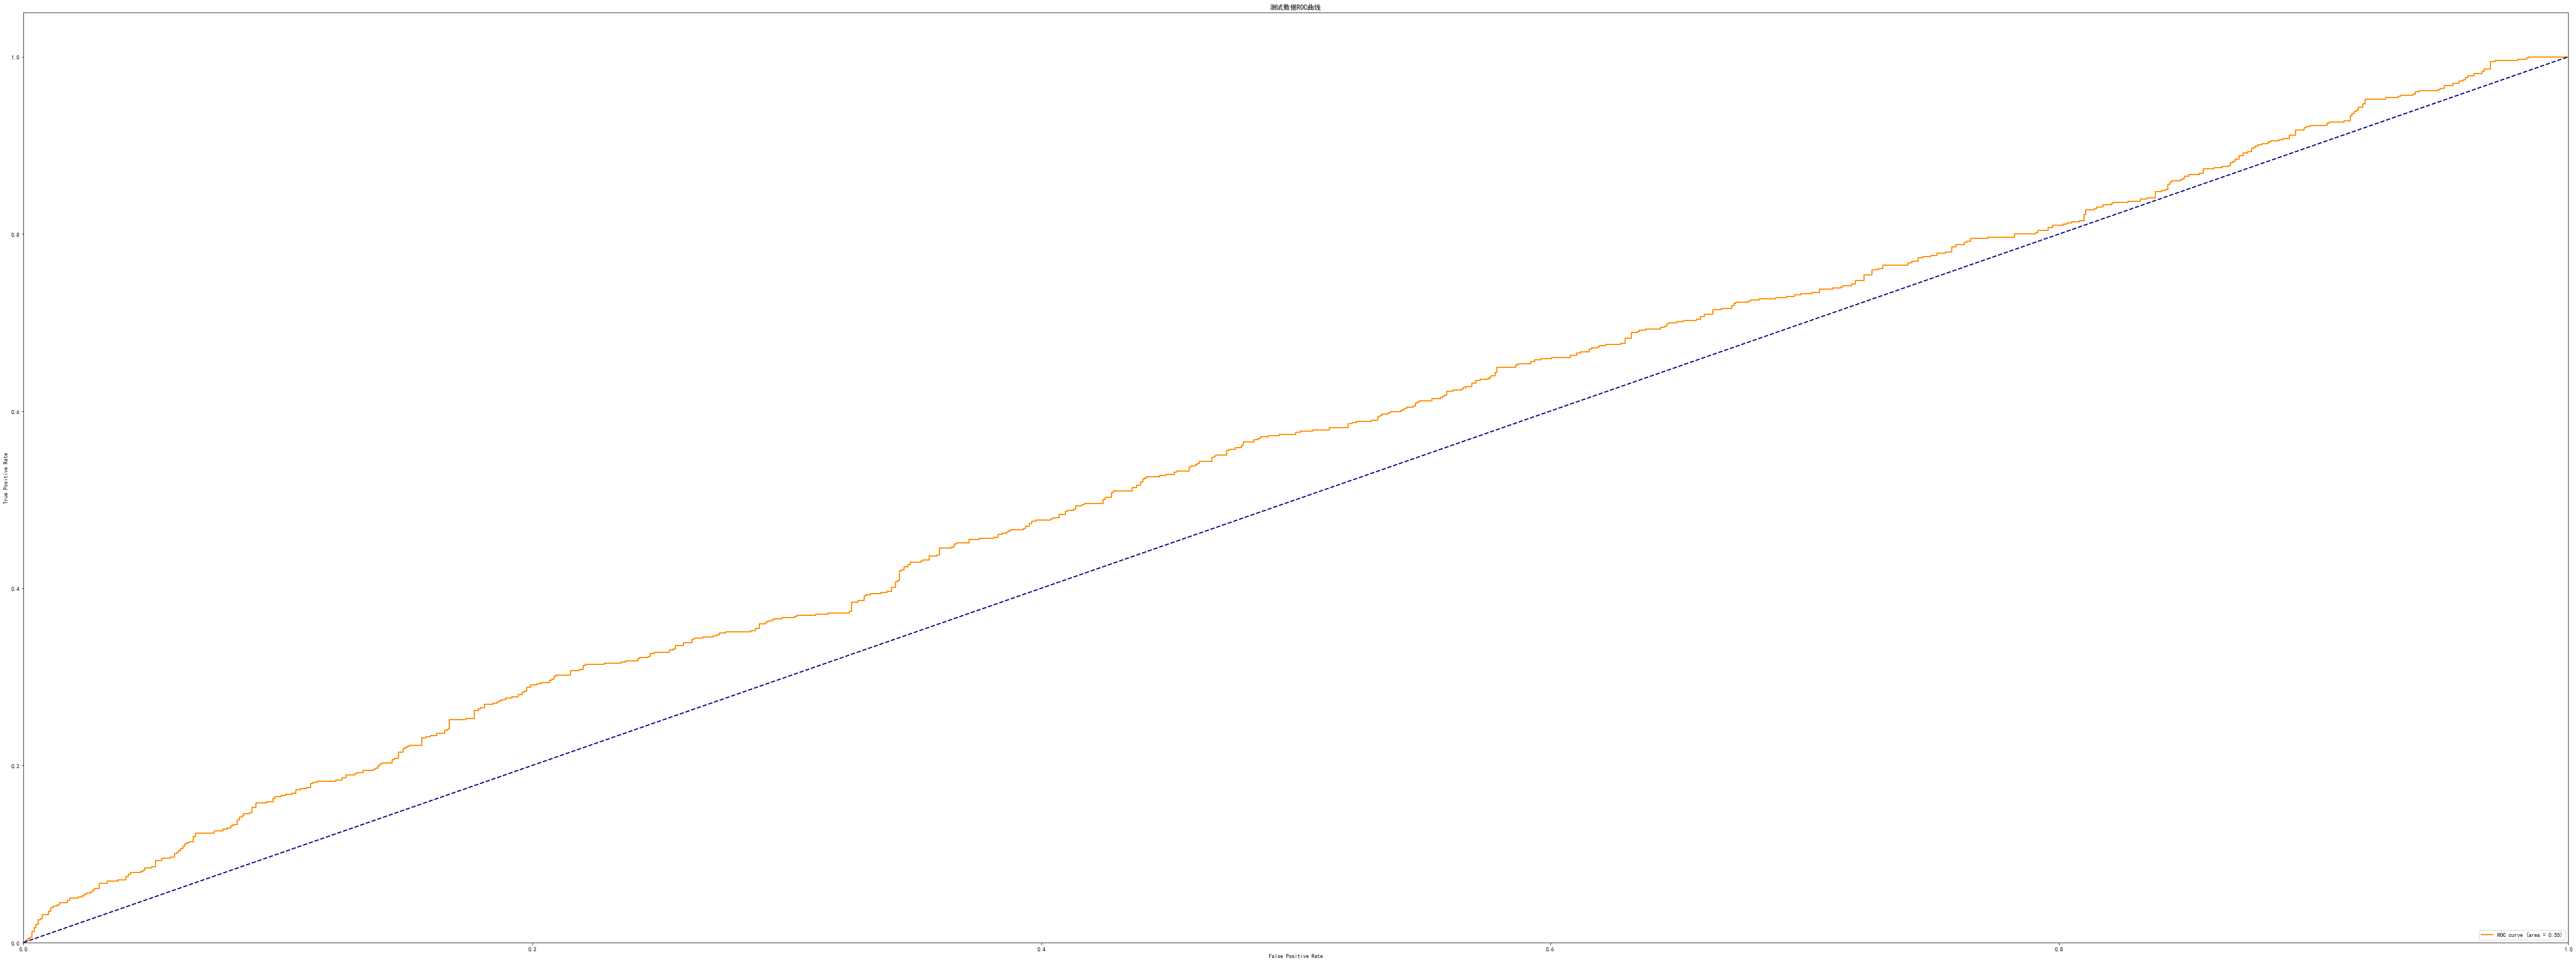

OUTLIERS :  187 INLIERS :  1763 Average KNN
使用算法Local Outlier Factor (LOF) 进行建模：

在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5396, precision @ rank n:0.4078

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5402, precision @ rank n:0.4144


<Figure size 432x288 with 0 Axes>

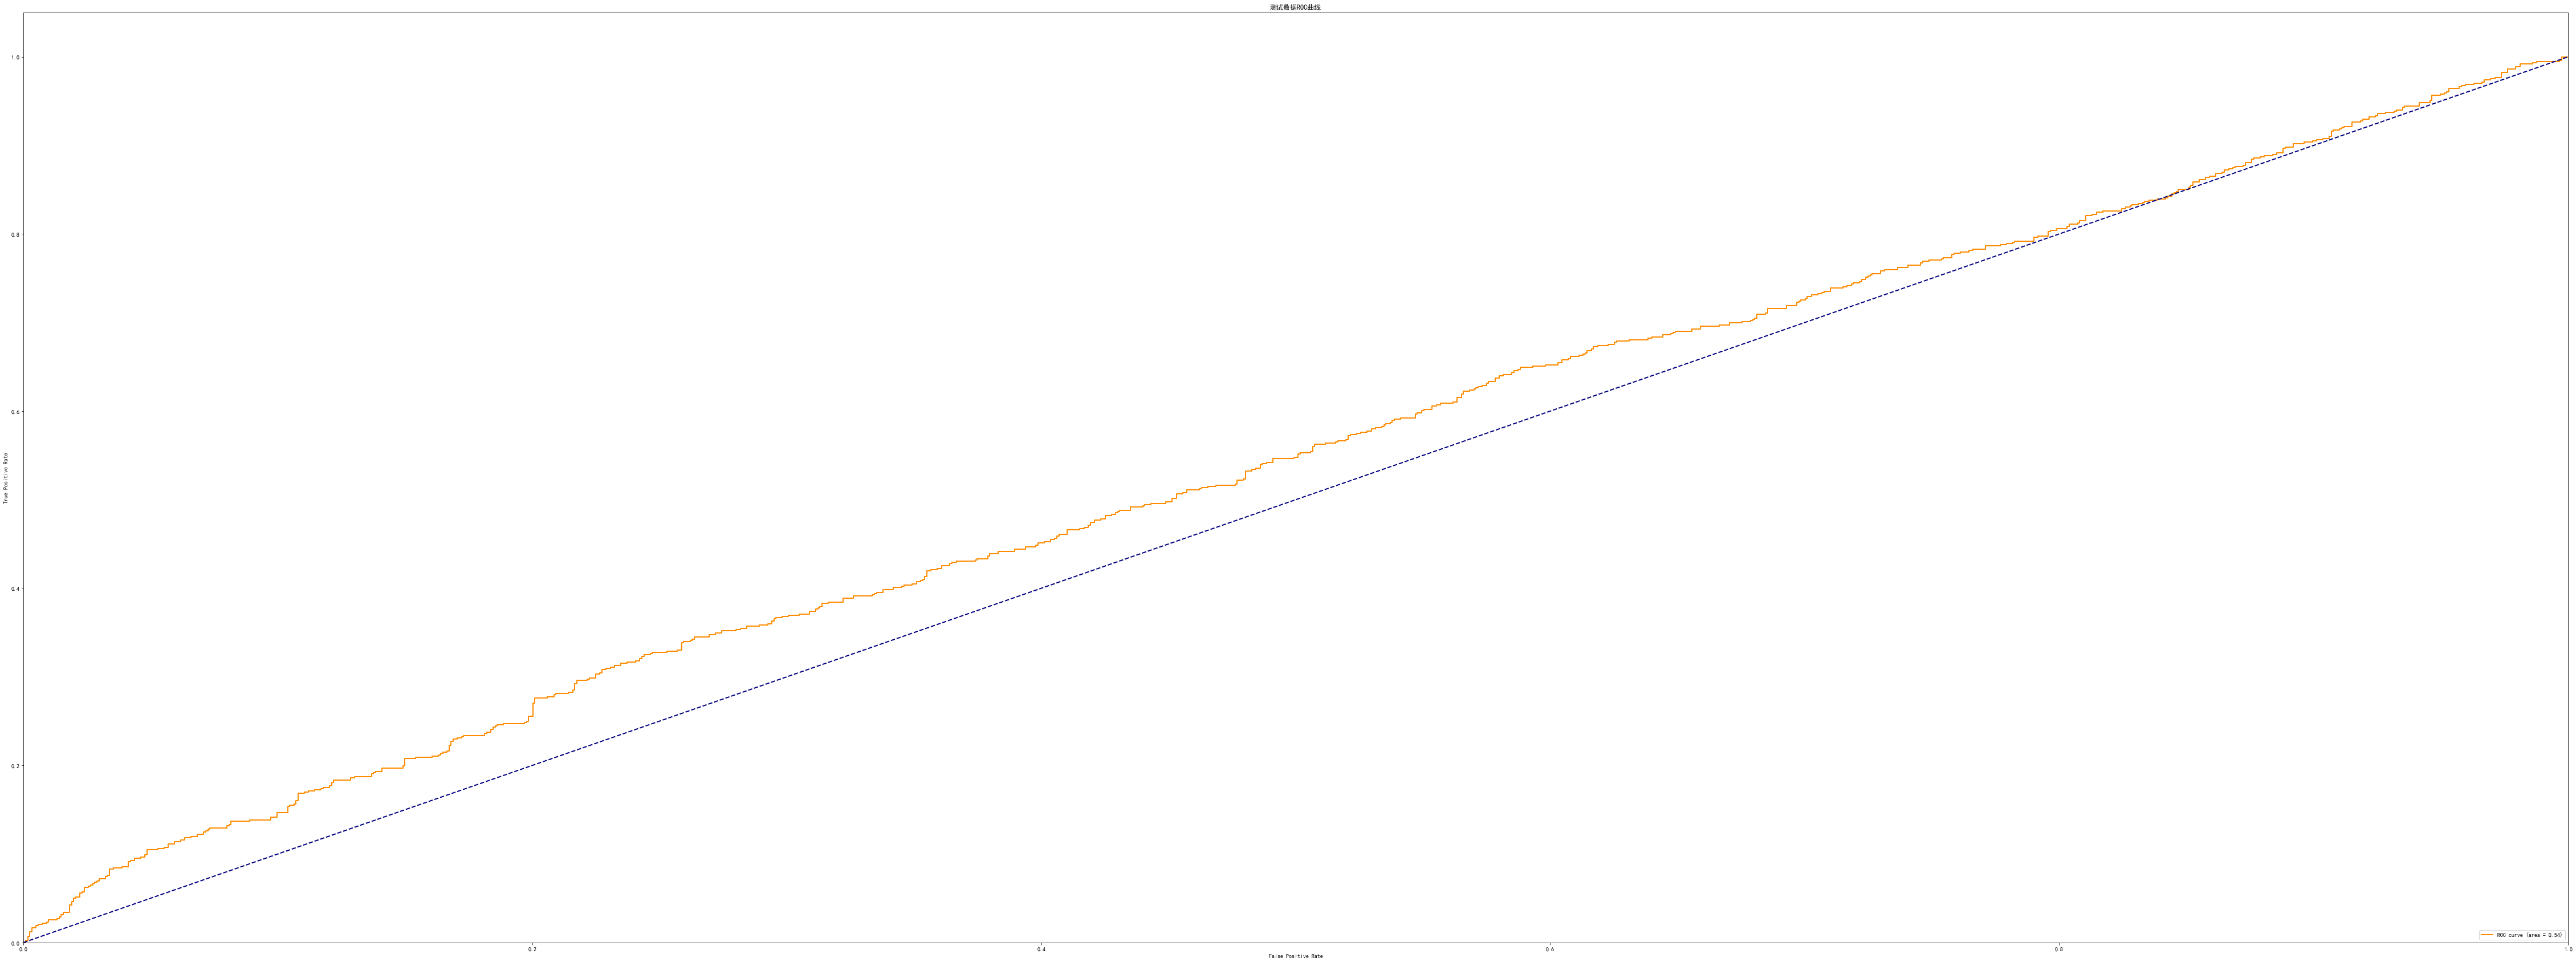

OUTLIERS :  209 INLIERS :  1741 Local Outlier Factor (LOF)
使用算法Connectivity-Based Outlier Factor (COF) 进行建模：

在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5396, precision @ rank n:0.4078

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5402, precision @ rank n:0.4144


<Figure size 432x288 with 0 Axes>

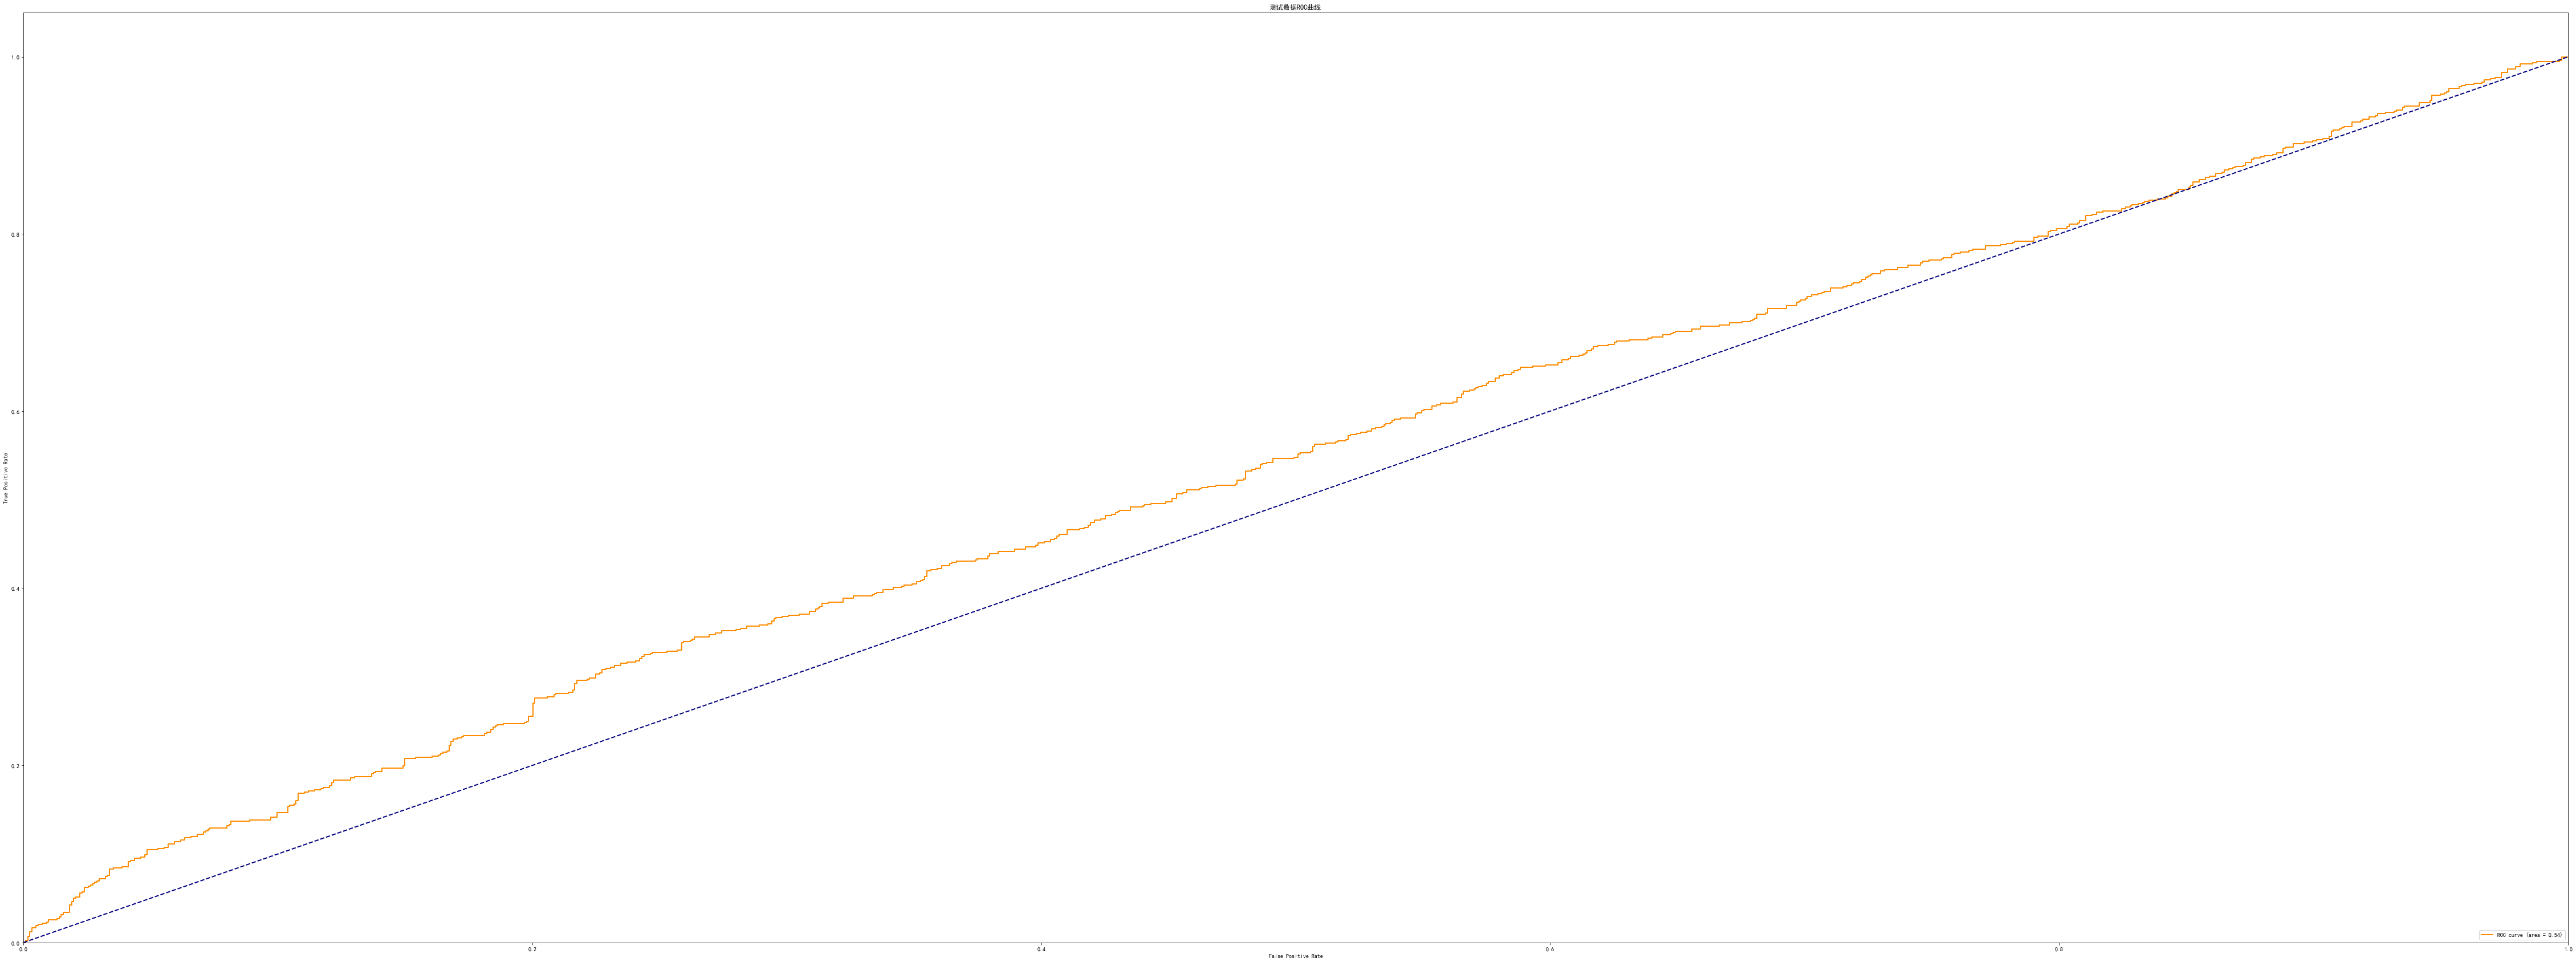

OUTLIERS :  209 INLIERS :  1741 Connectivity-Based Outlier Factor (COF)
使用算法Principal Component Analysis Outlier Detector (PCA) 进行建模：

在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5466, precision @ rank n:0.4114

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5714, precision @ rank n:0.447


<Figure size 432x288 with 0 Axes>

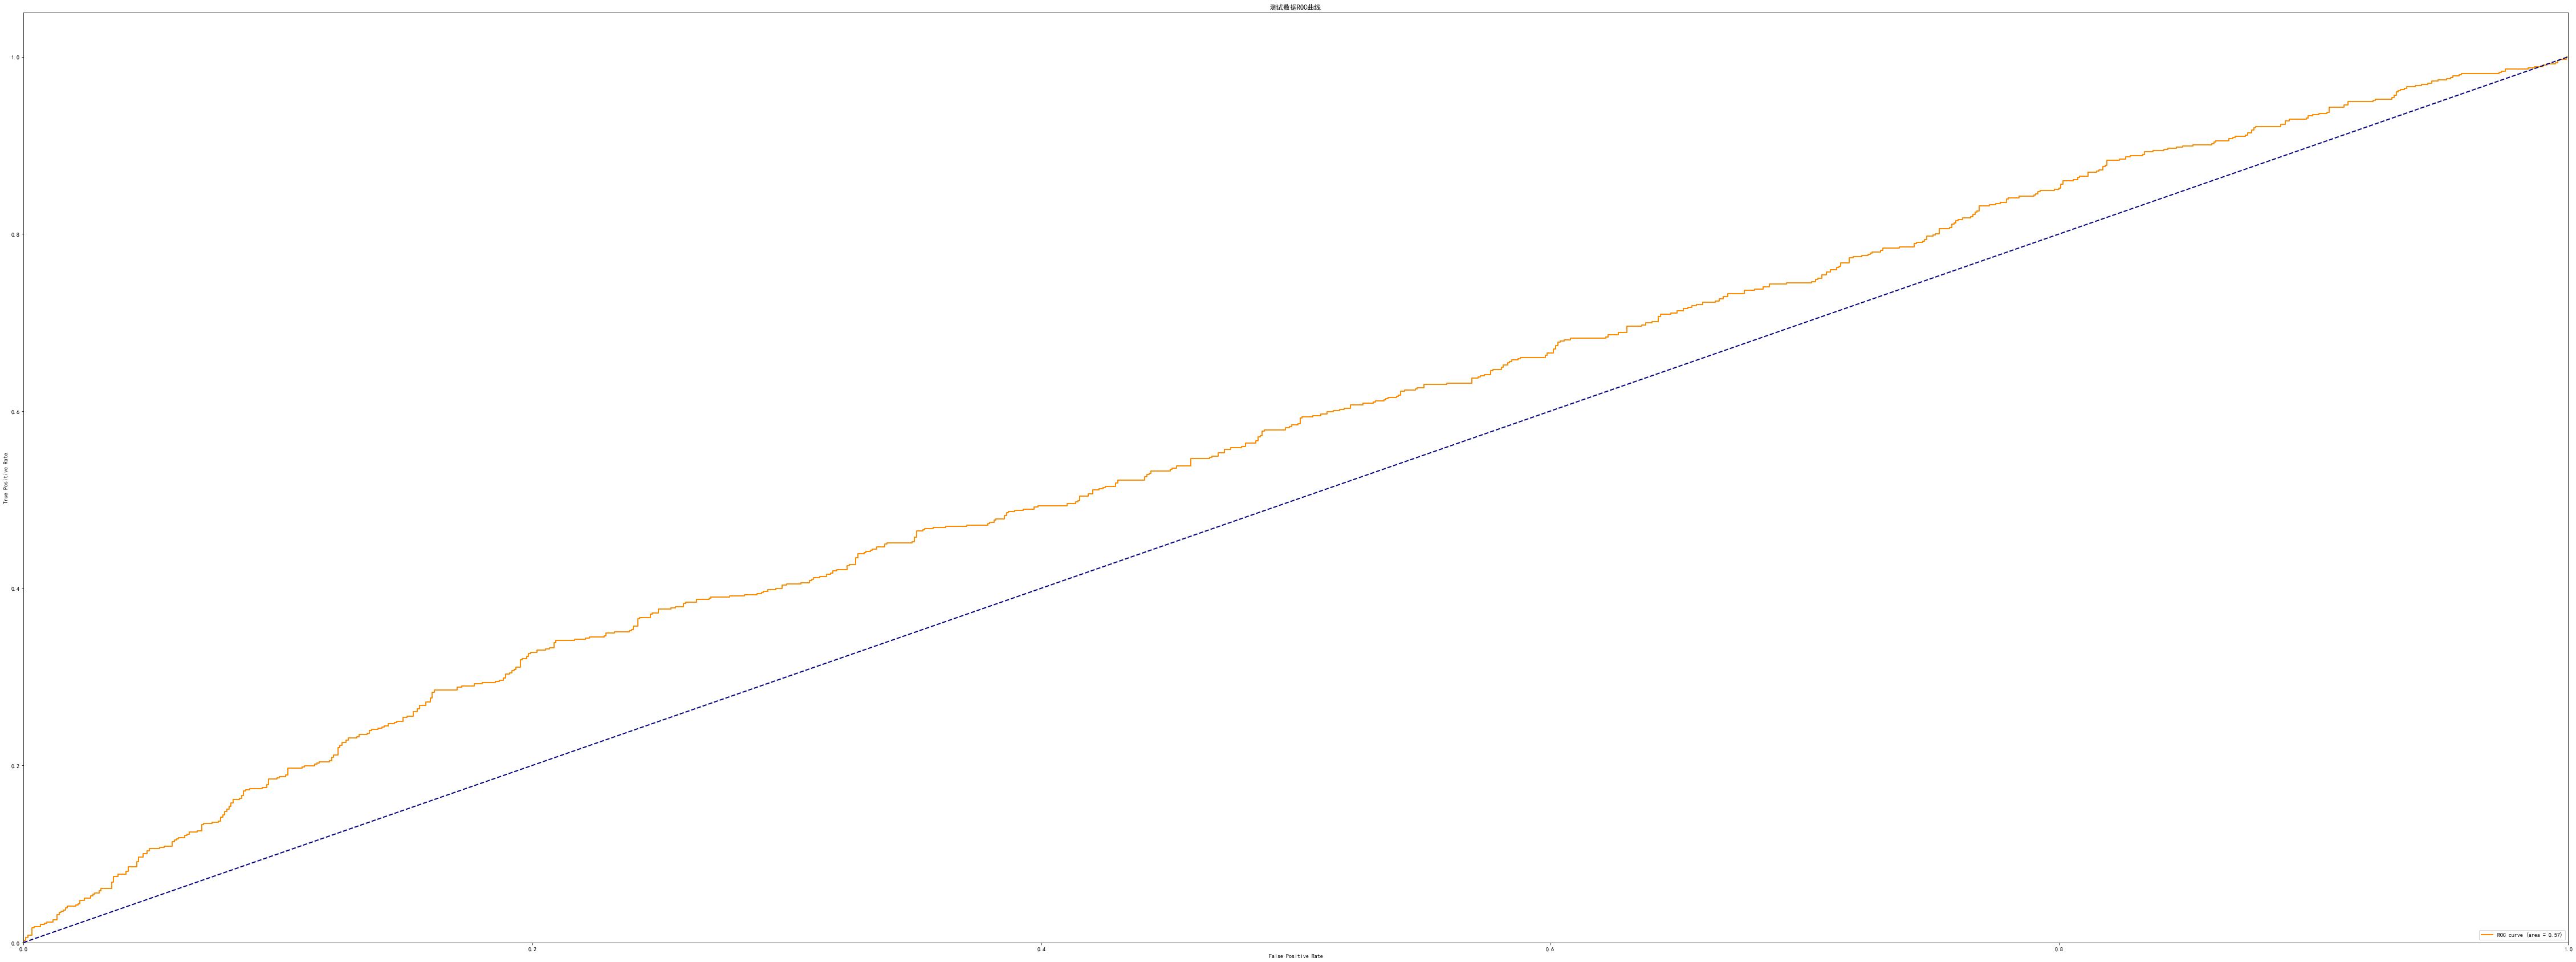

OUTLIERS :  182 INLIERS :  1768 Principal Component Analysis Outlier Detector (PCA)


In [13]:
# 对数据集进行划分,划分为测试数据集和训练集
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.3,random_state=0)
for i, (clf_name, clf) in enumerate(classifiers.items()): 
    print("使用算法"+clf_name+" 进行建模：")
    clf.fit(x_train)
    # 返回训练数据x_train上的异常标签和异常分值
    y_train_pred = clf.labels_  
    y_train_scores = clf.decision_scores_ 
    # 用训练好的clf来预测未知数据中的异常值
    # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
    y_test_pred = clf.predict(x_test) 
    #  返回未知数据上的异常值 (分值越大越异常)
    y_test_scores = clf.decision_function(x_test) 
    y_train_scores = y_train_scores.reshape(-1,1)
    y_test_scores = y_test_scores.reshape(-1,1)
    y_train_scores = y_train_scores.reshape(-1, 1)
    y_test_scores = y_test_scores.reshape(-1, 1)
    # if scores contain nan, change it to 0
    if np.isnan(y_train_scores).any():
         y_train_scores = np.nan_to_num(y_train_scores)
    if np.isnan(y_test_scores).any():
         y_test_scores = np.nan_to_num(y_test_scores)
    print("\n在训练数据集中:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\n在测试数据集中:")
    evaluate_print(clf_name, y_test, y_test_scores)
    # 绘制ROC图
    fpr,tpr,threshold = roc_curve(y_test, y_test_scores) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
    plt.figure()
    lw = 2
    plt.figure(figsize=(80,30))
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('测试数据ROC曲线')
    plt.legend(loc="lower right")
    plt.show()
    # 计算离群点的个数
    n_inliers = len(y_test_pred) - np.count_nonzero(y_test_pred)
    n_outliers = np.count_nonzero(y_test_pred == 1)

    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)

### 对包含noise的数据集进行处理

In [14]:
# 构造数据集
train_noise_DF = wine_noise_DF
train_noise_DF['ground.truth']=train_noise_DF['ground.truth'].map({'nominal': 0,'anomaly':1})

### 对数据集进行训练，并在测试数据集上进行预测

In [15]:
from pyod.utils.data import evaluate_print 
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
from sklearn import model_selection

X = train_noise_DF[[ 'fixed.acidity', 'volatile.acidity', 'citric.acid',
       'residual.sugar', 'chlorides', 'free.sulfur.dioxide',
       'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'noise..1', 'noise..2', 'noise..3', 'noise..4', 'noise..5', 'noise..6',
       'noise..7', 'noise..8', 'noise..9', 'noise..10', 'noise..11',
       'noise..12', 'noise..13', 'noise..14', 'noise..15', 'noise..16',
       'noise..17', 'noise..18', 'noise..19', 'noise..20', 'noise..21',
       'noise..22', 'noise..23', 'noise..24', 'noise..25', 'noise..26',
       'noise..27', 'noise..28', 'noise..29', 'noise..30', 'noise..31',
       'noise..32', 'noise..33']].values
Y = train_noise_DF['ground.truth'].values


使用算法Fast Angle-based Outlier Detector (F_ABOD) 进行建模：

在训练数据集中:
Fast Angle-based Outlier Detector (F_ABOD) ROC:0.5308, precision @ rank n:0.1232

在测试数据集中:
Fast Angle-based Outlier Detector (F_ABOD) ROC:0.5236, precision @ rank n:0.1288


<Figure size 432x288 with 0 Axes>

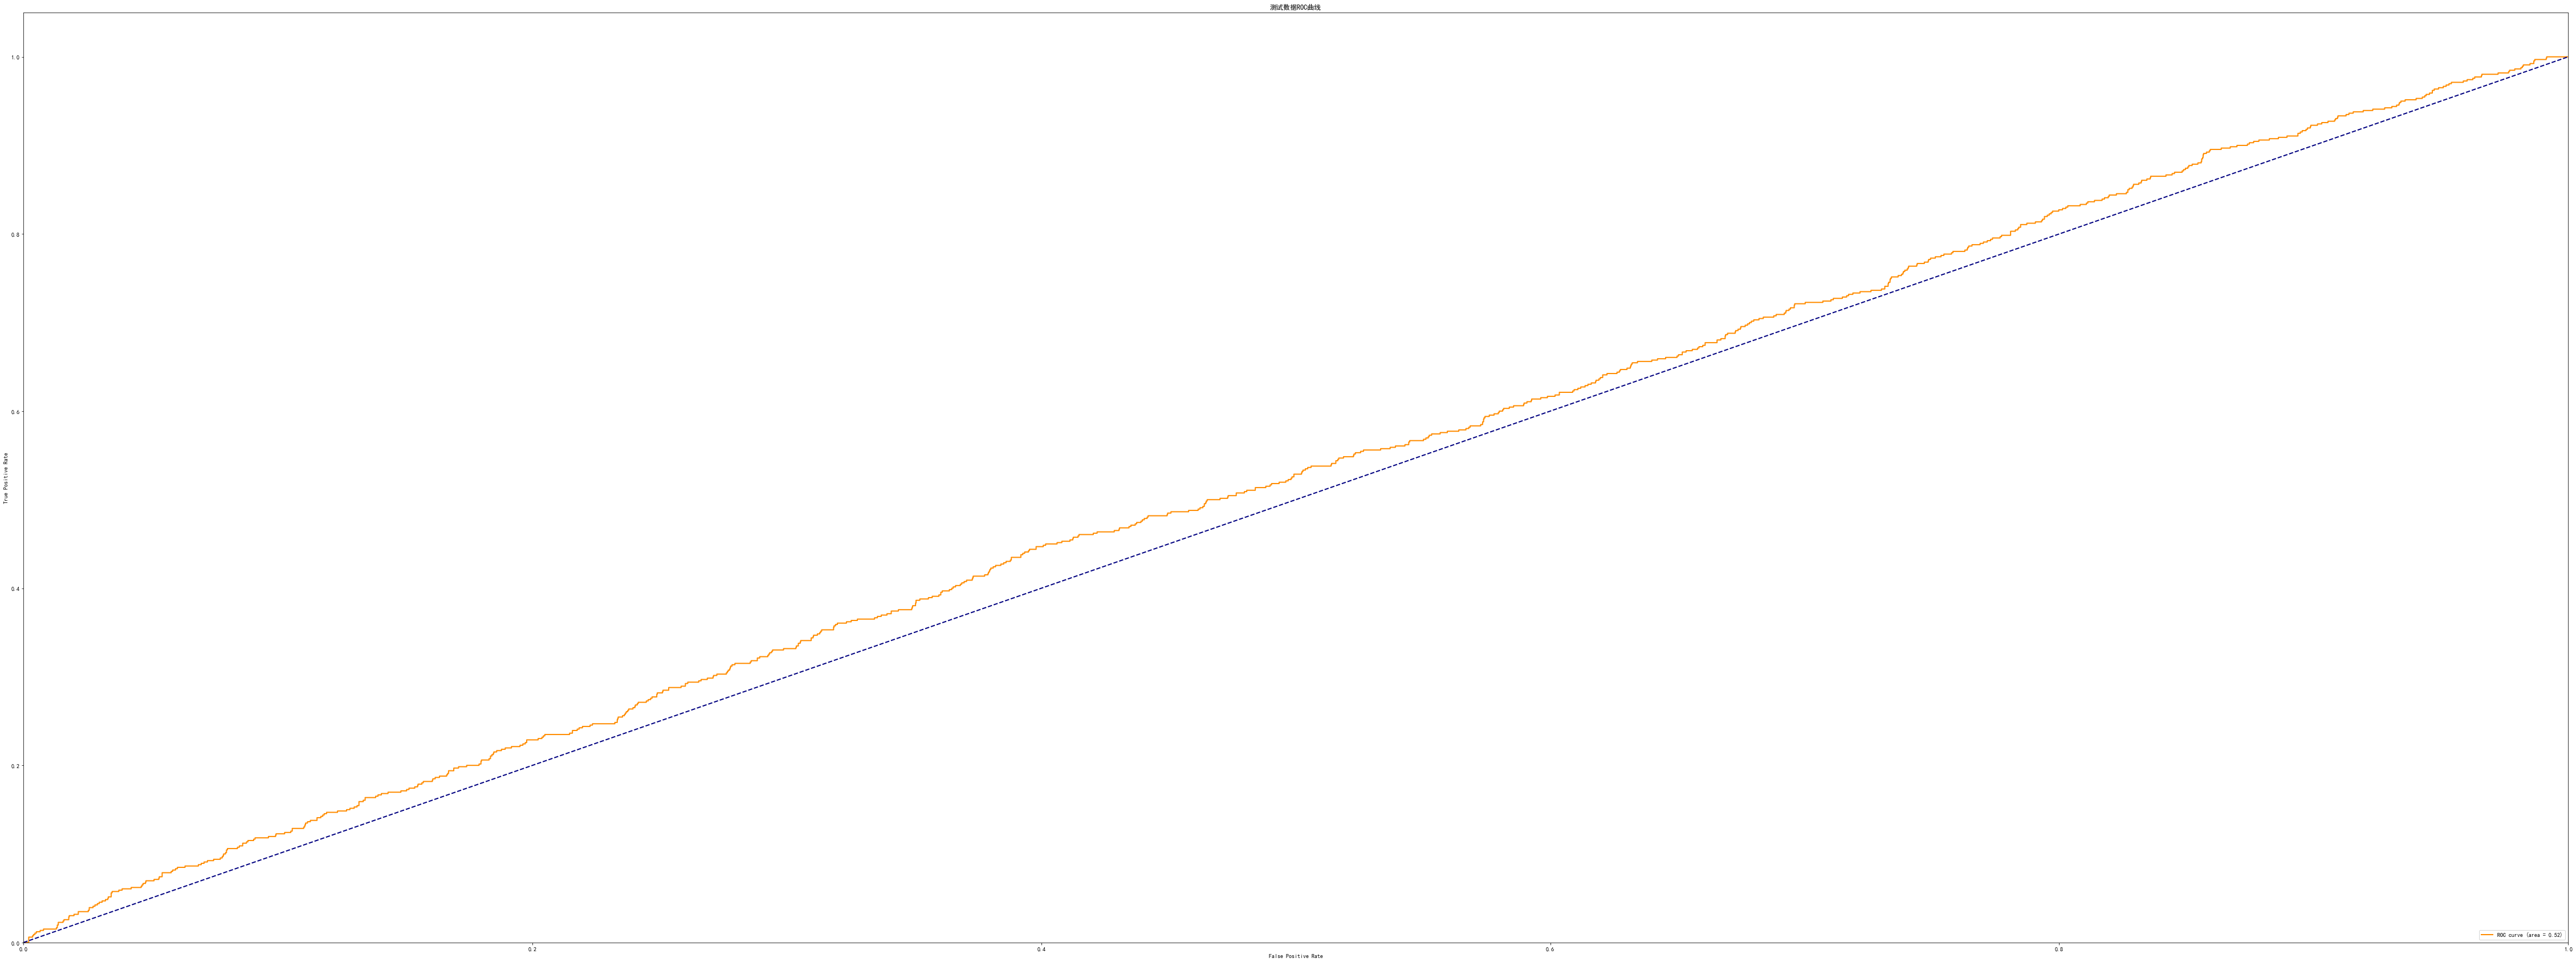

OUTLIERS :  580 INLIERS :  5420 Fast Angle-based Outlier Detector (F_ABOD)
使用算法Cluster-based Local Outlier Factor (CBLOF) 进行建模：

在训练数据集中:
Cluster-based Local Outlier Factor (CBLOF) ROC:0.5338, precision @ rank n:0.1193

在测试数据集中:
Cluster-based Local Outlier Factor (CBLOF) ROC:0.5196, precision @ rank n:0.1364


<Figure size 432x288 with 0 Axes>

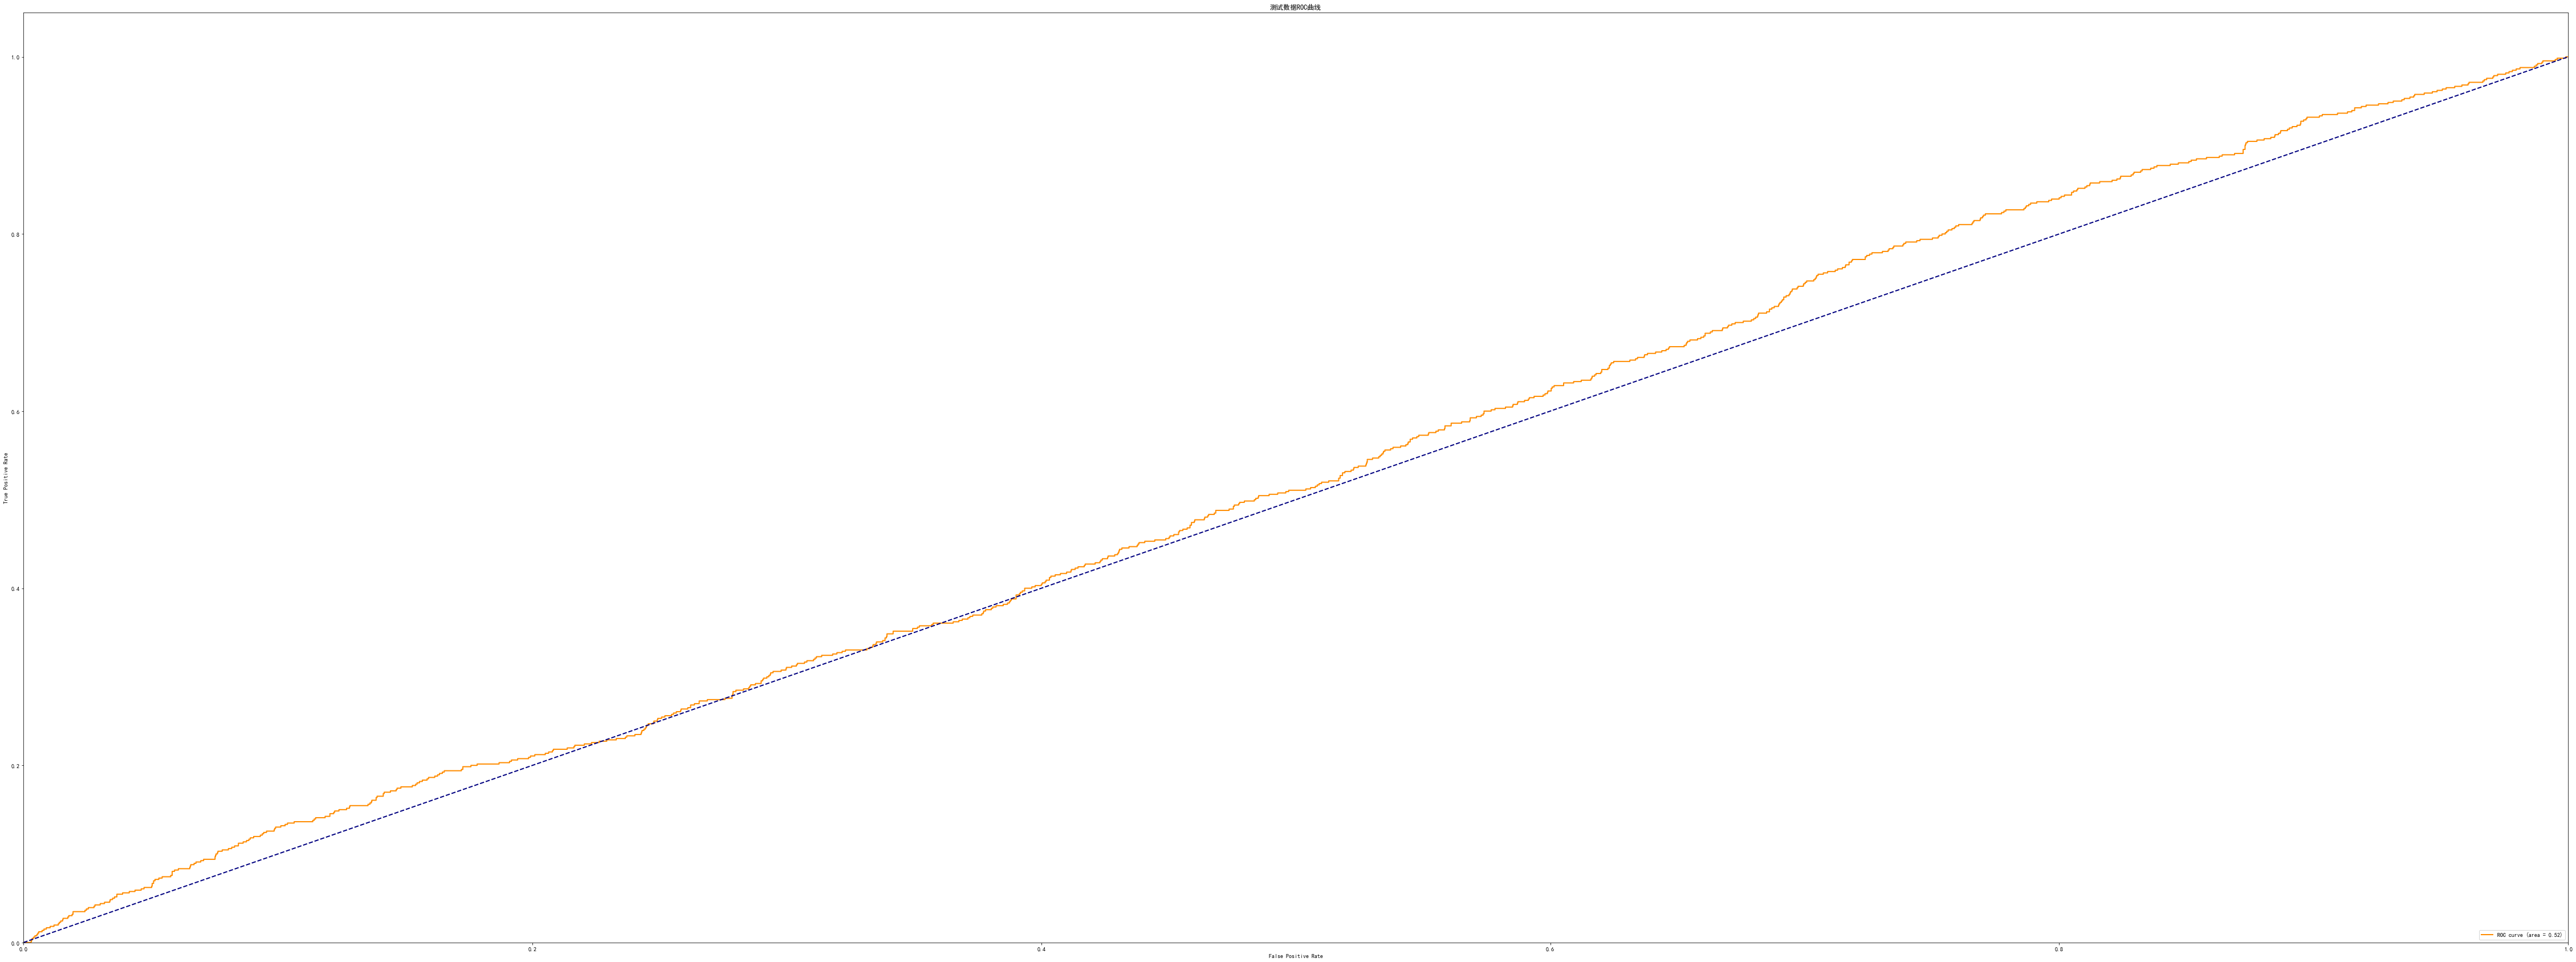

OUTLIERS :  590 INLIERS :  5410 Cluster-based Local Outlier Factor (CBLOF)
使用算法Feature Bagging 进行建模：

在训练数据集中:
Feature Bagging ROC:0.528, precision @ rank n:0.1128

在测试数据集中:
Feature Bagging ROC:0.5168, precision @ rank n:0.1227


<Figure size 432x288 with 0 Axes>

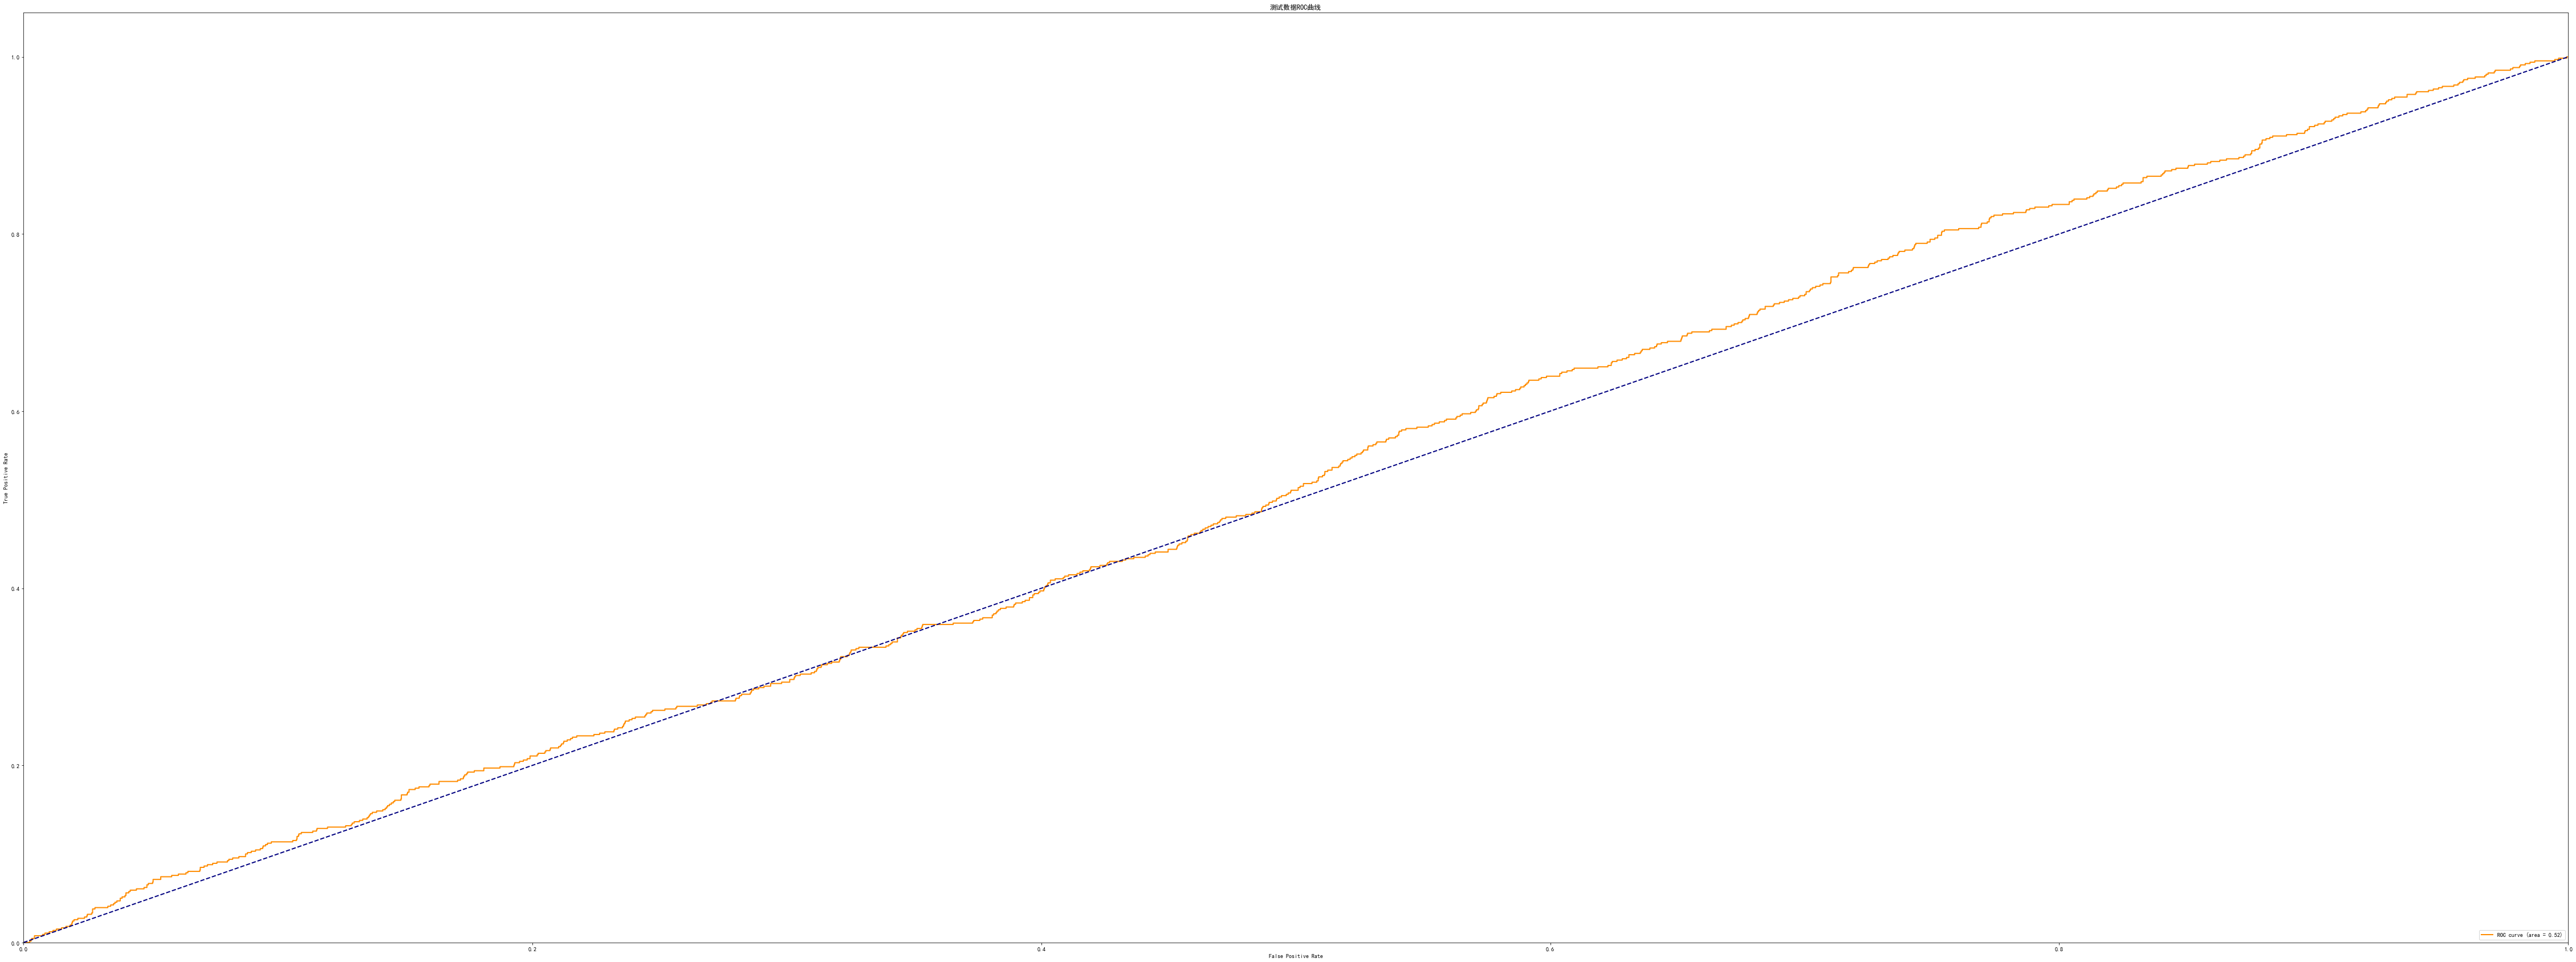

OUTLIERS :  569 INLIERS :  5431 Feature Bagging
使用算法Histogram-base Outlier Detection (HBOS) 进行建模：

在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5382, precision @ rank n:0.1415

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5485, precision @ rank n:0.1394


<Figure size 432x288 with 0 Axes>

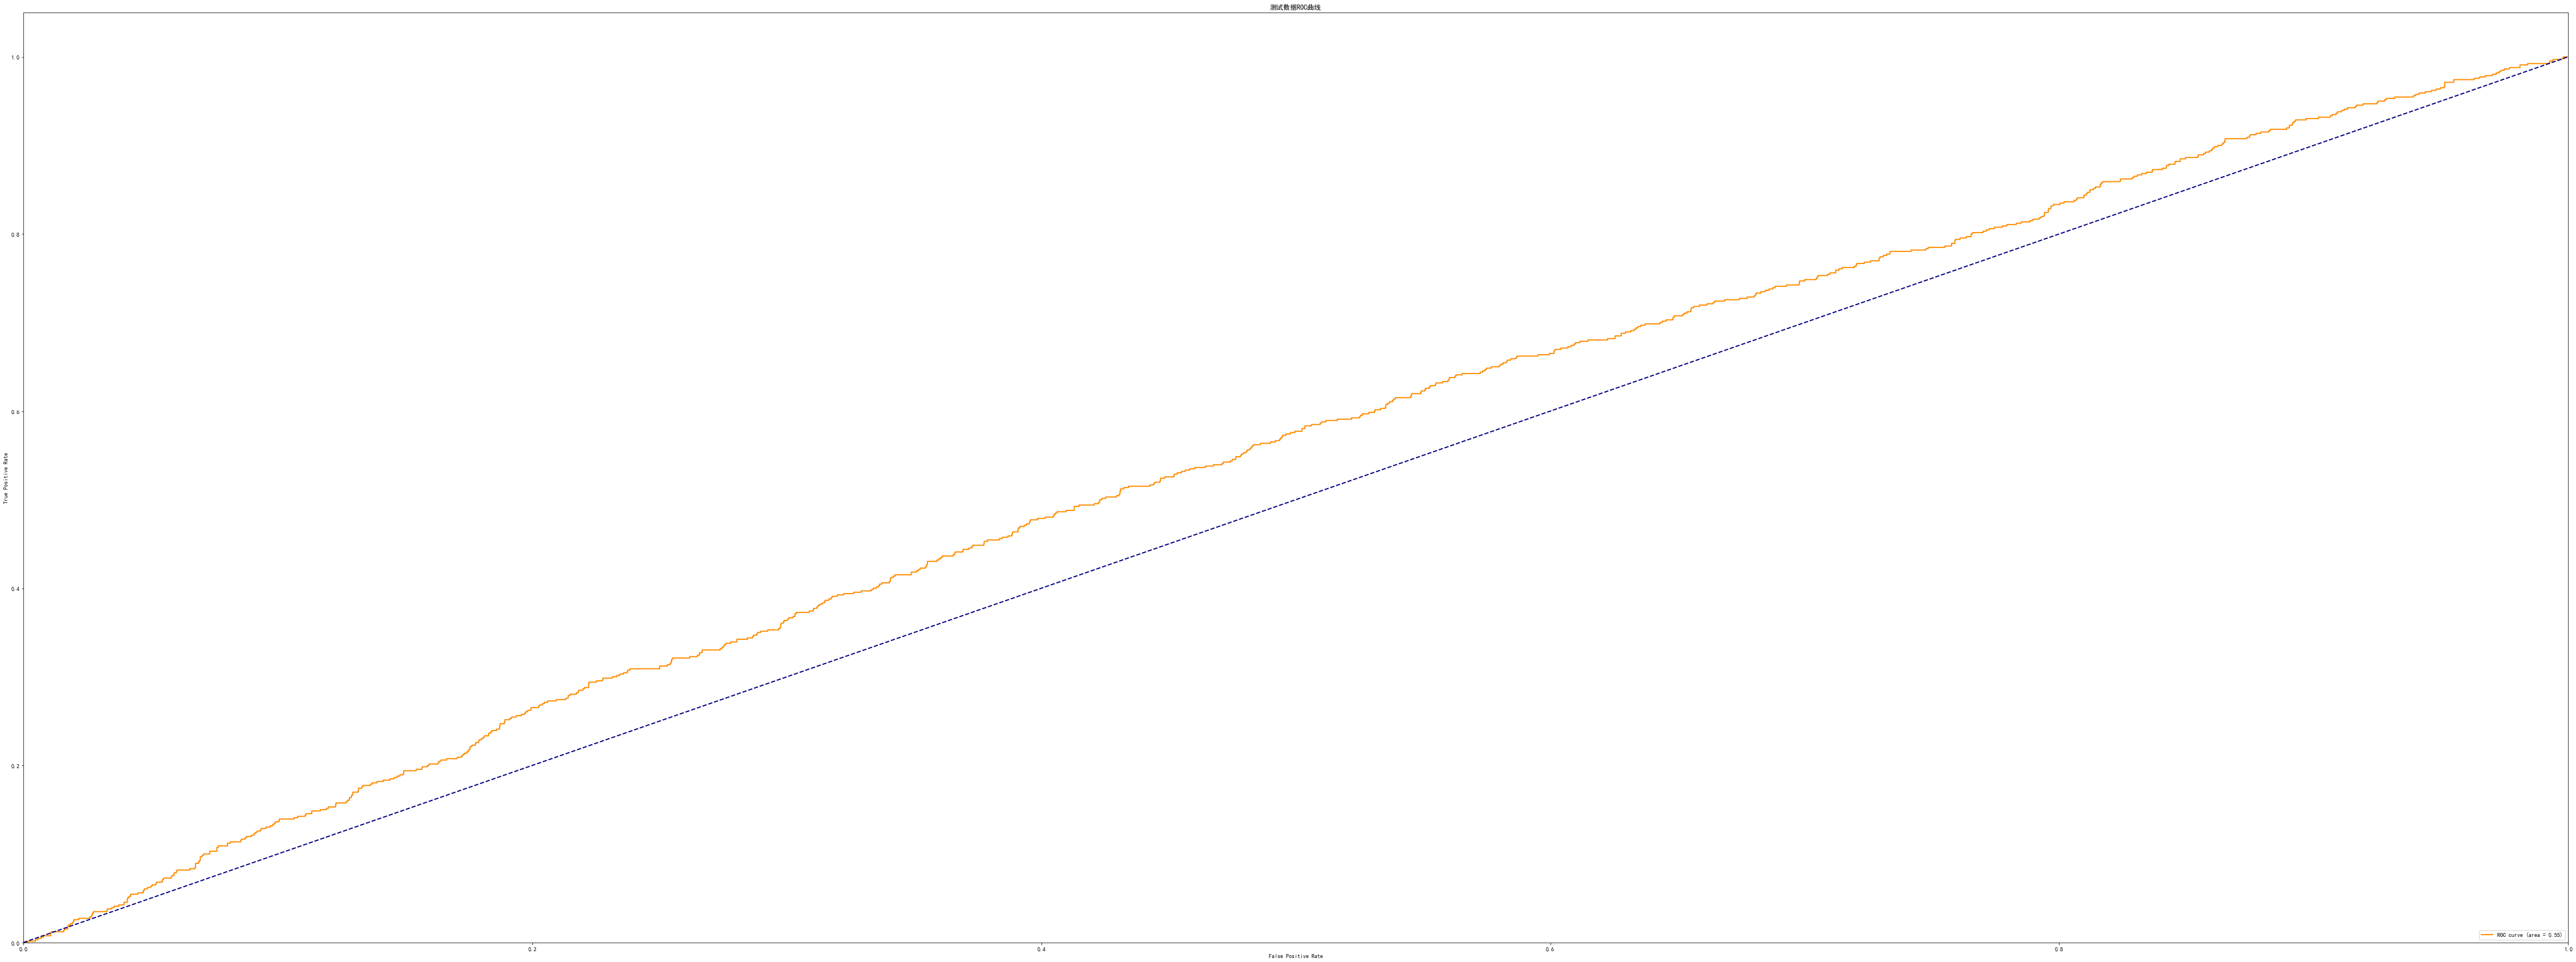

OUTLIERS :  629 INLIERS :  5371 Histogram-base Outlier Detection (HBOS)
使用算法Isolation Forest 进行建模：

在训练数据集中:
Isolation Forest ROC:0.5015, precision @ rank n:0.1284

在测试数据集中:
Isolation Forest ROC:0.5034, precision @ rank n:0.1212


<Figure size 432x288 with 0 Axes>

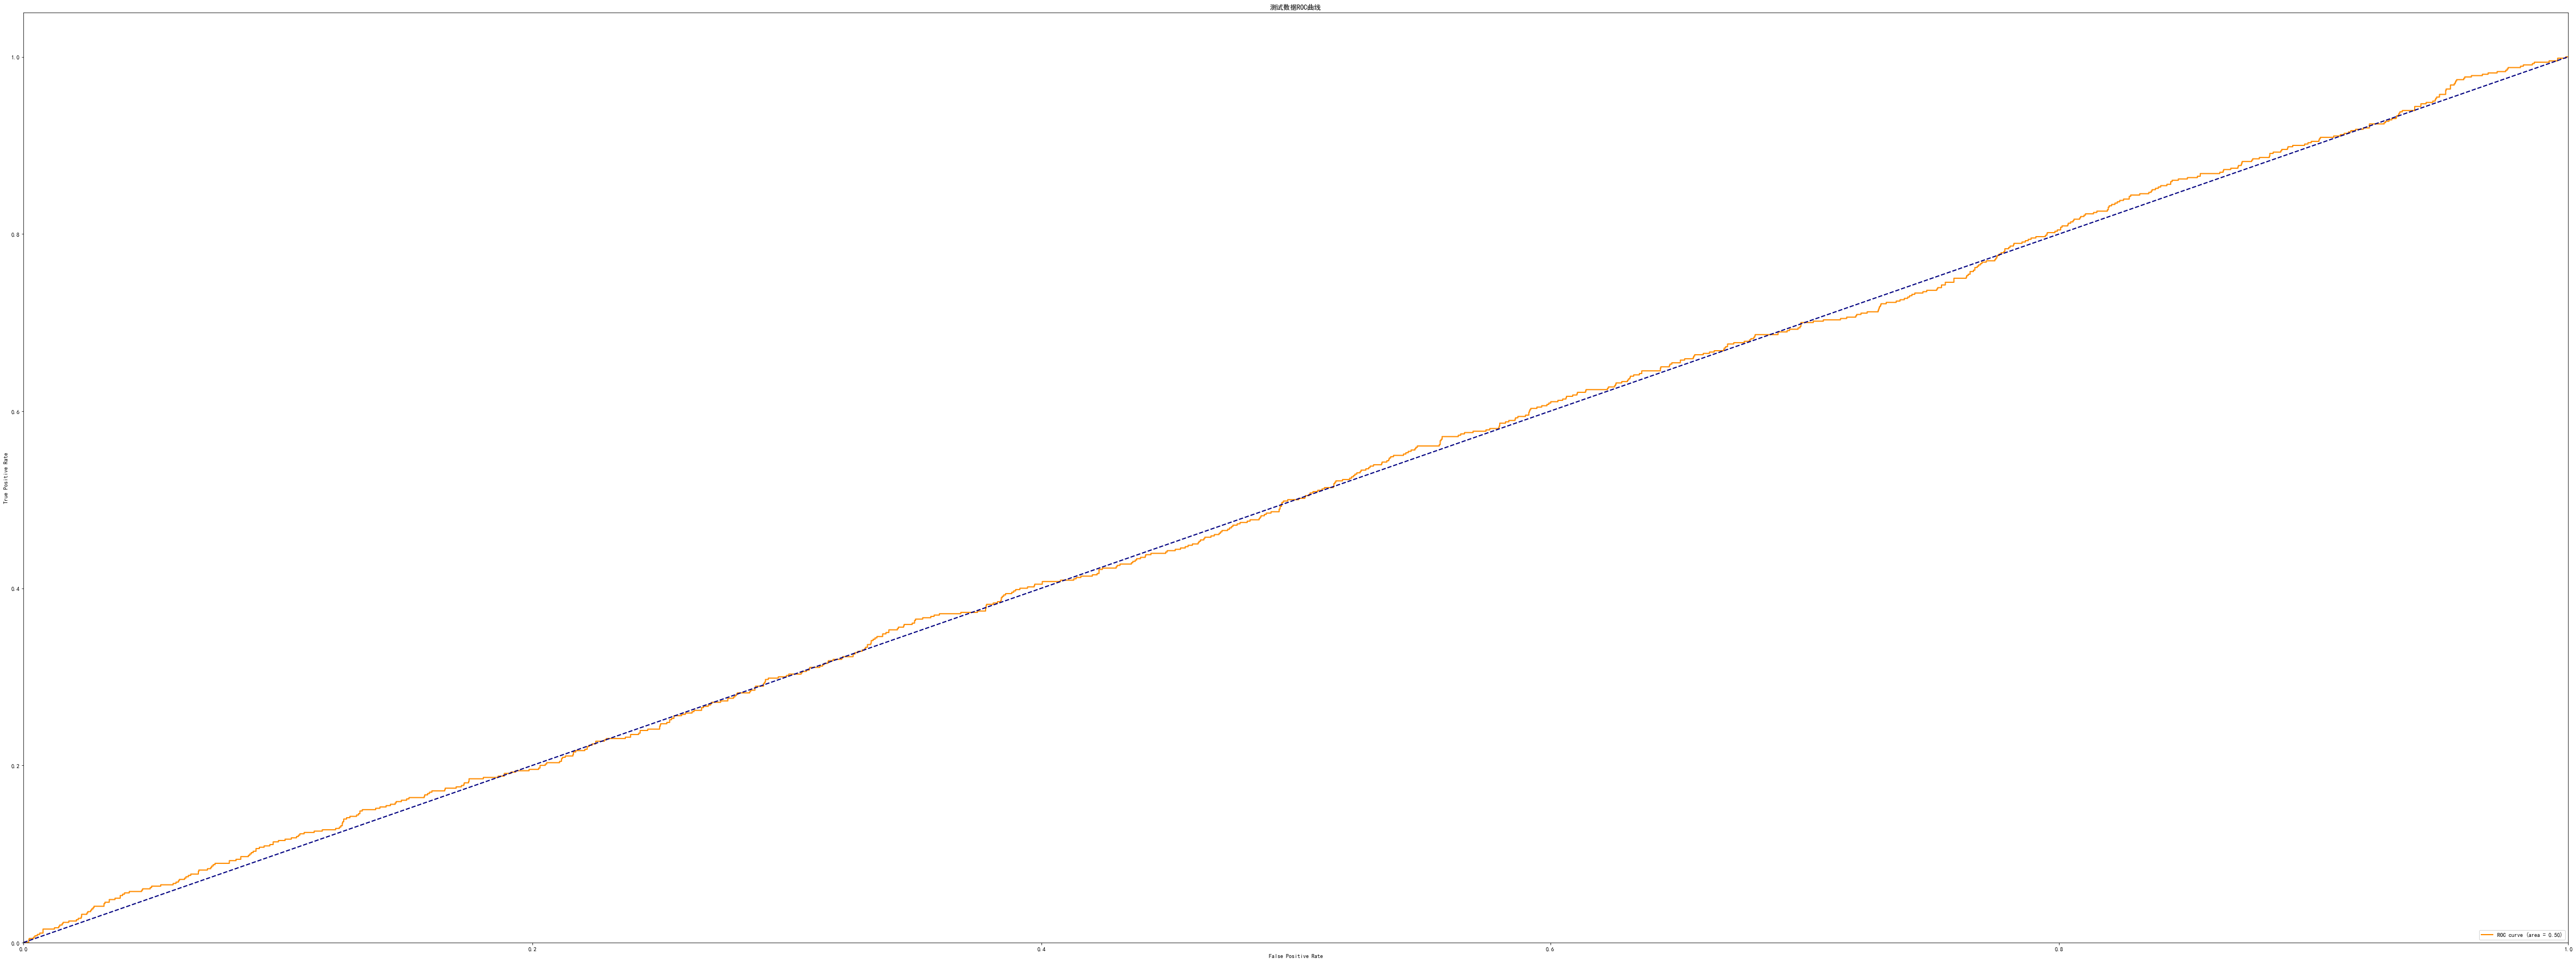

OUTLIERS :  565 INLIERS :  5435 Isolation Forest
使用算法K Nearest Neighbors (KNN) 进行建模：

在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5471, precision @ rank n:0.1219

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.536, precision @ rank n:0.1288


<Figure size 432x288 with 0 Axes>

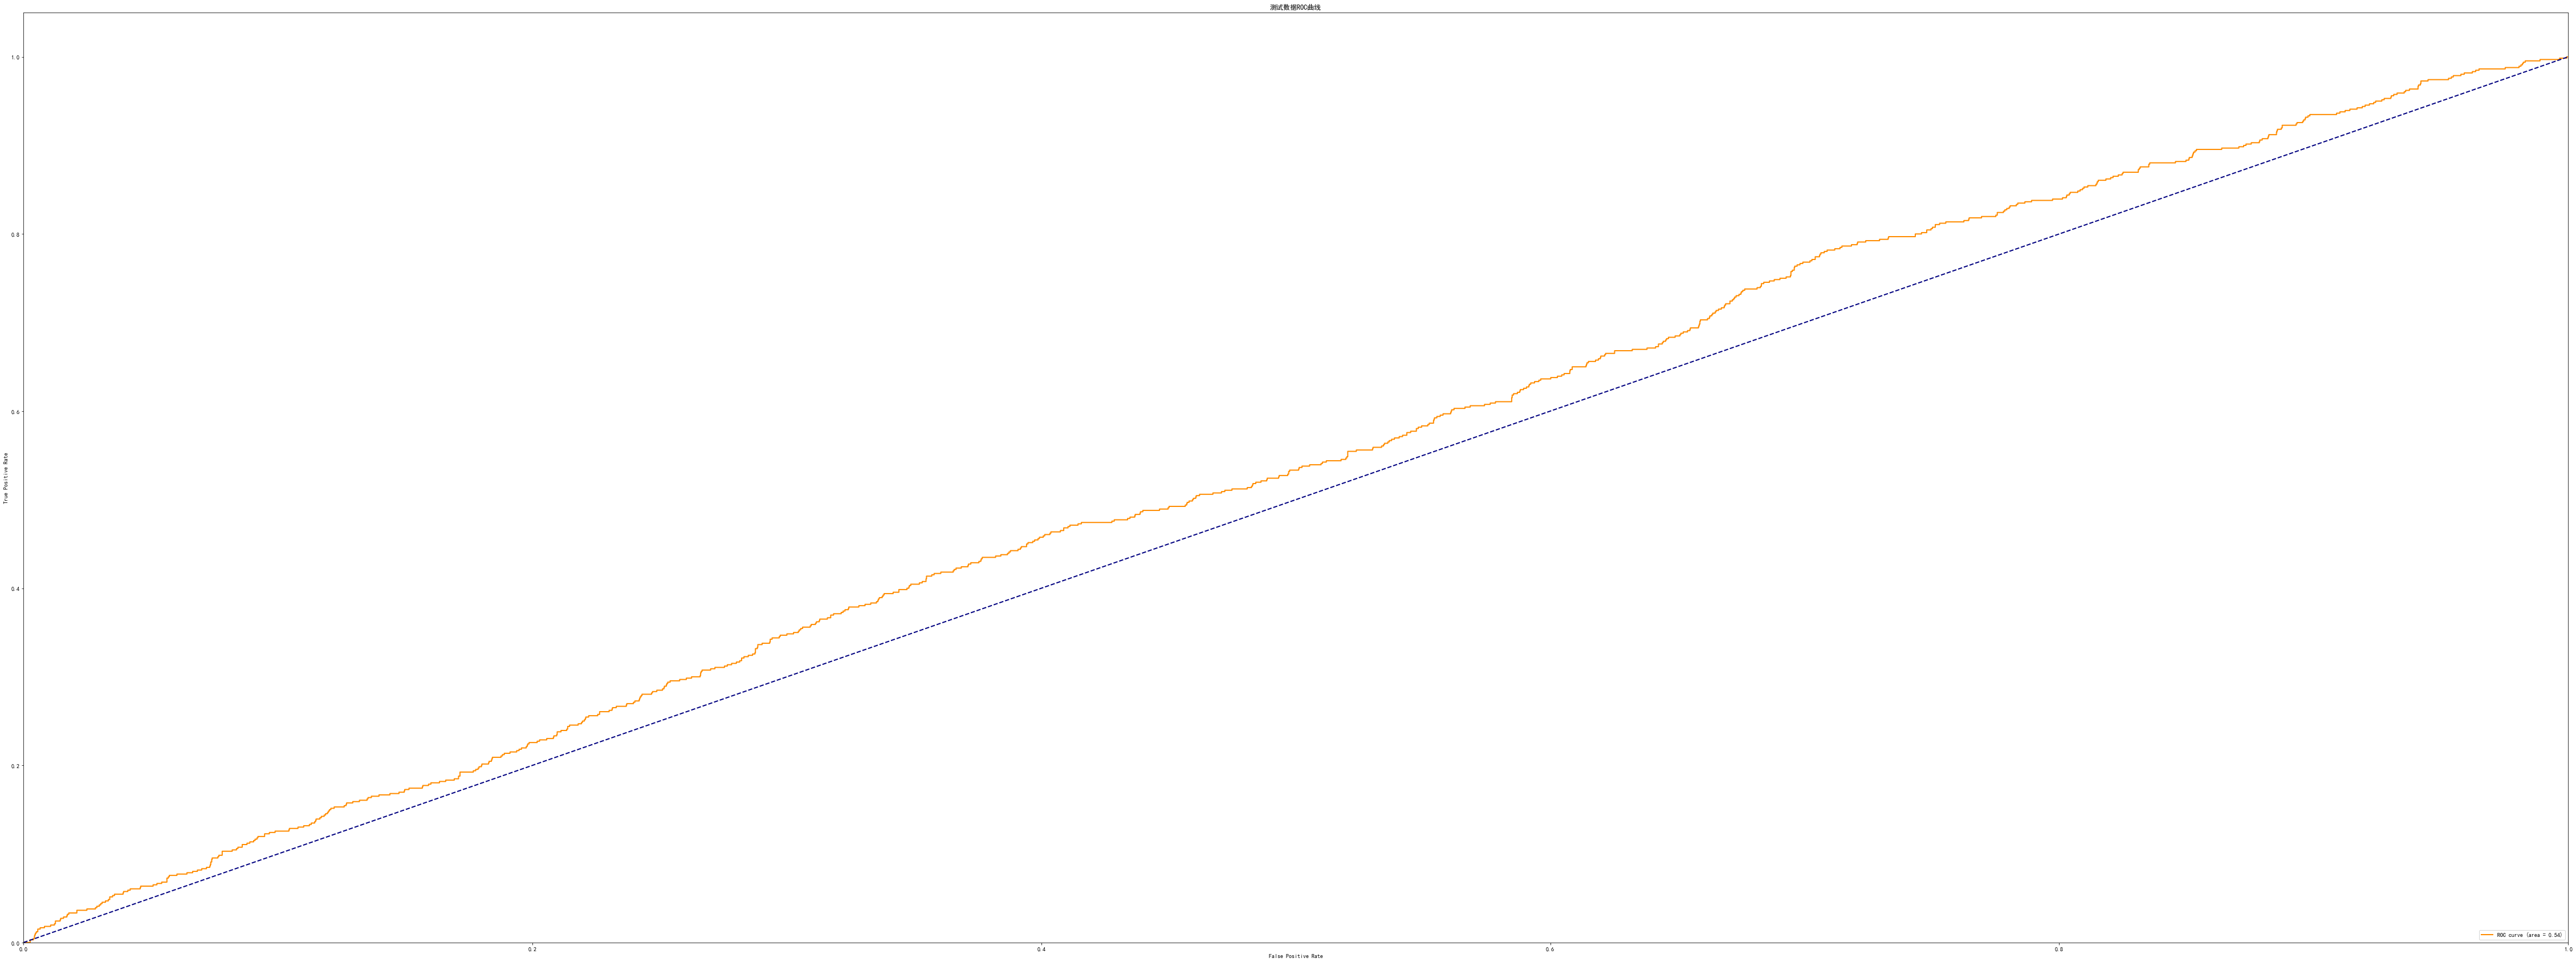

OUTLIERS :  580 INLIERS :  5420 K Nearest Neighbors (KNN)
使用算法Average KNN 进行建模：

在训练数据集中:
Average KNN ROC:0.5434, precision @ rank n:0.1206

在测试数据集中:
Average KNN ROC:0.5328, precision @ rank n:0.1242


<Figure size 432x288 with 0 Axes>

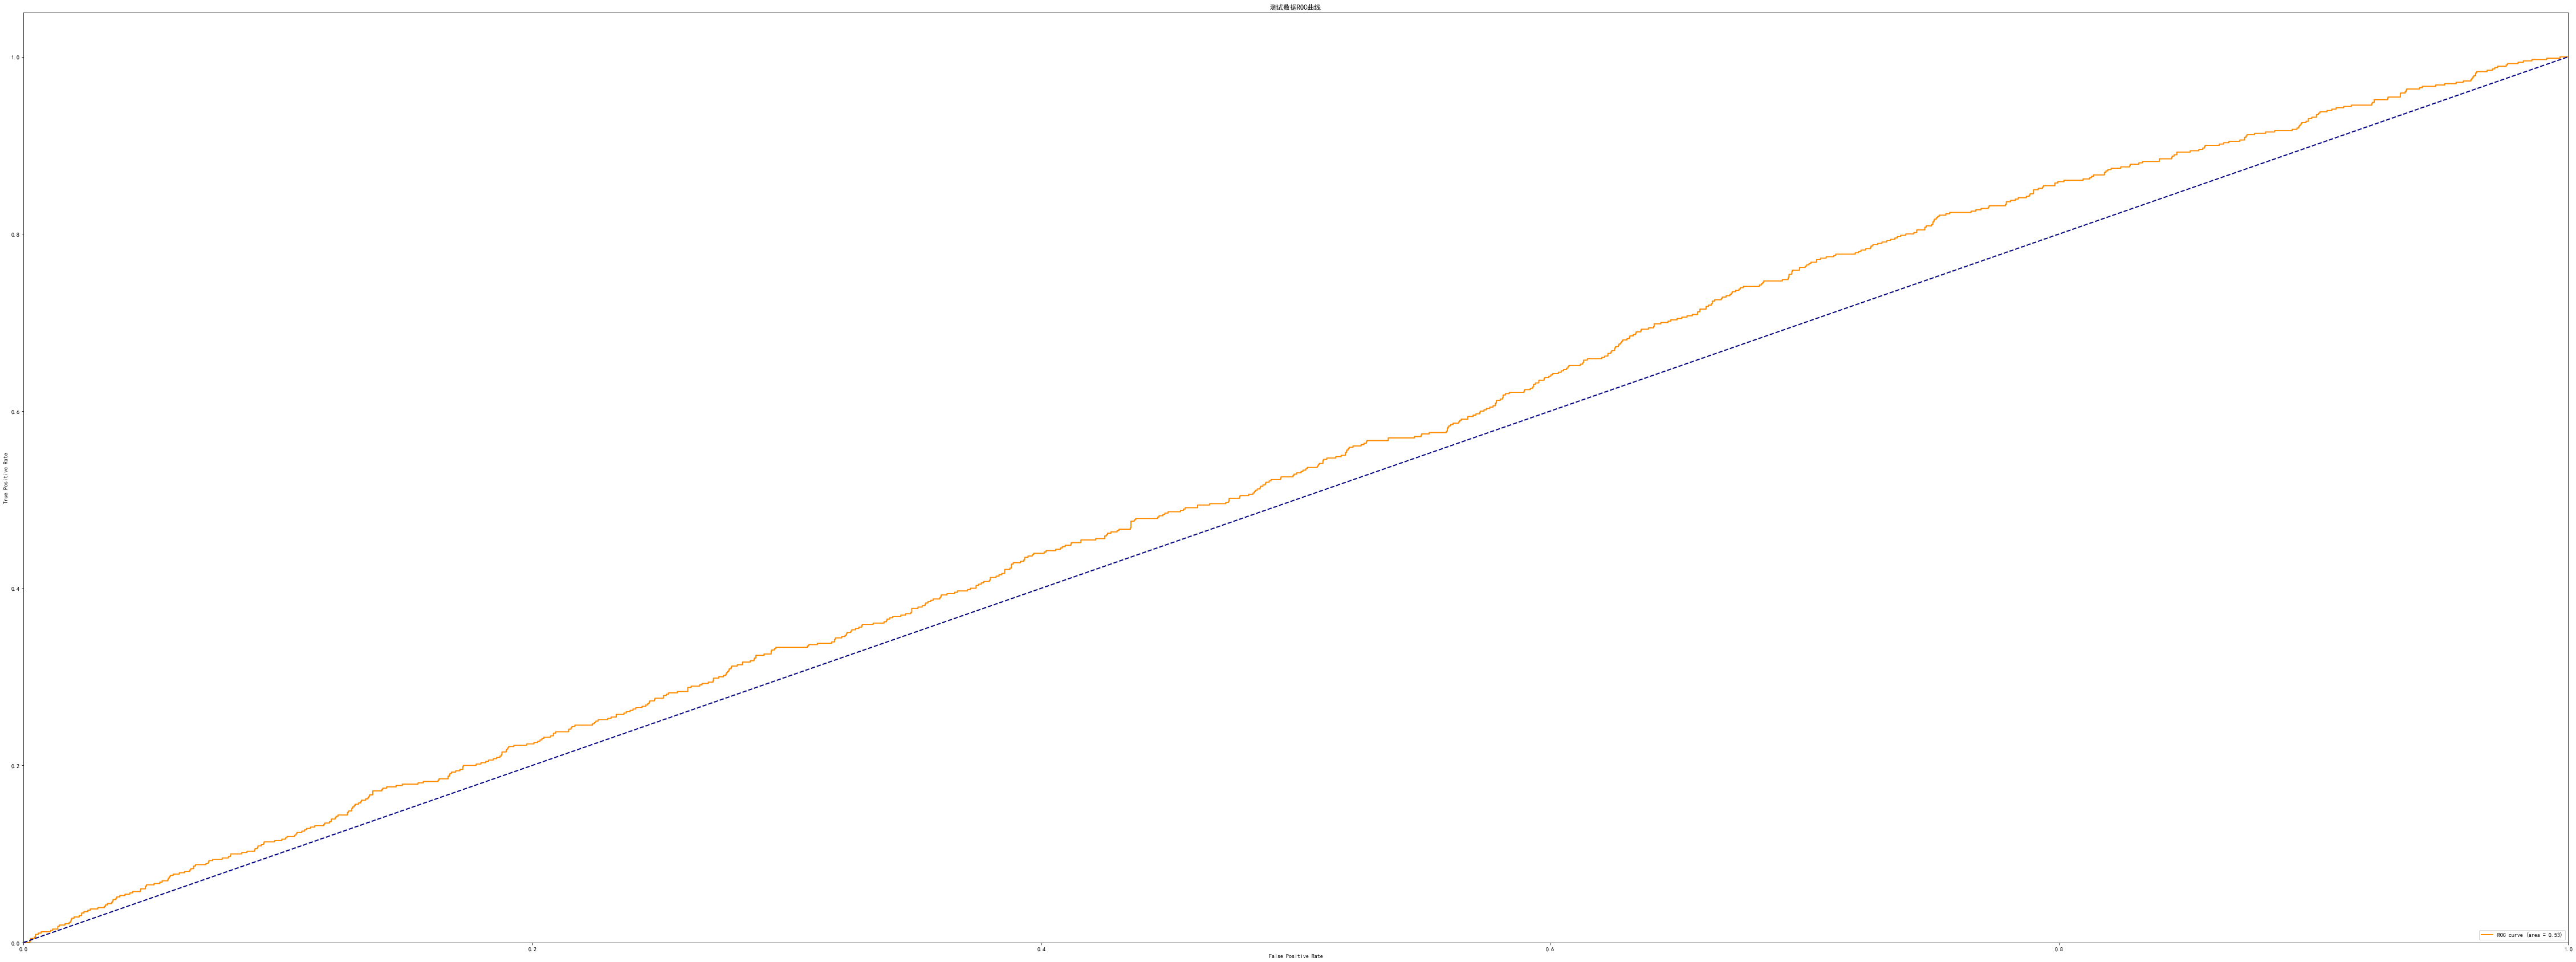

OUTLIERS :  579 INLIERS :  5421 Average KNN
使用算法Local Outlier Factor (LOF) 进行建模：

在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5276, precision @ rank n:0.1167

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5135, precision @ rank n:0.1258


<Figure size 432x288 with 0 Axes>

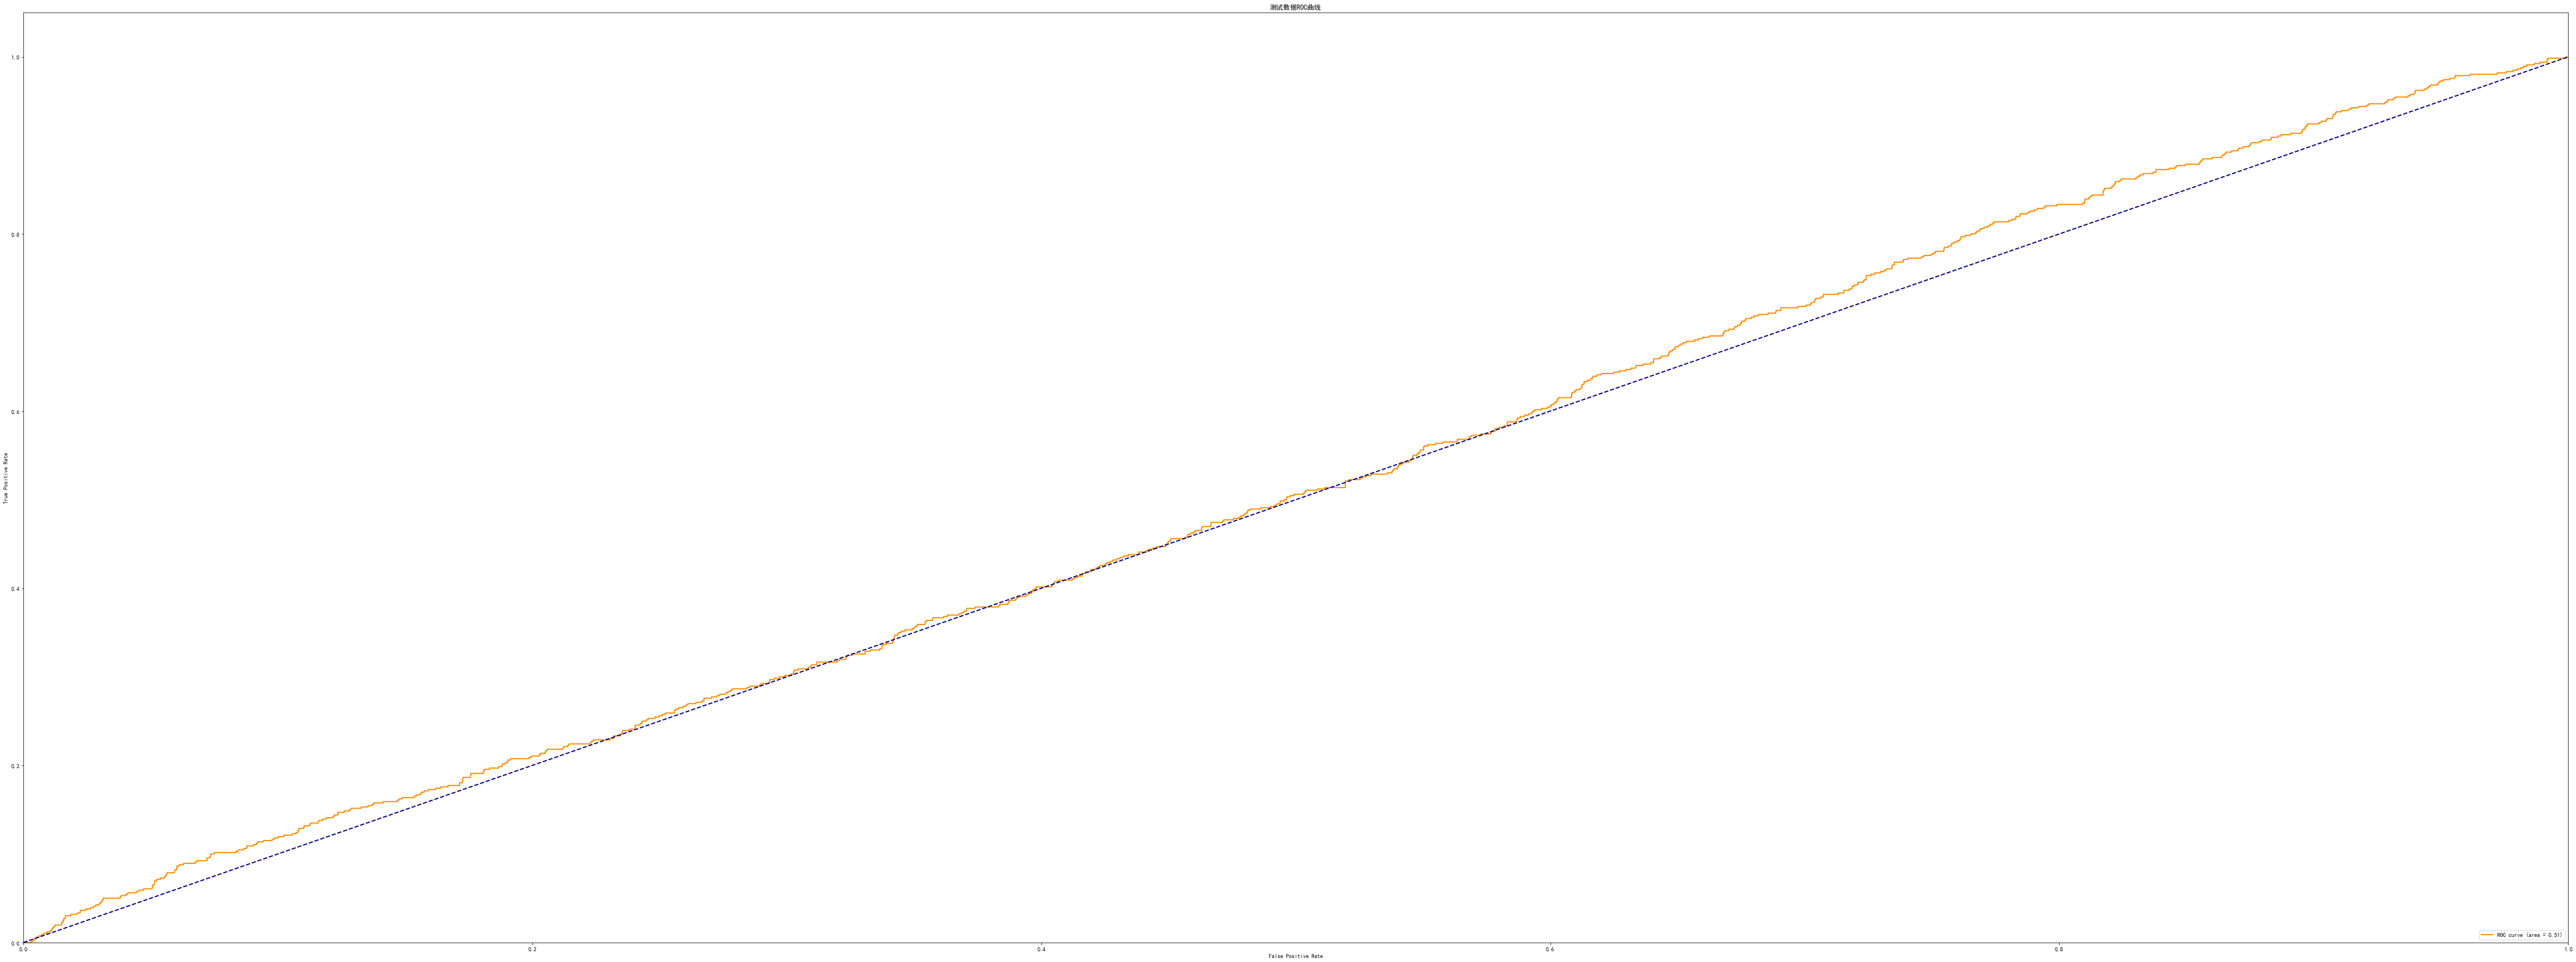

OUTLIERS :  569 INLIERS :  5431 Local Outlier Factor (LOF)
使用算法Connectivity-Based Outlier Factor (COF) 进行建模：

在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5276, precision @ rank n:0.1167

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5135, precision @ rank n:0.1258


<Figure size 432x288 with 0 Axes>

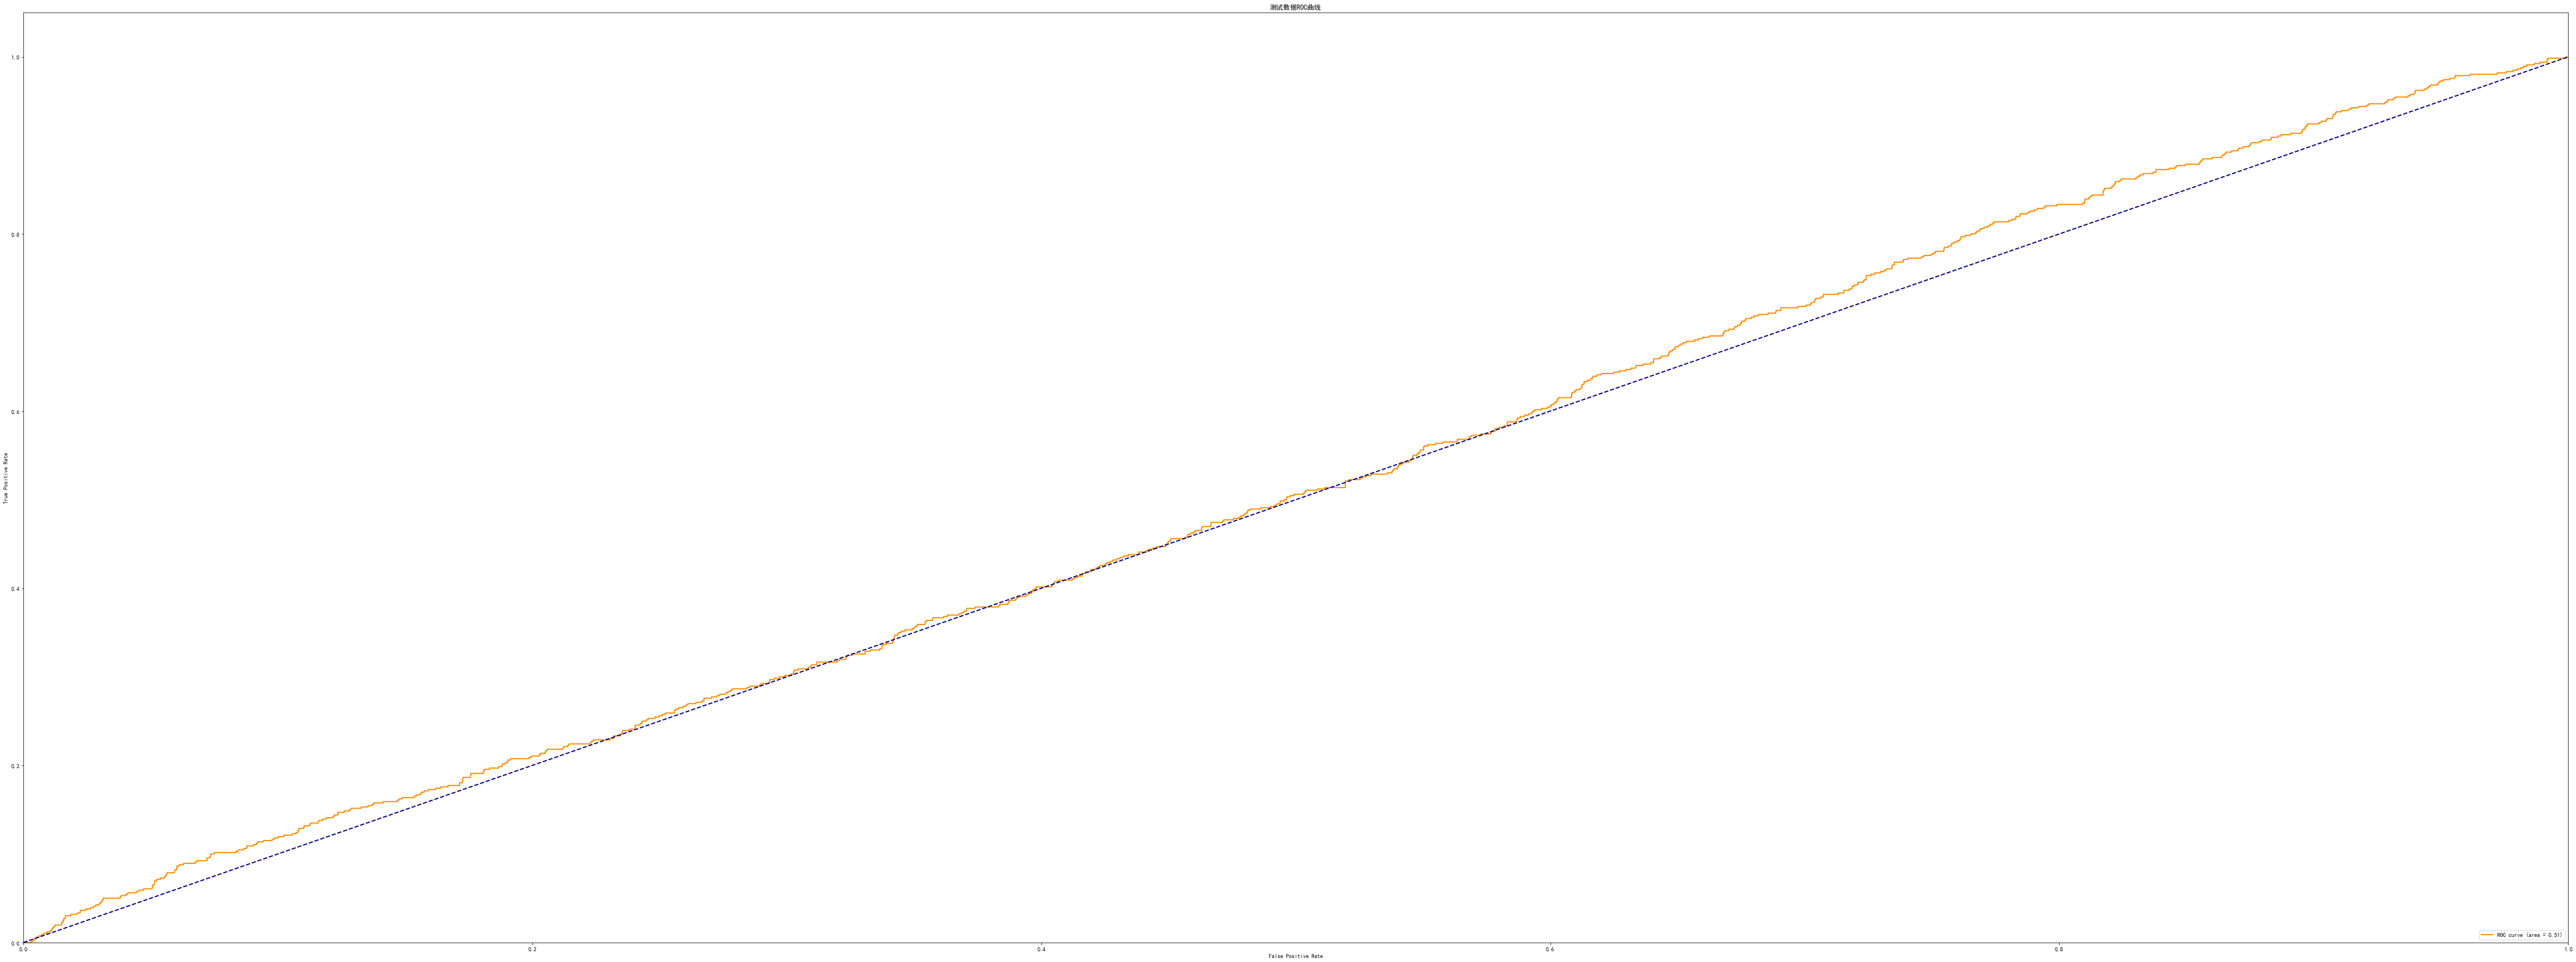

OUTLIERS :  569 INLIERS :  5431 Connectivity-Based Outlier Factor (COF)
使用算法Principal Component Analysis Outlier Detector (PCA) 进行建模：

在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5406, precision @ rank n:0.1284

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5326, precision @ rank n:0.1288


<Figure size 432x288 with 0 Axes>

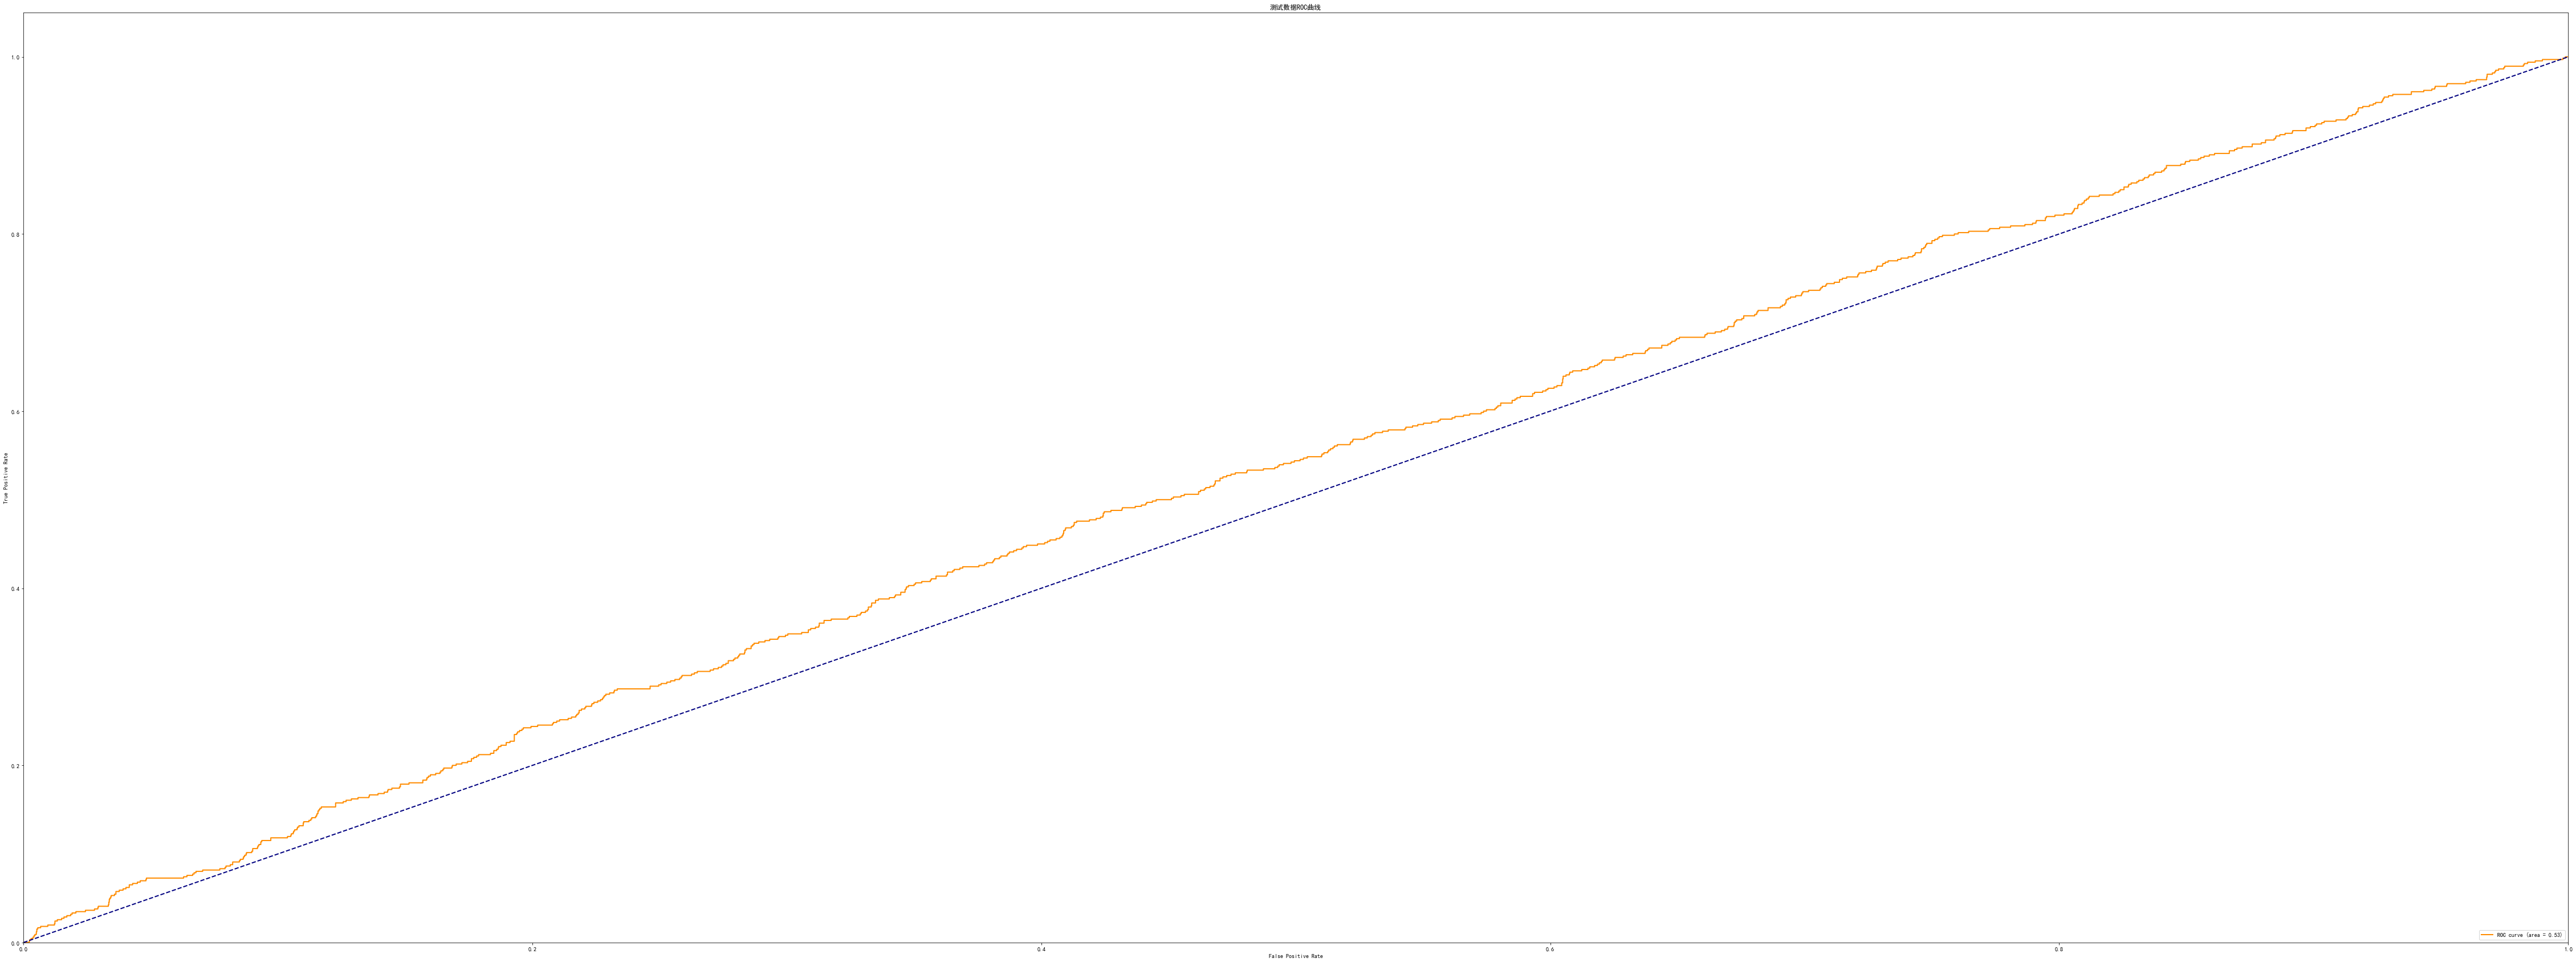

OUTLIERS :  575 INLIERS :  5425 Principal Component Analysis Outlier Detector (PCA)


In [16]:
#划分测试数据集和训练数据集
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.3,random_state=0)
for i, (clf_name, clf) in enumerate(classifiers.items()):
    print("使用算法"+clf_name+" 进行建模：")
    clf.fit(x_train)
    # 返回训练数据x_train上的异常标签和异常分值
    y_train_pred = clf.labels_  
    y_train_scores = clf.decision_scores_ 
    # 用训练好的clf来预测未知数据中的异常值
    # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
    y_test_pred = clf.predict(x_test) 
    #  返回未知数据上的异常值 (分值越大越异常)
    y_test_scores = clf.decision_function(x_test) 
    y_train_scores = y_train_scores.reshape(-1,1)
    y_test_scores = y_test_scores.reshape(-1,1)
    y_train_scores = y_train_scores.reshape(-1, 1)
    y_test_scores = y_test_scores.reshape(-1, 1)
    # if scores contain nan, change it to 0
    if np.isnan(y_train_scores).any():
         y_train_scores = np.nan_to_num(y_train_scores)
    if np.isnan(y_test_scores).any():
         y_test_scores = np.nan_to_num(y_test_scores)
#     train_scores_norm, test_scores_norm = standardizer(y_train_scores, y_test_scores)    
    print("\n在训练数据集中:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\n在测试数据集中:")
    evaluate_print(clf_name, y_test, y_test_scores)
    # 绘制ROC图
    fpr,tpr,threshold = roc_curve(y_test, y_test_scores) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
    plt.figure()
    lw = 2
    plt.figure(figsize=(80,30))
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('测试数据ROC曲线')
    plt.legend(loc="lower right")
    plt.show()
    
    # 计算离群点的个数
    n_inliers = len(y_test_pred) - np.count_nonzero(y_test_pred)
    n_outliers = np.count_nonzero(y_test_pred == 1)
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)

- 我使用了不同种类的11种方法进行建模，其中单样本检测方法有10种，包括:
    线性模型PCA；
    基于近邻的方法LOF、COF、KNN、Average KNN、CBLOF、HBOS；
    基于概率统计的方法ABOD（耗时较久）、FastABOD；
    基于离群值集合的方法Isolation Forest ；和1种离群组合框架方法 Feature Bagging。
- 该问题可以看做二分类问题，因此从ROC曲线和AUC面积中可以清楚地看到:
    结果中算法Fast Angle-based Outlier Detector (F_ABOD)在不包含niose的数据集中准确率最高，性能最好。而在包含noise的数据集中， Histogram-base Outlier Detection (HBOS)算法表现突出,其他算法都表现得不太好，需要后期的参数调优。

## 对wave_banchmark中的数据集进行处理

In [17]:
# 将所有的csv文件读取出来
# 读取所有csv文件并合并成一个dataframe,把包含noise和不包含noise的分为两个数据集
data_wave=[]
data_wave_noise = []
for root,dirs,files in walk("wave/benchmarks"):
    for i in files:
        temp = pd.read_csv(root+'/'+i)
        if temp.shape[1] == 27:
            data_wave.append(temp)
        else:
            data_wave_noise.append(temp)

### dataframe的合并

In [18]:
data_wave_all = pd.concat(data_wave)
data_wave_noise_all = pd.concat(data_wave_noise)
print(data_wave_all.columns)
print(data_wave_noise_all.columns)

Index(['point.id', 'motherset', 'origin', 'original.label', 'diff.score',
       'ground.truth', 'V', 'V.1', 'V.2', 'V.3', 'V.4', 'V.5', 'V.6', 'V.7',
       'V.8', 'V.9', 'V.10', 'V.11', 'V.12', 'V.13', 'V.14', 'V.15', 'V.16',
       'V.17', 'V.18', 'V.19', 'V.20'],
      dtype='object')
Index(['point.id', 'motherset', 'origin', 'original.label', 'diff.score',
       'ground.truth', 'V', 'V.1', 'V.2', 'V.3', 'V.4', 'V.5', 'V.6', 'V.7',
       'V.8', 'V.9', 'V.10', 'V.11', 'V.12', 'V.13', 'V.14', 'V.15', 'V.16',
       'V.17', 'V.18', 'V.19', 'V.20', 'noise..1', 'noise..2', 'noise..3',
       'noise..4', 'noise..5', 'noise..6', 'noise..7', 'noise..8', 'noise..9',
       'noise..10', 'noise..11', 'noise..12', 'noise..13', 'noise..14',
       'noise..15', 'noise..16', 'noise..17', 'noise..18', 'noise..19',
       'noise..20', 'noise..21', 'noise..22', 'noise..23', 'noise..24',
       'noise..25', 'noise..26', 'noise..27', 'noise..28', 'noise..29',
       'noise..30', 'noise..31', 'noise.

### 舍弃motherset、origin属性

In [19]:
print(data_wine_all['origin'].value_counts())
print(data_wine_all['motherset'].value_counts())

# 建立对应的属性列表
column_names = data_wave_all.columns.tolist()
noise_column_names = data_wave_noise_all.columns.tolist()
print(column_names)
print(noise_column_names)

regression    1049492
Name: origin, dtype: int64
wine    1049492
Name: motherset, dtype: int64
['point.id', 'motherset', 'origin', 'original.label', 'diff.score', 'ground.truth', 'V', 'V.1', 'V.2', 'V.3', 'V.4', 'V.5', 'V.6', 'V.7', 'V.8', 'V.9', 'V.10', 'V.11', 'V.12', 'V.13', 'V.14', 'V.15', 'V.16', 'V.17', 'V.18', 'V.19', 'V.20']
['point.id', 'motherset', 'origin', 'original.label', 'diff.score', 'ground.truth', 'V', 'V.1', 'V.2', 'V.3', 'V.4', 'V.5', 'V.6', 'V.7', 'V.8', 'V.9', 'V.10', 'V.11', 'V.12', 'V.13', 'V.14', 'V.15', 'V.16', 'V.17', 'V.18', 'V.19', 'V.20', 'noise..1', 'noise..2', 'noise..3', 'noise..4', 'noise..5', 'noise..6', 'noise..7', 'noise..8', 'noise..9', 'noise..10', 'noise..11', 'noise..12', 'noise..13', 'noise..14', 'noise..15', 'noise..16', 'noise..17', 'noise..18', 'noise..19', 'noise..20', 'noise..21', 'noise..22', 'noise..23', 'noise..24', 'noise..25', 'noise..26', 'noise..27', 'noise..28', 'noise..29', 'noise..30', 'noise..31', 'noise..32', 'noise..33', 'nois

In [20]:
wave_DF = data_wave_all[column_names]
print('删除前元组数：'+str(len(wave_DF)))
# 删除所有属性值都相同的元组
wave_DF = wave_DF.drop_duplicates()
print('删除后元组数：'+str(len(wave_DF)))


wave_noise_DF = data_wave_noise_all[noise_column_names]
print('noise数据集删除前元组数：'+str(len(wave_noise_DF)))
# 删除所有属性值都相同的元组
wave_noise_DF = wave_noise_DF.drop_duplicates()
print('noise数据集删除后元组数：'+str(len(wave_noise_DF)))

#序号索引需要重新创建
wave_DF.reset_index(inplace=True,drop=True)
# 对noise数据集进行随机抽样
wave_noise_DF = wave_noise_DF.sample(20000)

wave_noise_DF = wave_noise_DF.dropna()
wave_DF = wave_DF.dropna()

删除前元组数：646173
删除后元组数：5000
noise数据集删除前元组数：1986780
noise数据集删除后元组数：1986780


### 创建模型字典

#### 我们使用不同的算法对数据集进行训练

In [21]:
# 离群点分析
random_state = np.random.RandomState(52)
outliers_fraction = 0.1

classifiers = {
        'Fast Angle-based Outlier Detector (F_ABOD)': ABOD(contamination=outliers_fraction,method='fast'),
        #'Original Angle-based Outlier Detector (O_ABOD)': ABOD(contamination=outliers_fraction,method='default'),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(n_neighbors=250, method='largest',contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction),
        'Local Outlier Factor (LOF)':LOF(contamination=outliers_fraction,n_neighbors=200),
        'Connectivity-Based Outlier Factor (COF)':LOF(contamination=outliers_fraction,n_neighbors=200),
        'Principal Component Analysis Outlier Detector (PCA)':PCA(contamination=outliers_fraction,weighted=True,n_components='mle',svd_solver ='full')
}

### 处理不包含noise的数据集

In [22]:
# 创建训练数据集
train_DF = wave_DF
train_DF['ground.truth']=train_DF['ground.truth'].map({'nominal': 0,'anomaly':1})

### 对数据集进行训练，并在测试数据集上进行预测

In [23]:
X = train_DF[[ 'original.label', 'diff.score',
        'V', 'V.1', 'V.2', 'V.3', 'V.4', 'V.5', 'V.6', 'V.7',
       'V.8', 'V.9', 'V.10', 'V.11', 'V.12', 'V.13', 'V.14', 'V.15', 'V.16',
       'V.17', 'V.18', 'V.19', 'V.20']].values
Y = train_DF['ground.truth'].values

使用算法Fast Angle-based Outlier Detector (F_ABOD) 进行建模：

在训练数据集中:
Fast Angle-based Outlier Detector (F_ABOD) ROC:0.5354, precision @ rank n:0.3493

在测试数据集中:
Fast Angle-based Outlier Detector (F_ABOD) ROC:0.5359, precision @ rank n:0.3711


<Figure size 432x288 with 0 Axes>

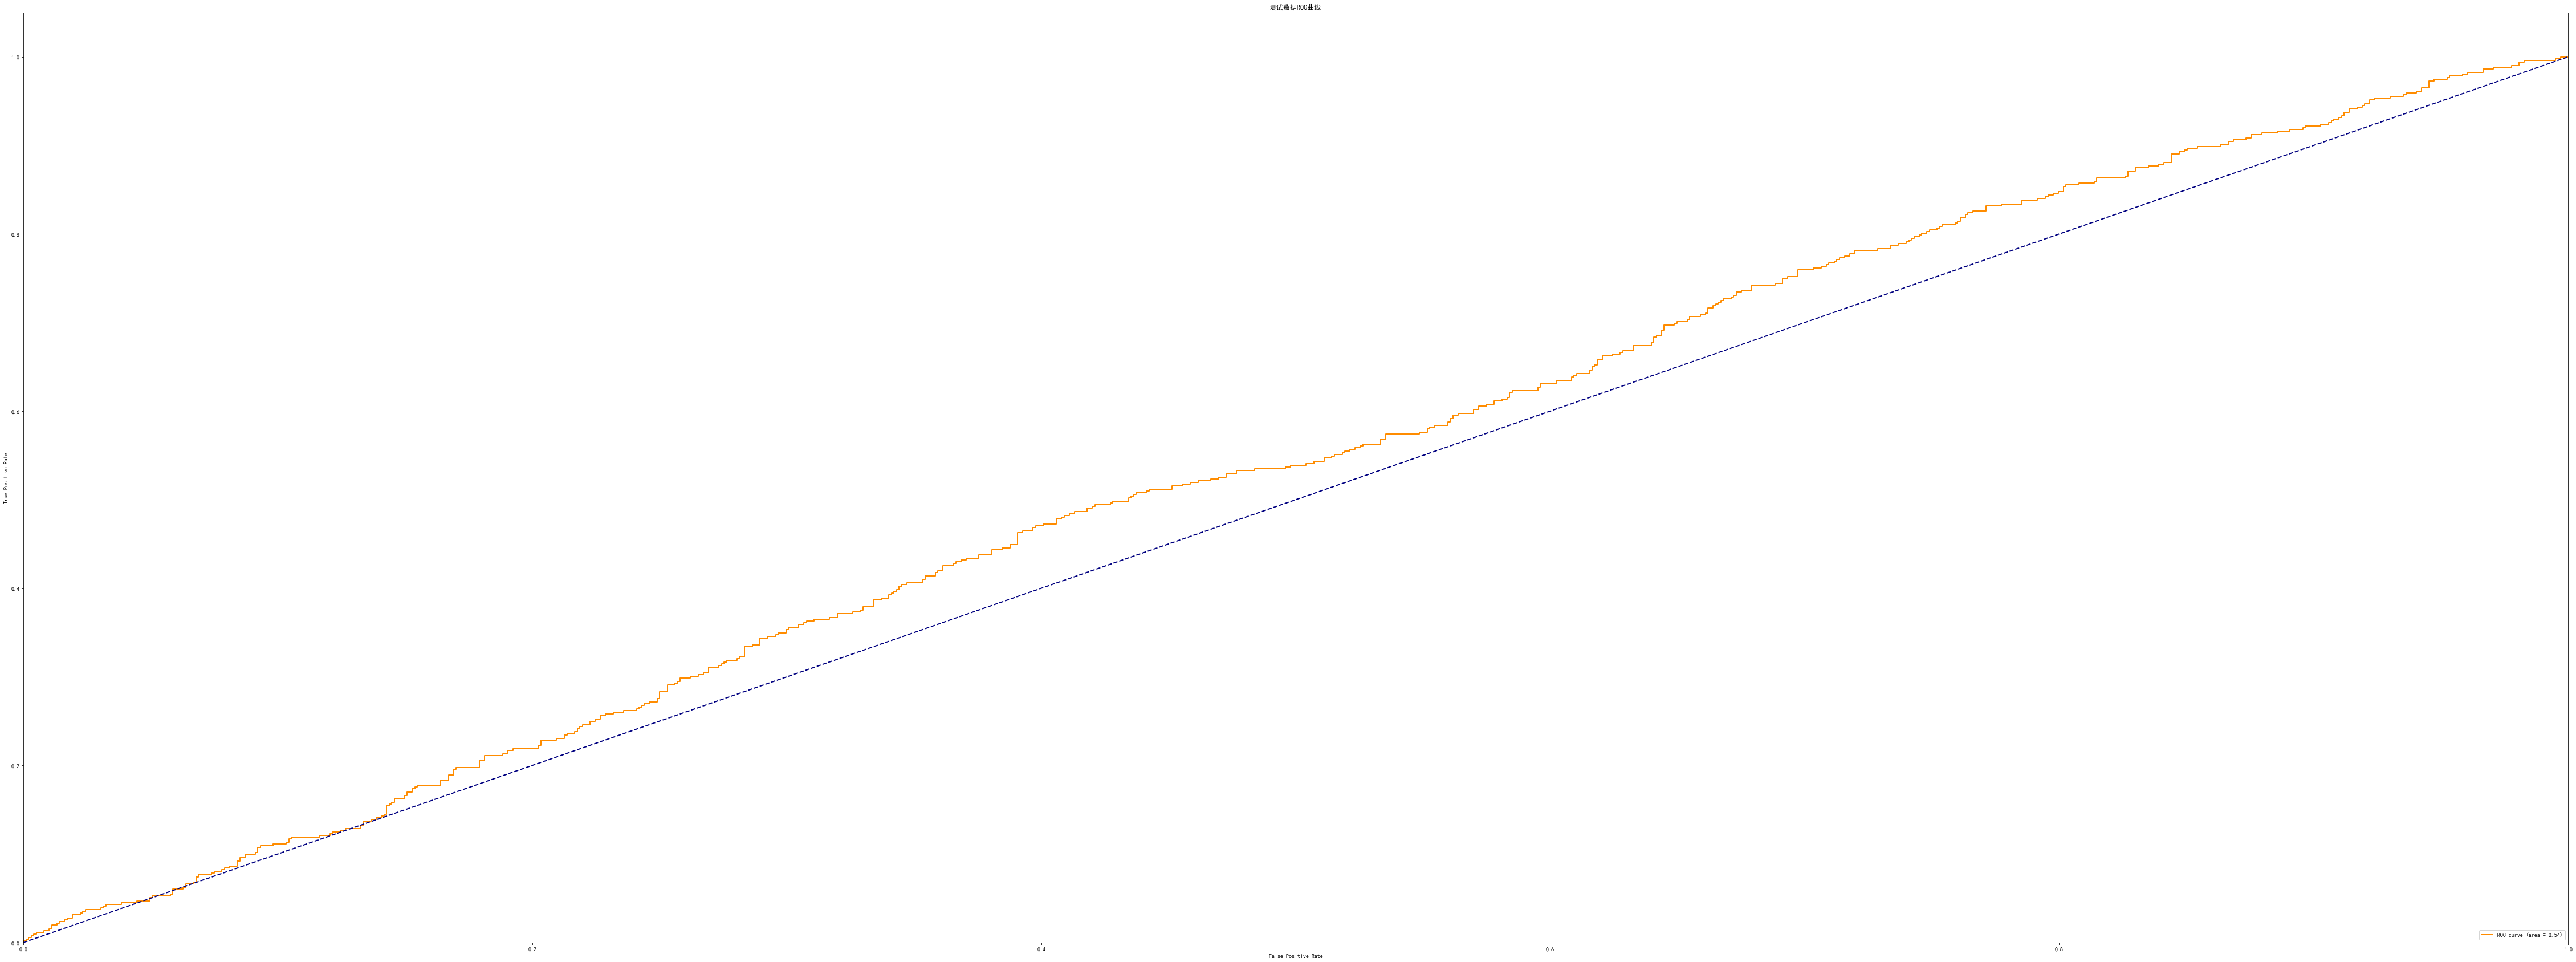

OUTLIERS :  147 INLIERS :  1353 Fast Angle-based Outlier Detector (F_ABOD)
使用算法Cluster-based Local Outlier Factor (CBLOF) 进行建模：

在训练数据集中:
Cluster-based Local Outlier Factor (CBLOF) ROC:0.5574, precision @ rank n:0.3808

在测试数据集中:
Cluster-based Local Outlier Factor (CBLOF) ROC:0.5758, precision @ rank n:0.4316


<Figure size 432x288 with 0 Axes>

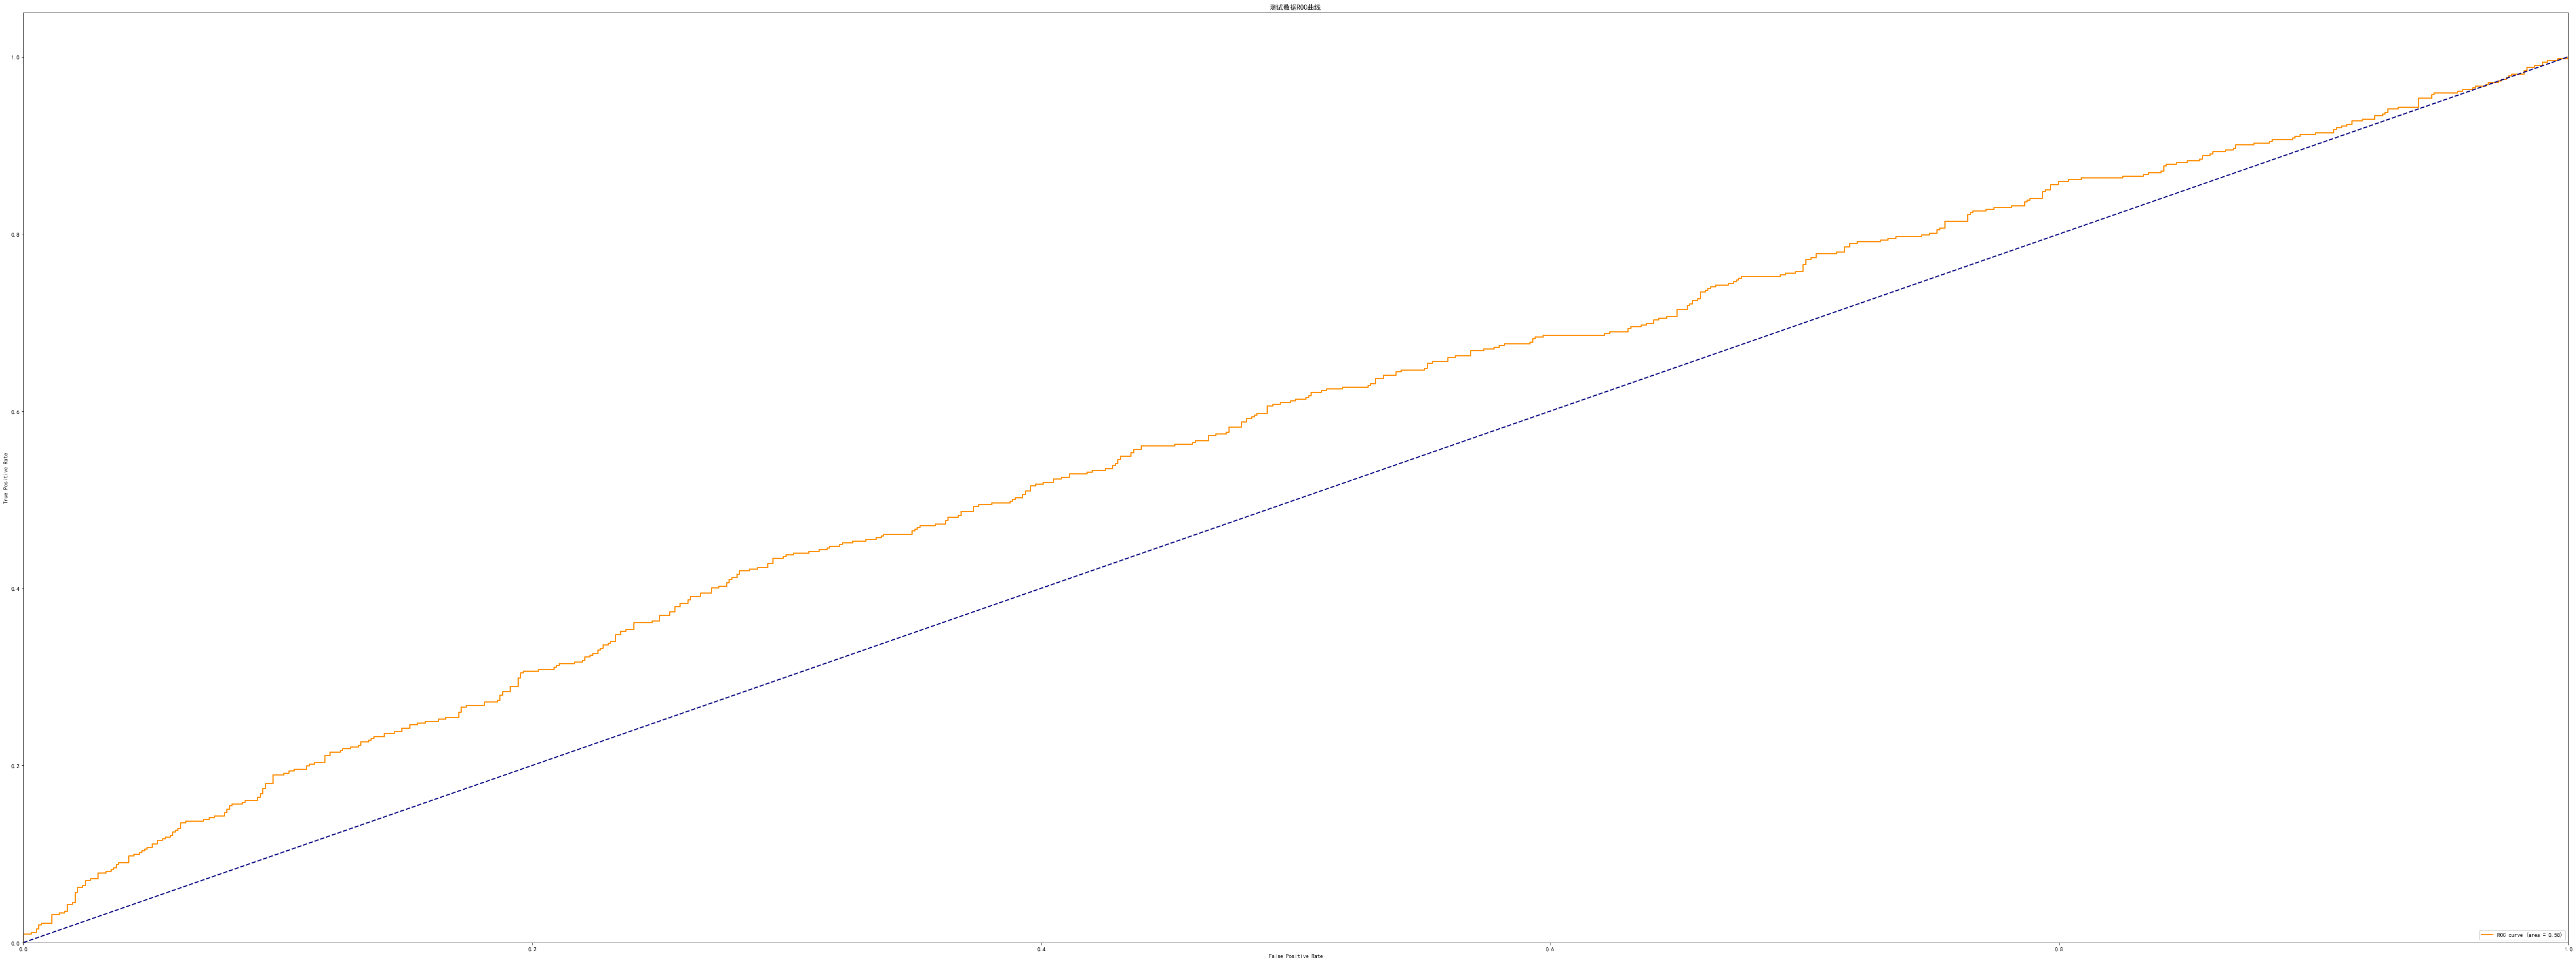

OUTLIERS :  166 INLIERS :  1334 Cluster-based Local Outlier Factor (CBLOF)
使用算法Feature Bagging 进行建模：

在训练数据集中:
Feature Bagging ROC:0.5007, precision @ rank n:0.3144

在测试数据集中:
Feature Bagging ROC:0.5013, precision @ rank n:0.3398


<Figure size 432x288 with 0 Axes>

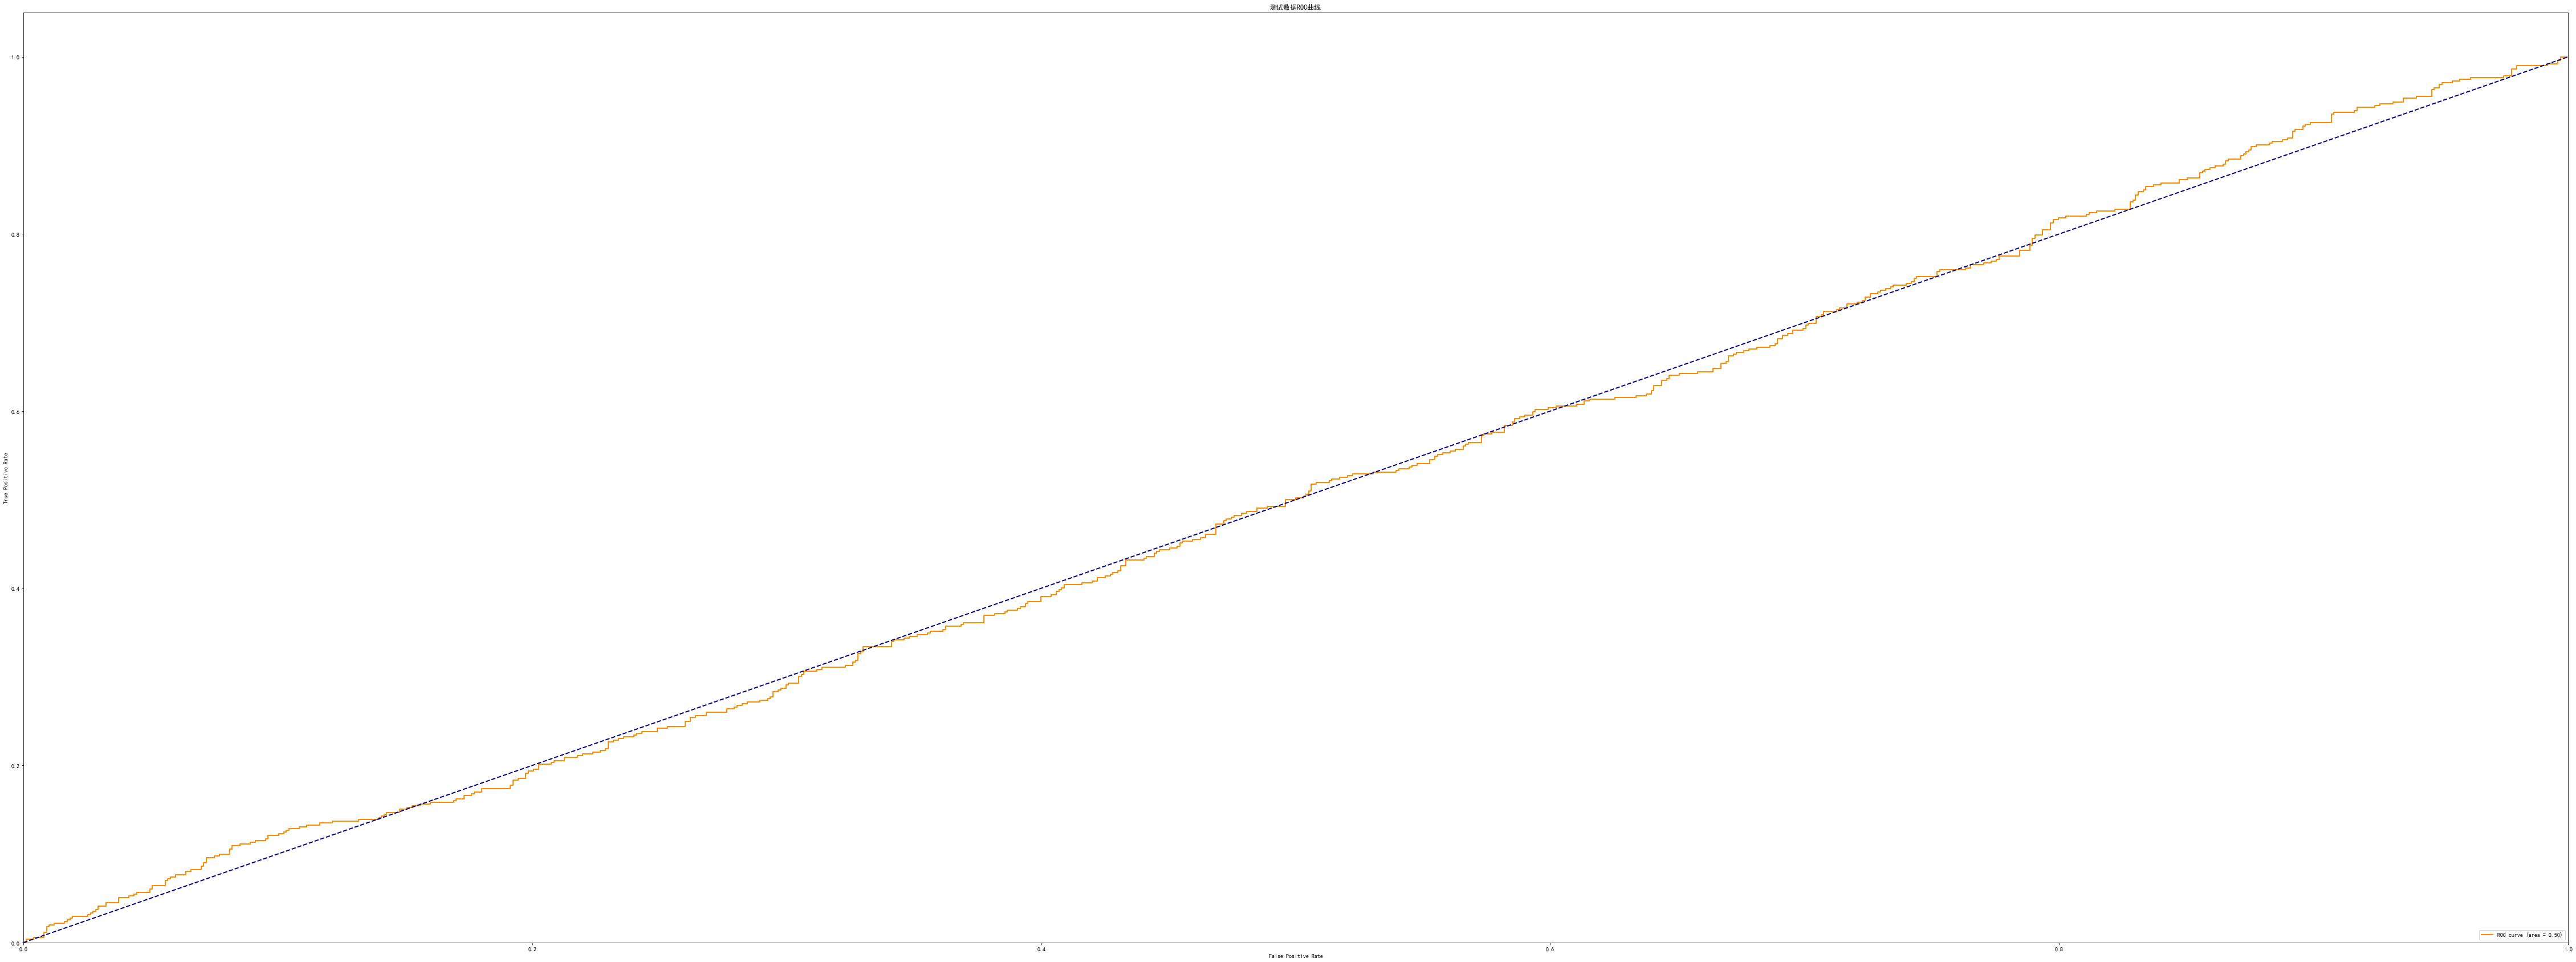

OUTLIERS :  160 INLIERS :  1340 Feature Bagging
使用算法Histogram-base Outlier Detection (HBOS) 进行建模：

在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4263, precision @ rank n:0.2934

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4394, precision @ rank n:0.3262


<Figure size 432x288 with 0 Axes>

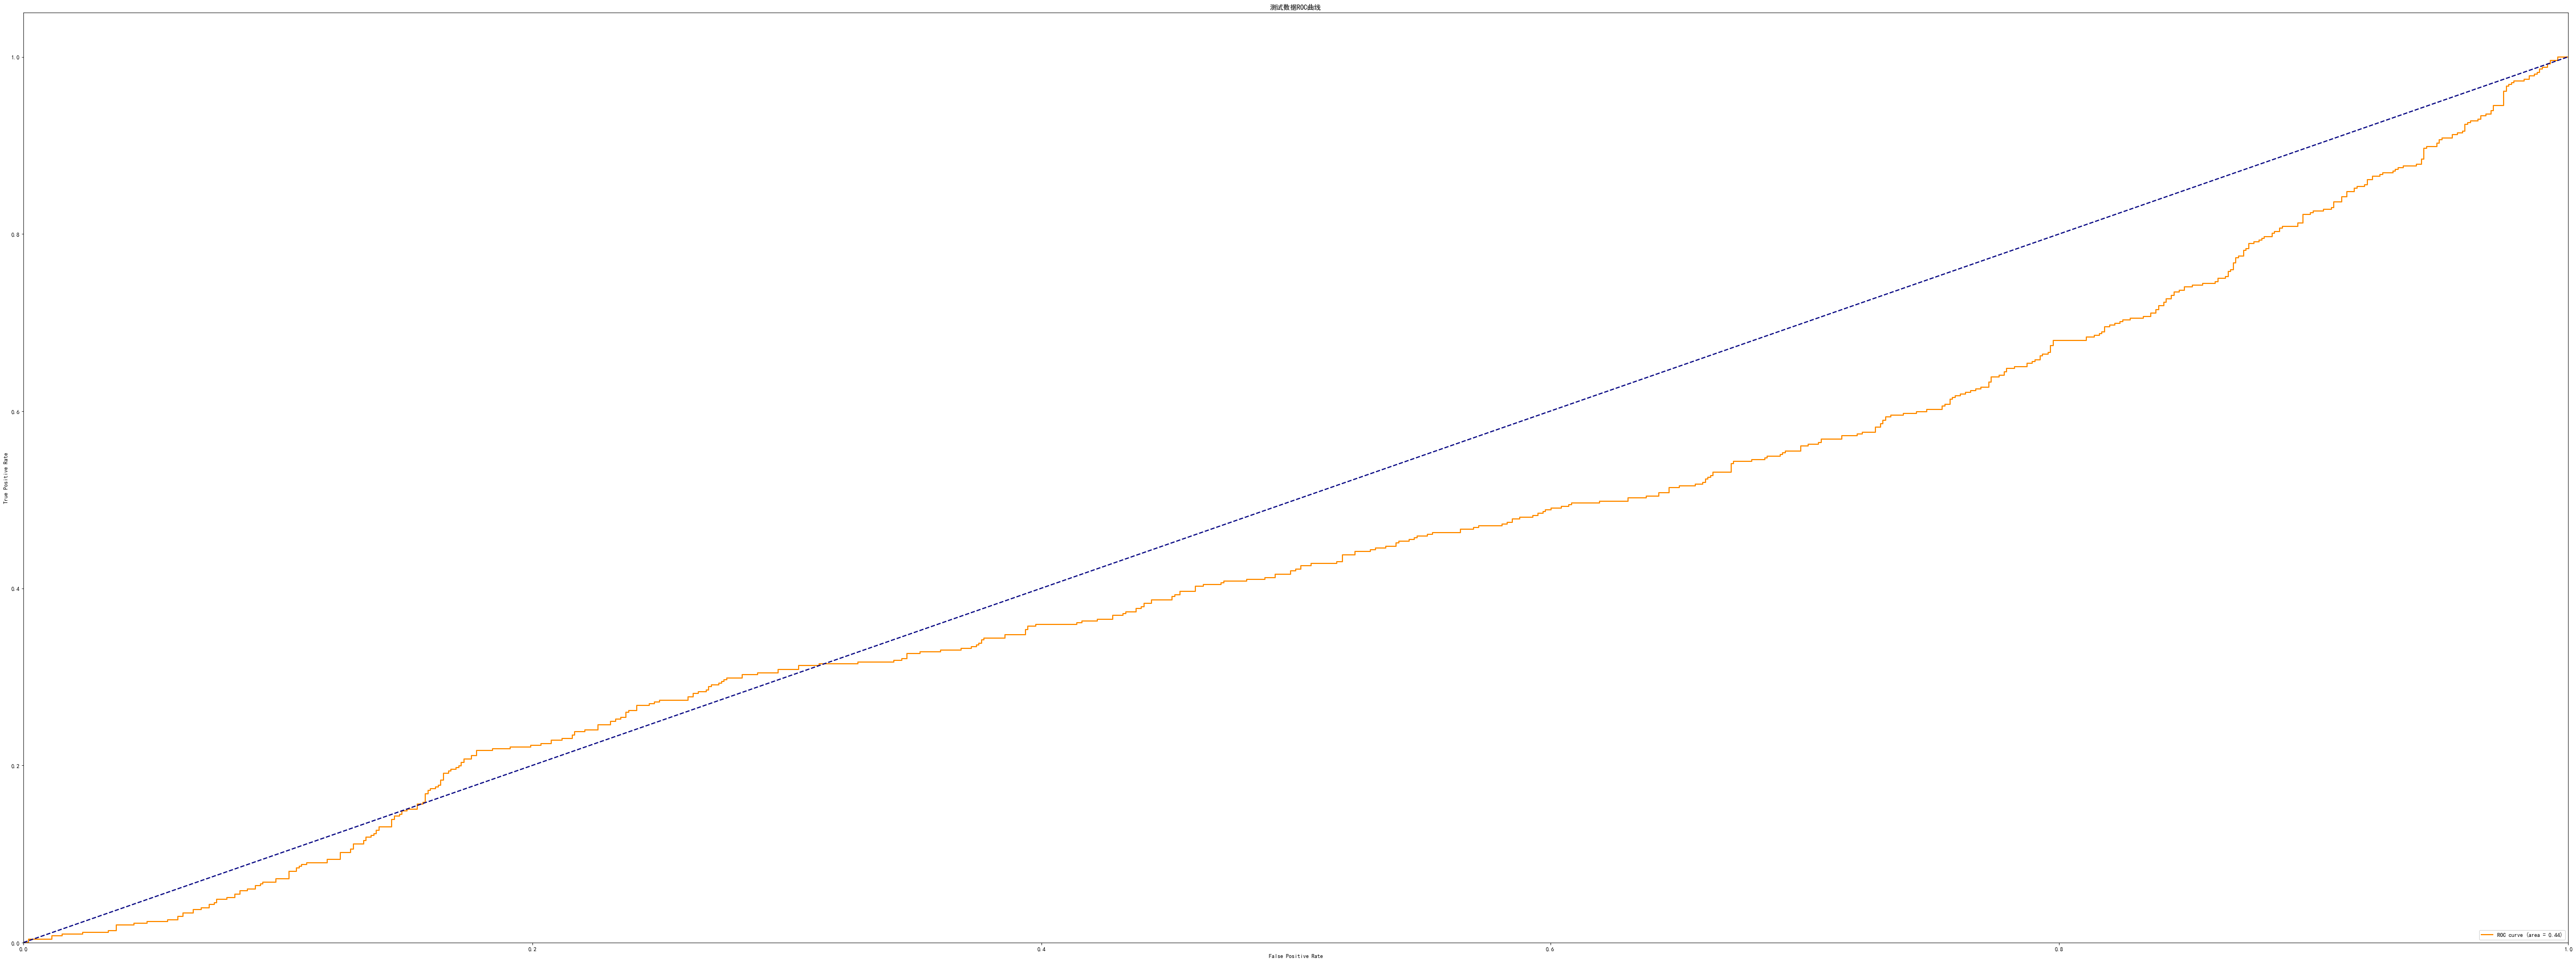

OUTLIERS :  155 INLIERS :  1345 Histogram-base Outlier Detection (HBOS)
使用算法Isolation Forest 进行建模：

在训练数据集中:
Isolation Forest ROC:0.5481, precision @ rank n:0.3773

在测试数据集中:
Isolation Forest ROC:0.5521, precision @ rank n:0.3926


<Figure size 432x288 with 0 Axes>

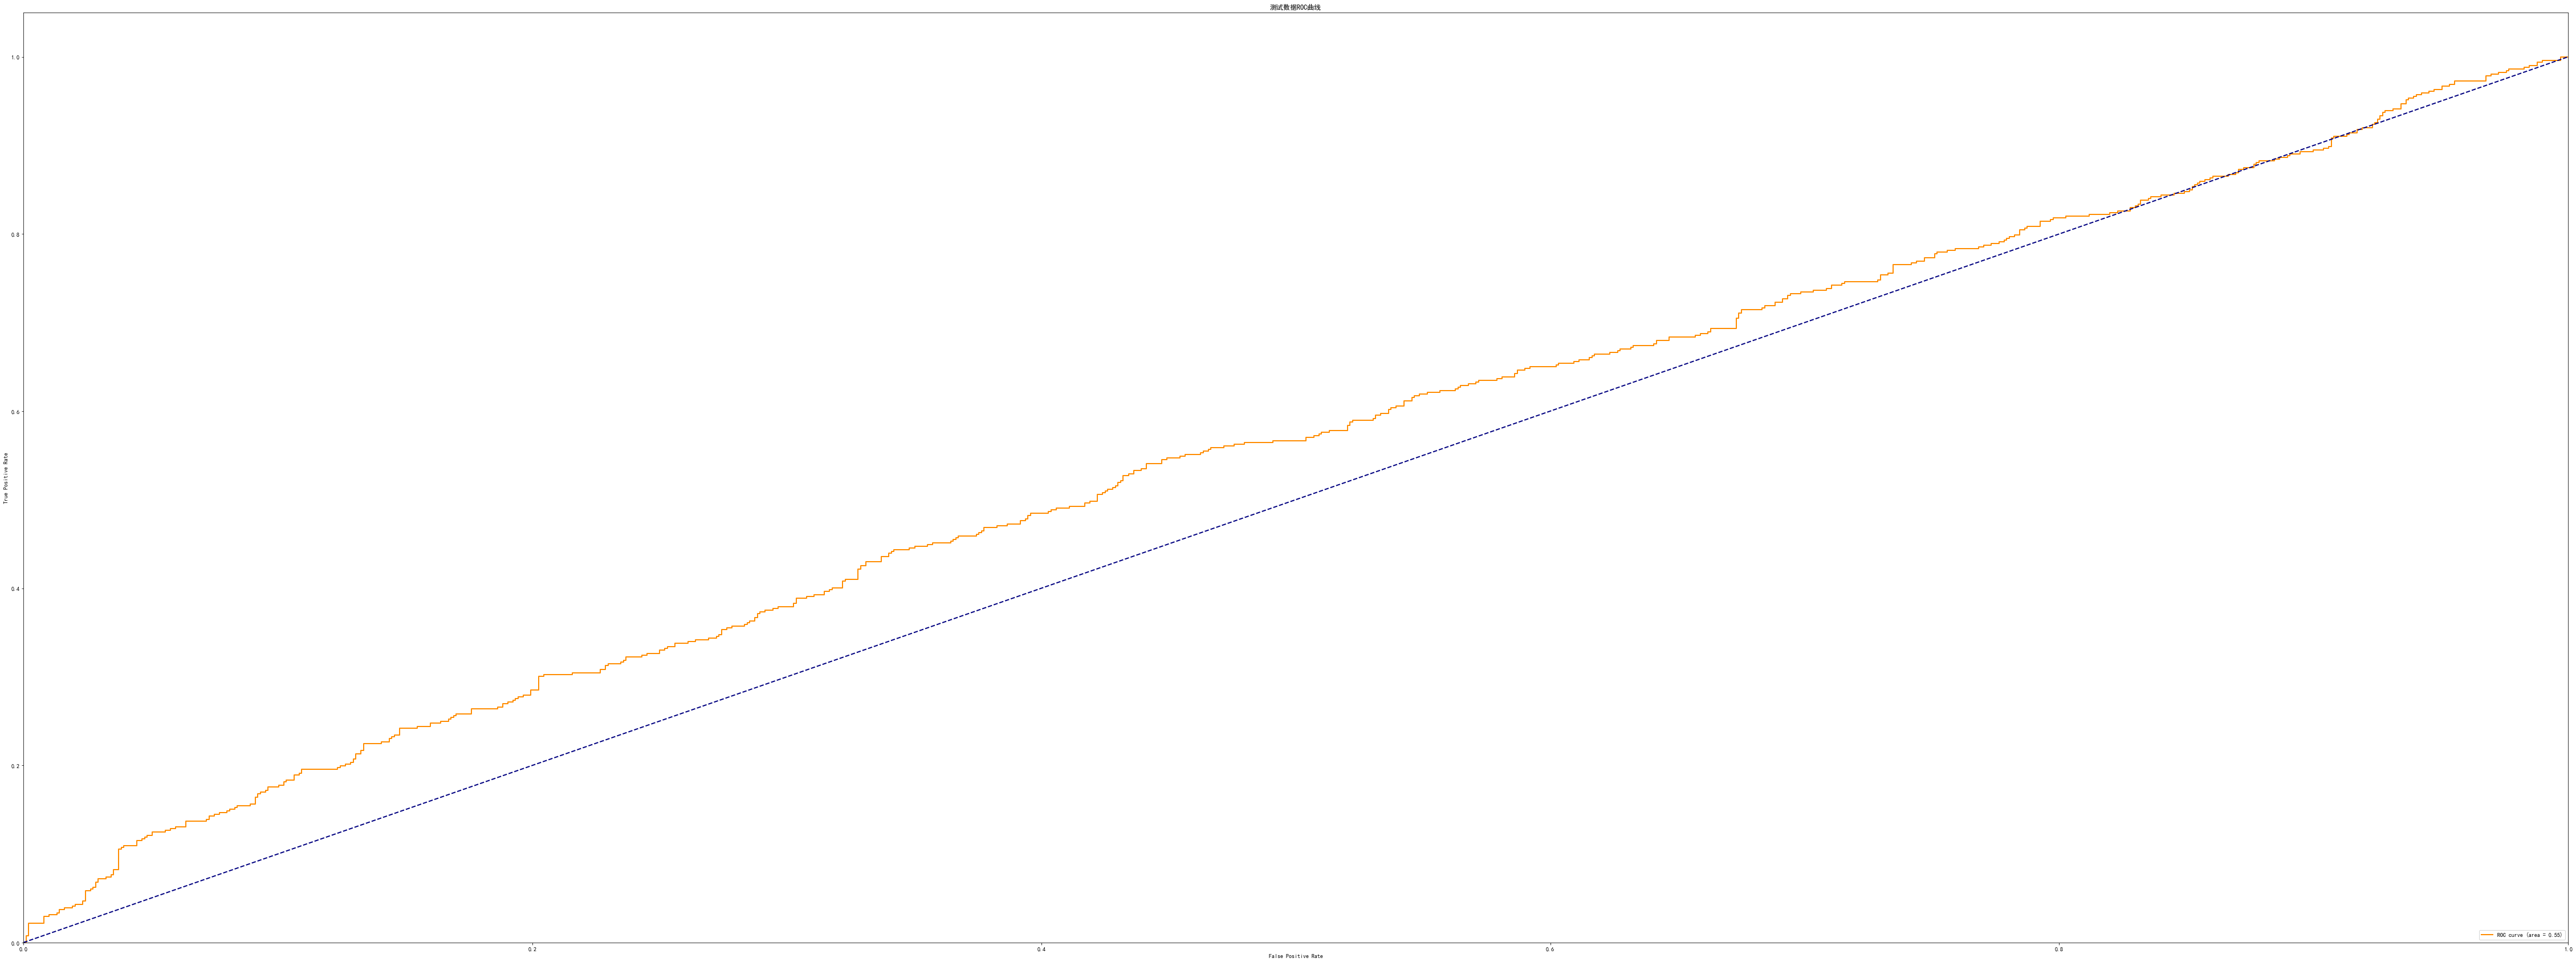

OUTLIERS :  156 INLIERS :  1344 Isolation Forest
使用算法K Nearest Neighbors (KNN) 进行建模：

在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5897, precision @ rank n:0.3939

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5873, precision @ rank n:0.4062


<Figure size 432x288 with 0 Axes>

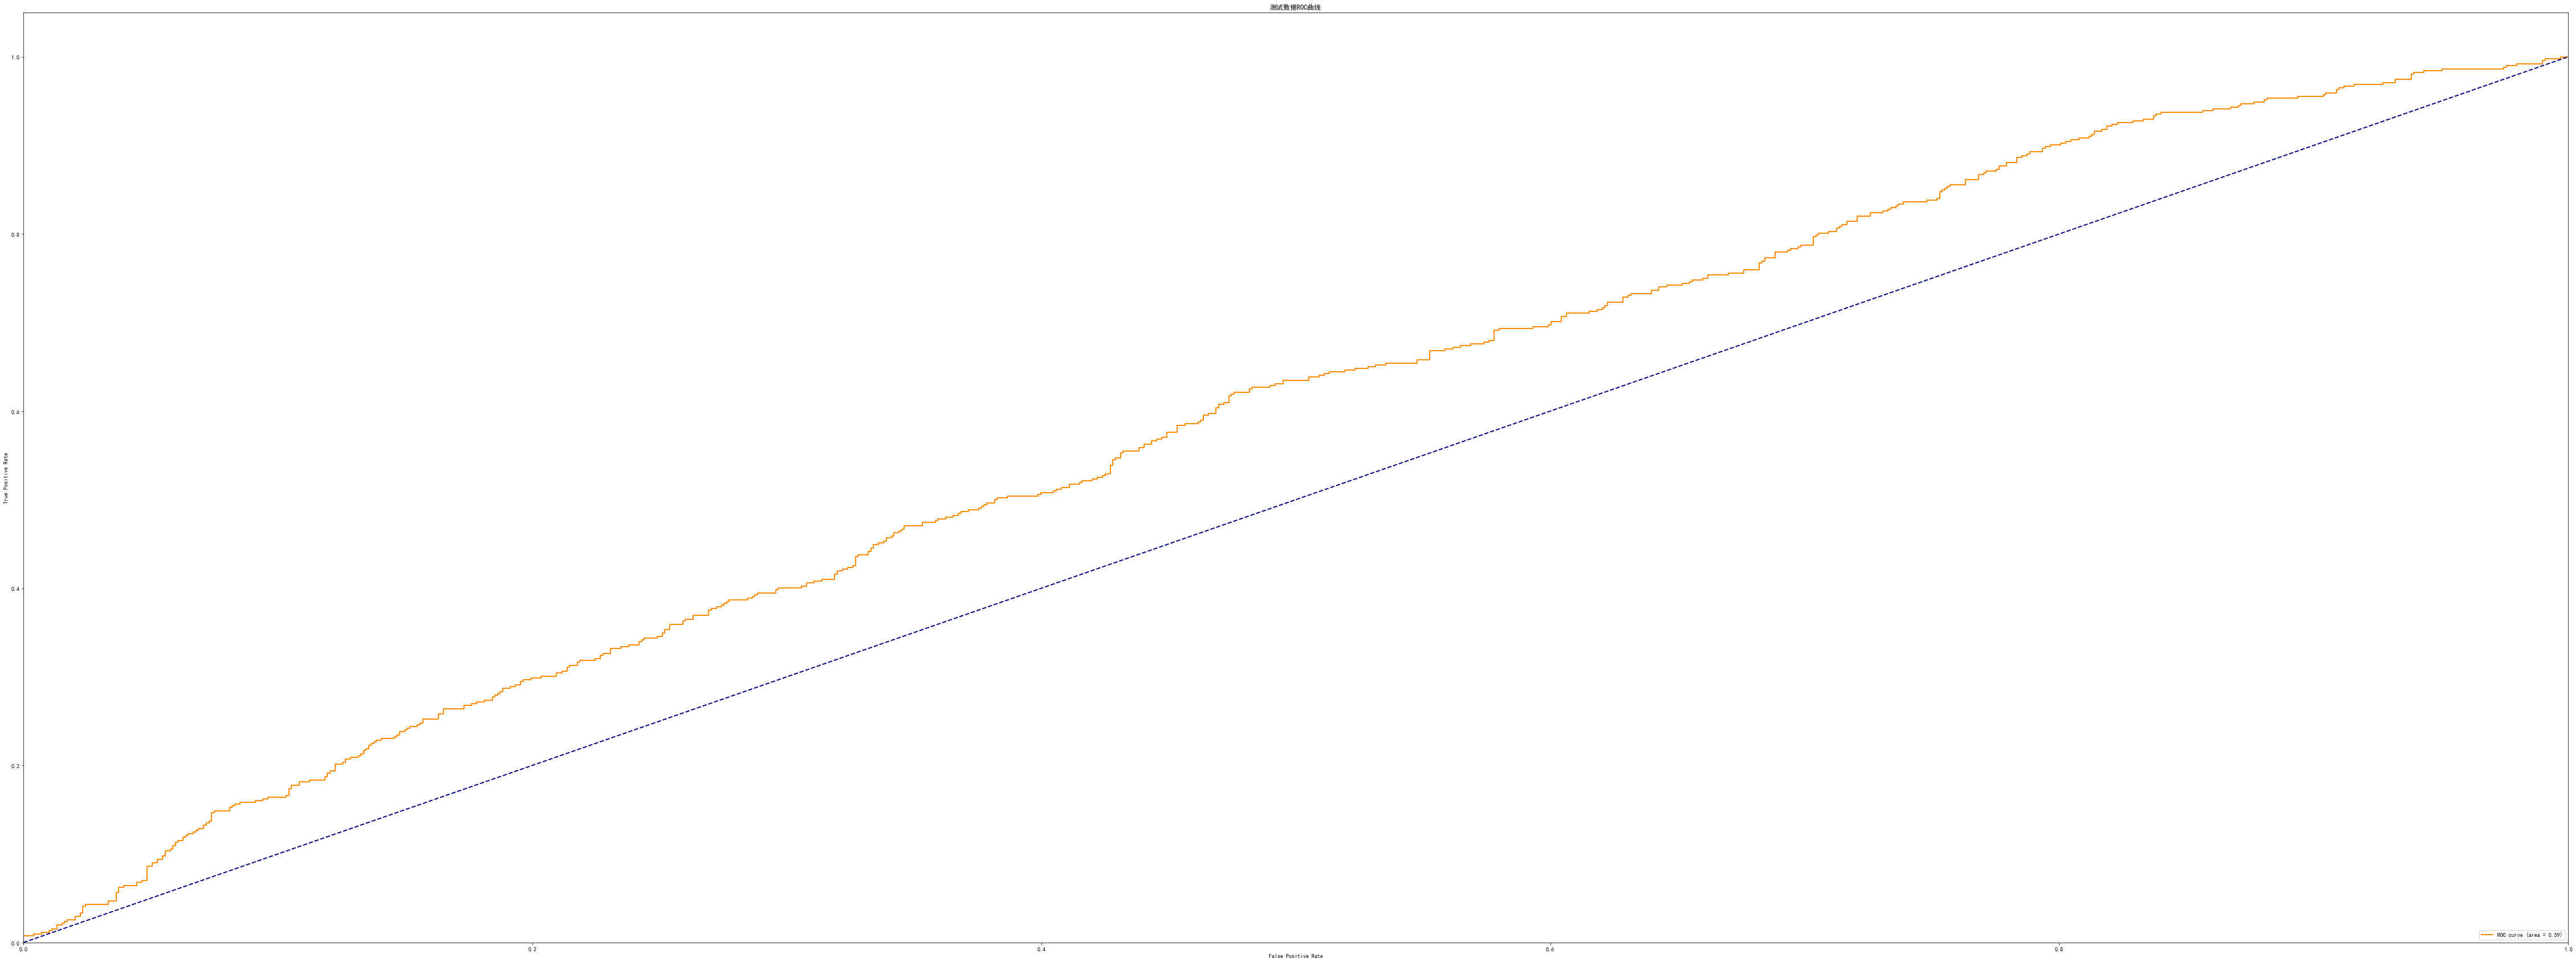

OUTLIERS :  167 INLIERS :  1333 K Nearest Neighbors (KNN)
使用算法Average KNN 进行建模：

在训练数据集中:
Average KNN ROC:0.5592, precision @ rank n:0.3651

在测试数据集中:
Average KNN ROC:0.558, precision @ rank n:0.3887


<Figure size 432x288 with 0 Axes>

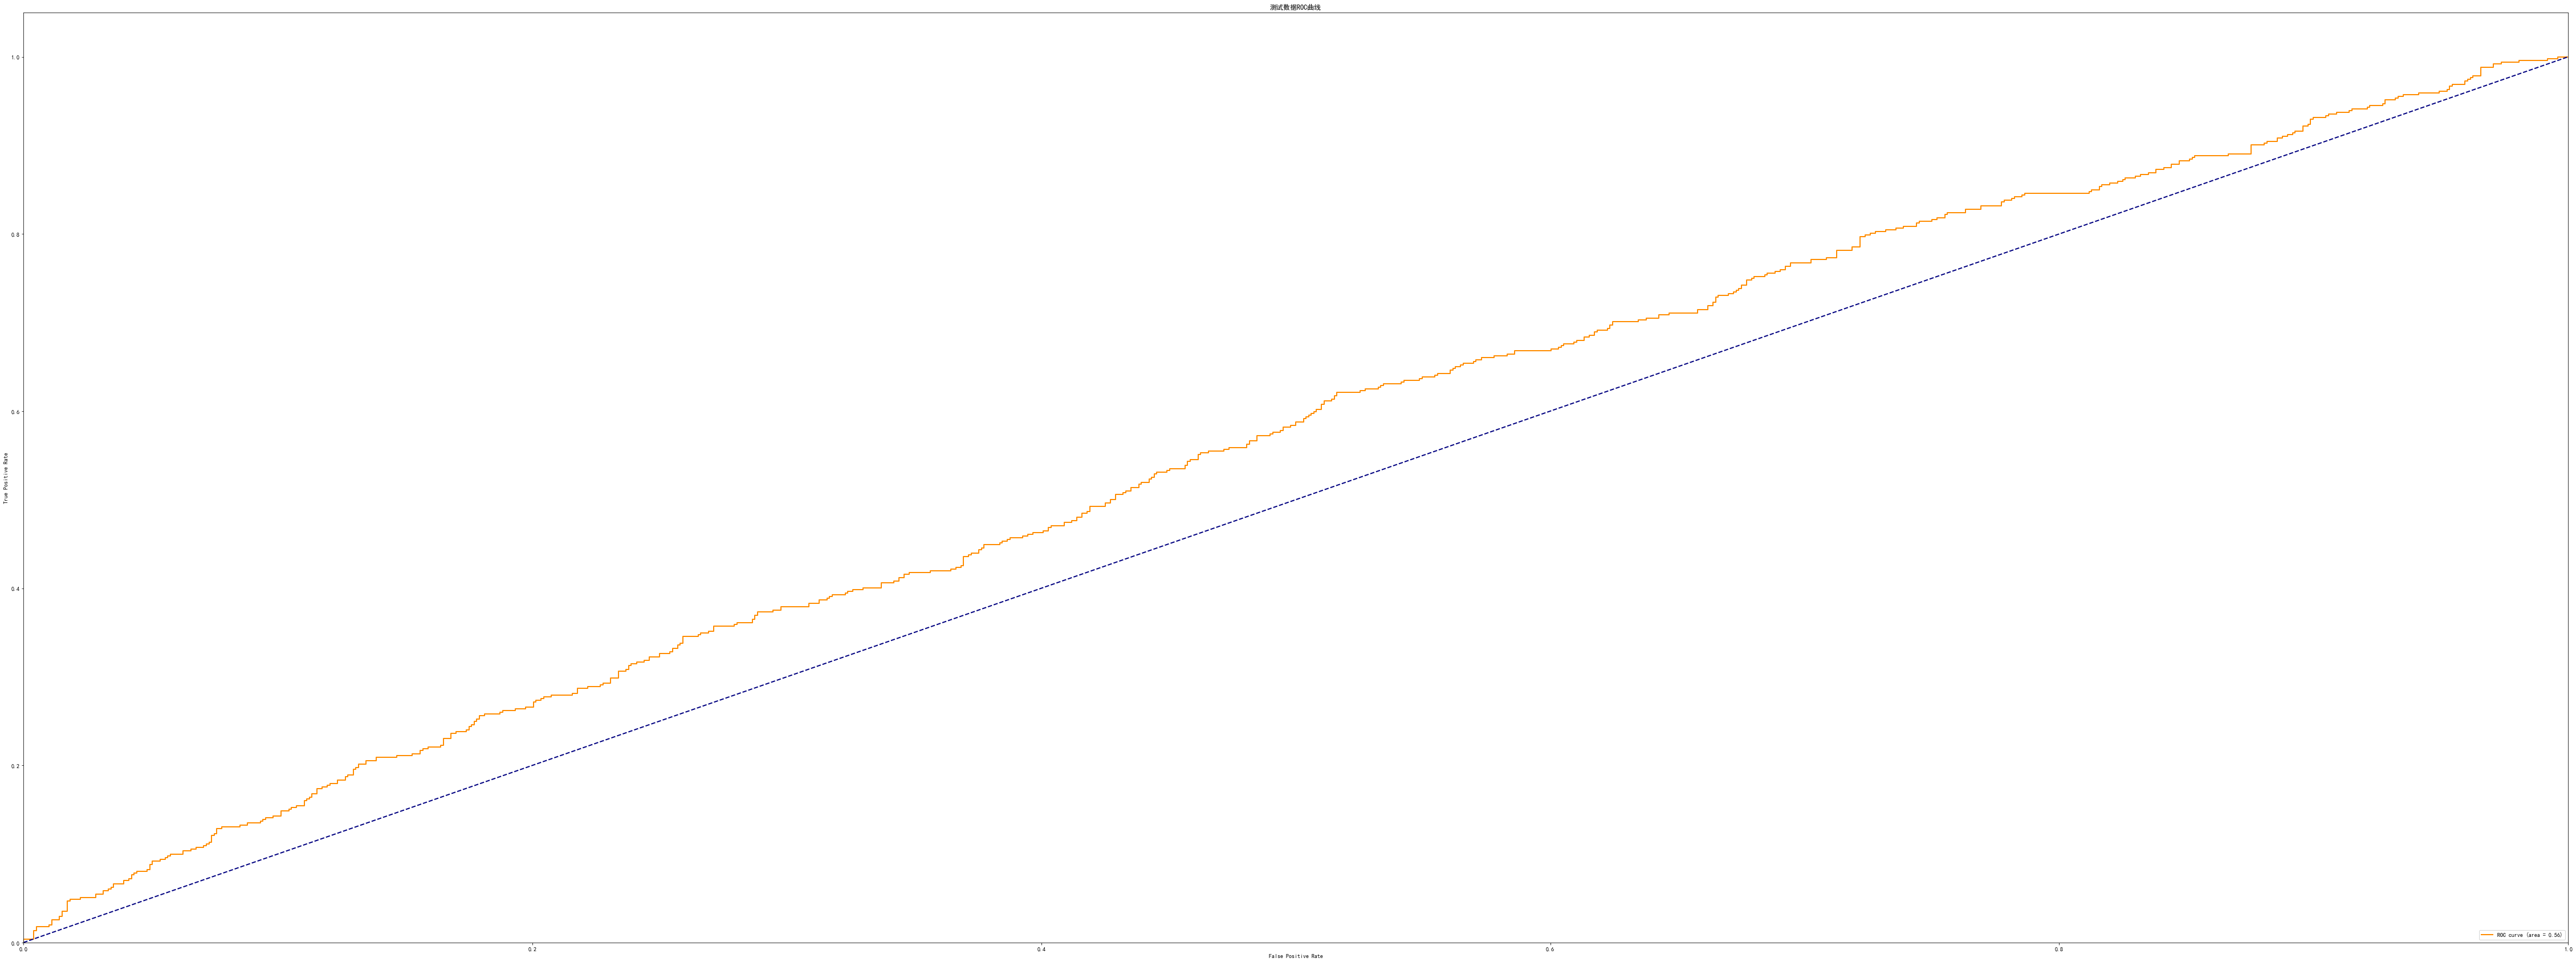

OUTLIERS :  165 INLIERS :  1335 Average KNN
使用算法Local Outlier Factor (LOF) 进行建模：

在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5408, precision @ rank n:0.338

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5385, precision @ rank n:0.3477


<Figure size 432x288 with 0 Axes>

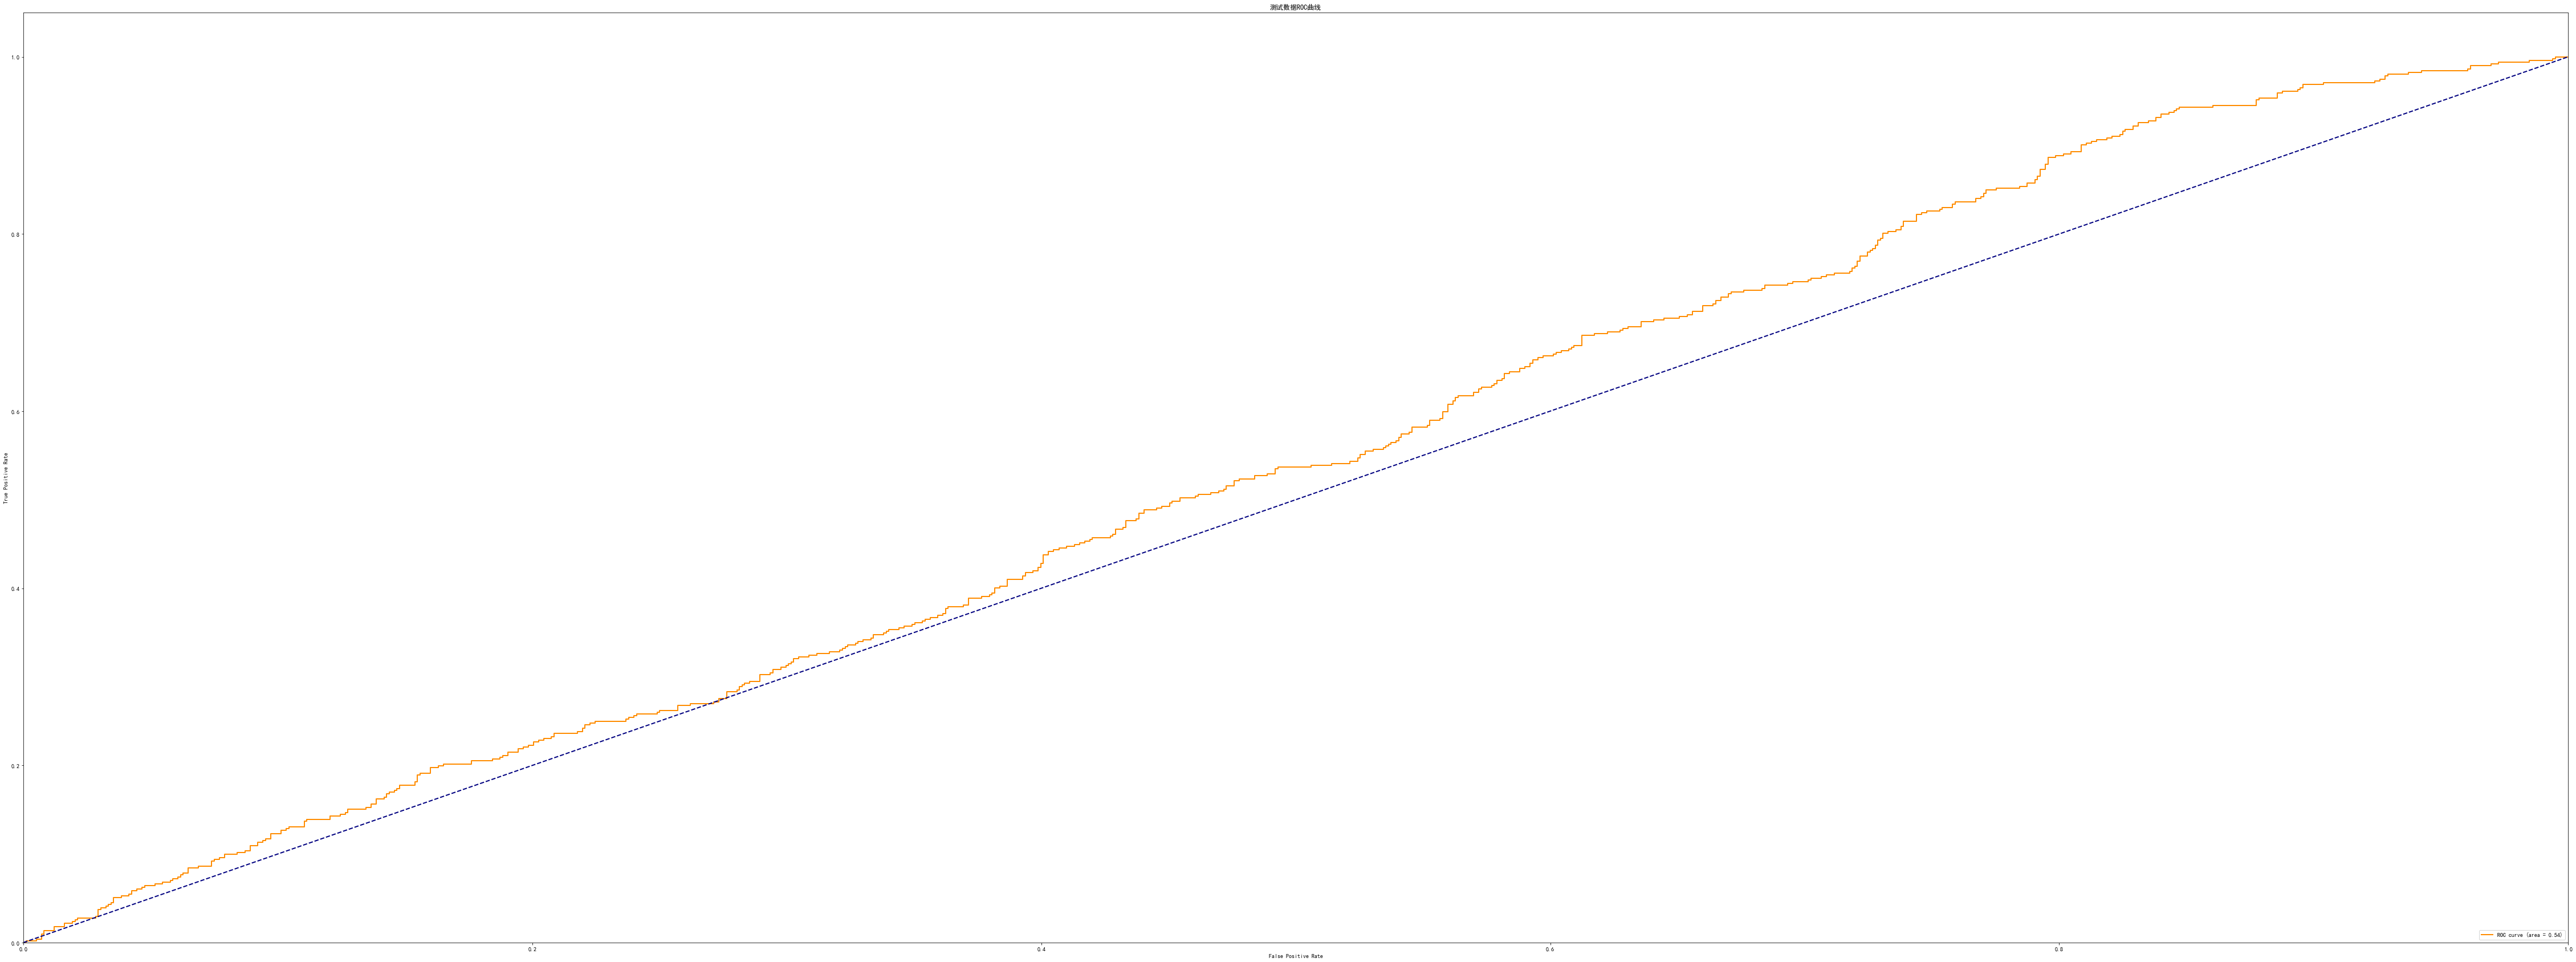

OUTLIERS :  157 INLIERS :  1343 Local Outlier Factor (LOF)
使用算法Connectivity-Based Outlier Factor (COF) 进行建模：

在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5408, precision @ rank n:0.338

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5385, precision @ rank n:0.3477


<Figure size 432x288 with 0 Axes>

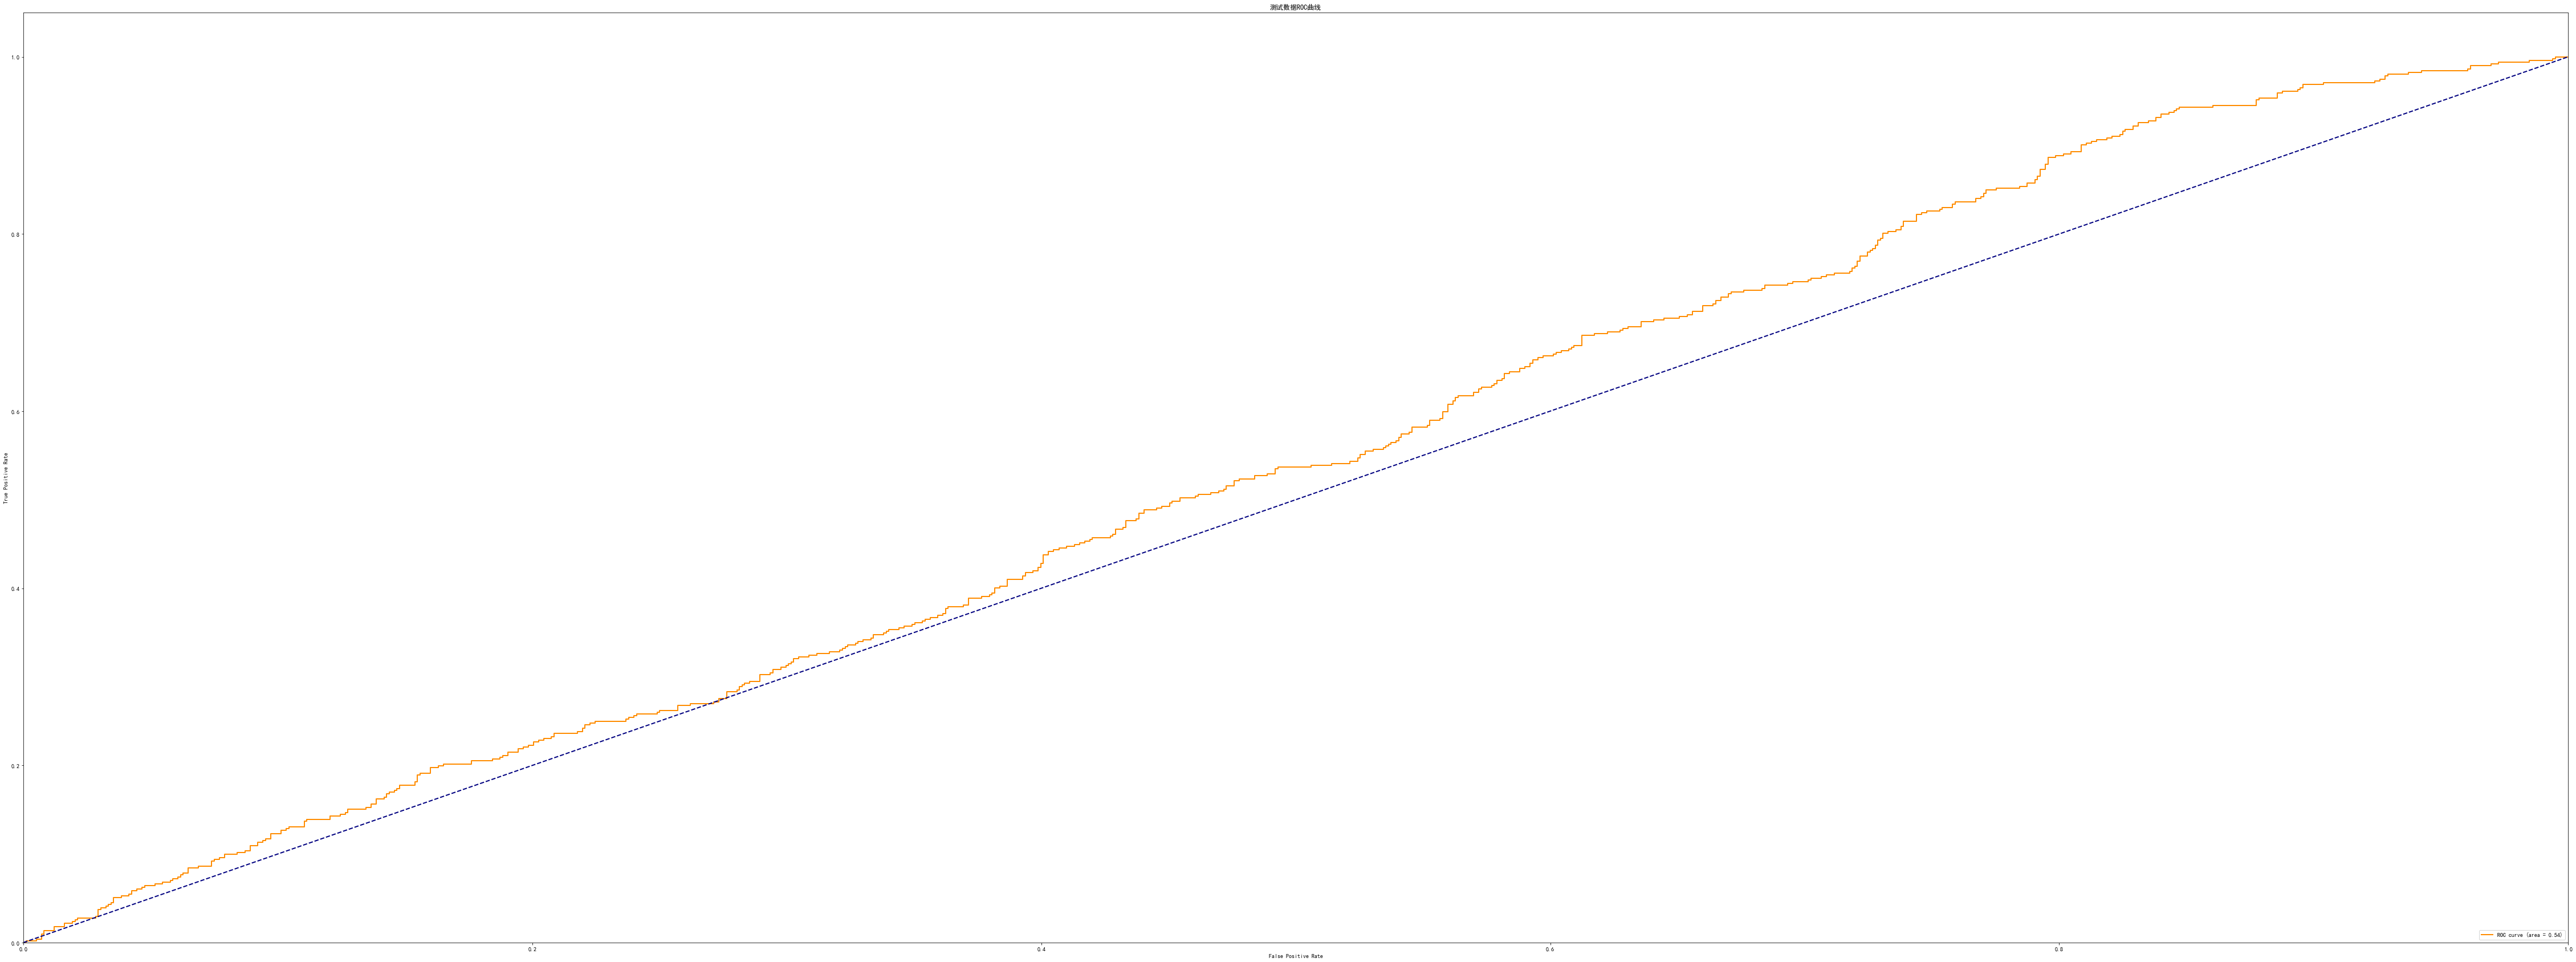

OUTLIERS :  157 INLIERS :  1343 Connectivity-Based Outlier Factor (COF)
使用算法Principal Component Analysis Outlier Detector (PCA) 进行建模：

在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5273, precision @ rank n:0.3738

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.538, precision @ rank n:0.3887


<Figure size 432x288 with 0 Axes>

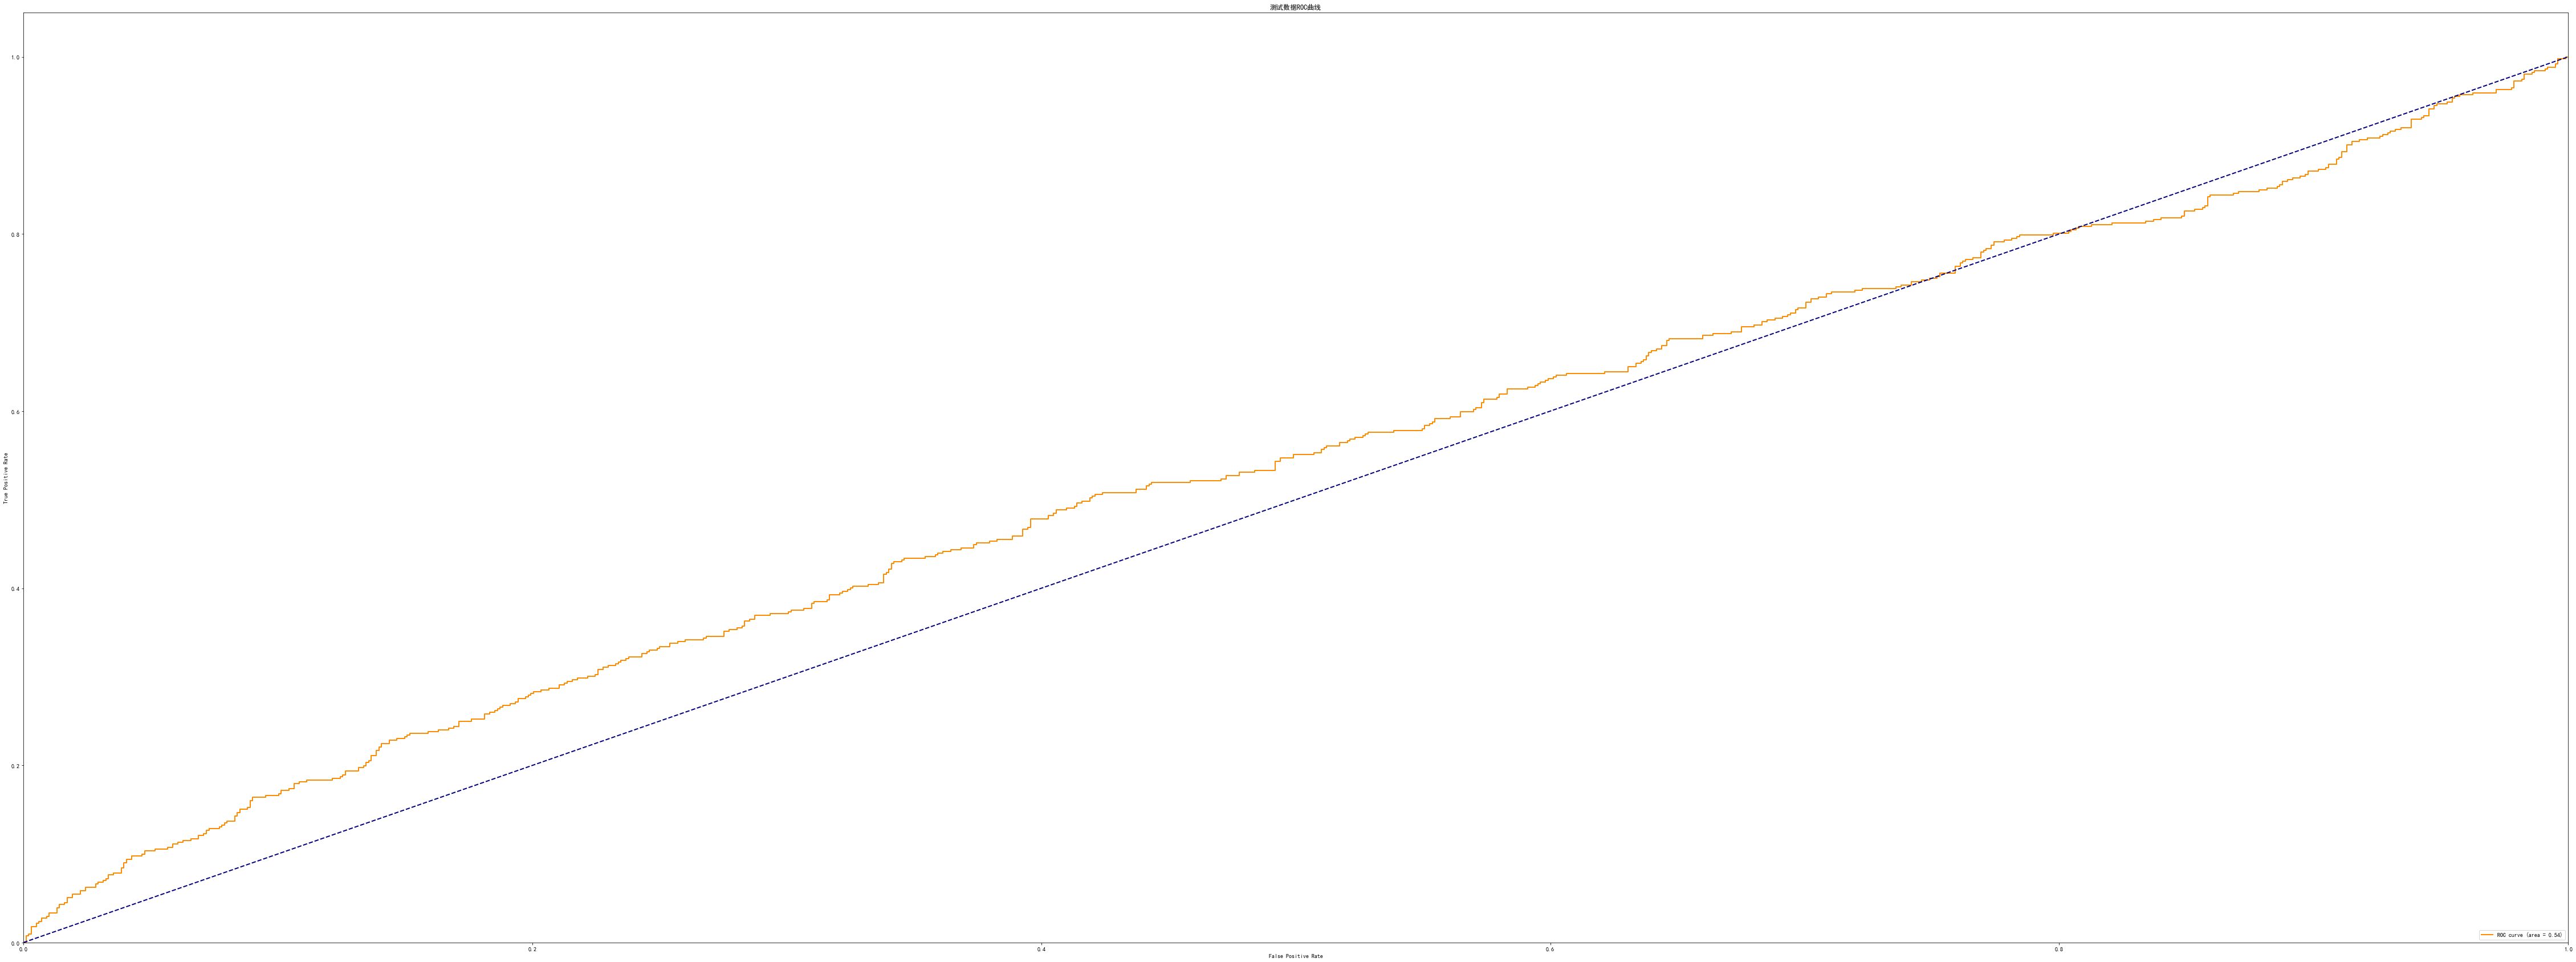

OUTLIERS :  173 INLIERS :  1327 Principal Component Analysis Outlier Detector (PCA)


In [24]:
# 对数据集进行划分,划分为测试数据集和训练集
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.3,random_state=0)
for i, (clf_name, clf) in enumerate(classifiers.items()): 
    print("使用算法"+clf_name+" 进行建模：")
    clf.fit(x_train)
    # 返回训练数据x_train上的异常标签和异常分值
    y_train_pred = clf.labels_  
    y_train_scores = clf.decision_scores_ 
    # 用训练好的clf来预测未知数据中的异常值
    # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
    y_test_pred = clf.predict(x_test) 
    #  返回未知数据上的异常值 (分值越大越异常)
    y_test_scores = clf.decision_function(x_test) 
    y_train_scores = y_train_scores.reshape(-1,1)
    y_test_scores = y_test_scores.reshape(-1,1)
    y_train_scores = y_train_scores.reshape(-1, 1)
    y_test_scores = y_test_scores.reshape(-1, 1)
    # if scores contain nan, change it to 0
    if np.isnan(y_train_scores).any():
         y_train_scores = np.nan_to_num(y_train_scores)
    if np.isnan(y_test_scores).any():
         y_test_scores = np.nan_to_num(y_test_scores)
    print("\n在训练数据集中:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\n在测试数据集中:")
    evaluate_print(clf_name, y_test, y_test_scores)
    # 绘制ROC图
    fpr,tpr,threshold = roc_curve(y_test, y_test_scores) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
    plt.figure()
    lw = 2
    plt.figure(figsize=(80,30))
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('测试数据ROC曲线')
    plt.legend(loc="lower right")
    plt.show()
    # 计算离群点的个数
    n_inliers = len(y_test_pred) - np.count_nonzero(y_test_pred)
    n_outliers = np.count_nonzero(y_test_pred == 1)

    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)

### 对包含noise的数据集进行处理

In [25]:
# 构造数据集
train_noise_DF = wave_noise_DF
train_noise_DF['ground.truth']=train_noise_DF['ground.truth'].map({'nominal': 0,'anomaly':1})

### 对数据集进行训练，并在测试数据集上进行预测

In [26]:
X = train_noise_DF[[ 'original.label', 'diff.score',
                    'V', 'V.1', 'V.2', 'V.3', 'V.4', 'V.5', 'V.6', 'V.7', 'V.8', 'V.9', 'V.10', 'V.11',
                    'V.12', 'V.13', 'V.14', 'V.15', 'V.16', 'V.17', 'V.18', 'V.19', 'V.20', 'noise..1', 
                    'noise..2', 'noise..3', 'noise..4', 'noise..5', 'noise..6', 'noise..7', 'noise..8',
                    'noise..9', 'noise..10', 'noise..11', 'noise..12', 'noise..13', 'noise..14', 'noise..15',
                    'noise..16', 'noise..17', 'noise..18', 'noise..19', 'noise..20', 'noise..21', 'noise..22', 
                    'noise..23', 'noise..24', 'noise..25', 'noise..26', 'noise..27', 'noise..28', 'noise..29', 
                    'noise..30', 'noise..31', 'noise..32', 'noise..33', 'noise..34', 'noise..35', 'noise..36', 
                    'noise..37', 'noise..38', 'noise..39', 'noise..40', 'noise..41', 'noise..42', 'noise..43',
                    'noise..44', 'noise..45', 'noise..46', 'noise..47', 'noise..48', 'noise..49', 'noise..50', 
                    'noise..51', 'noise..52', 'noise..53', 'noise..54', 'noise..55', 'noise..56', 'noise..57', 
                    'noise..58', 'noise..59', 'noise..60', 'noise..61', 'noise..62', 'noise..63']].values
Y = train_noise_DF['ground.truth'].values


使用算法Fast Angle-based Outlier Detector (F_ABOD) 进行建模：

在训练数据集中:
Fast Angle-based Outlier Detector (F_ABOD) ROC:0.5321, precision @ rank n:0.1443

在测试数据集中:
Fast Angle-based Outlier Detector (F_ABOD) ROC:0.5253, precision @ rank n:0.1429


<Figure size 432x288 with 0 Axes>

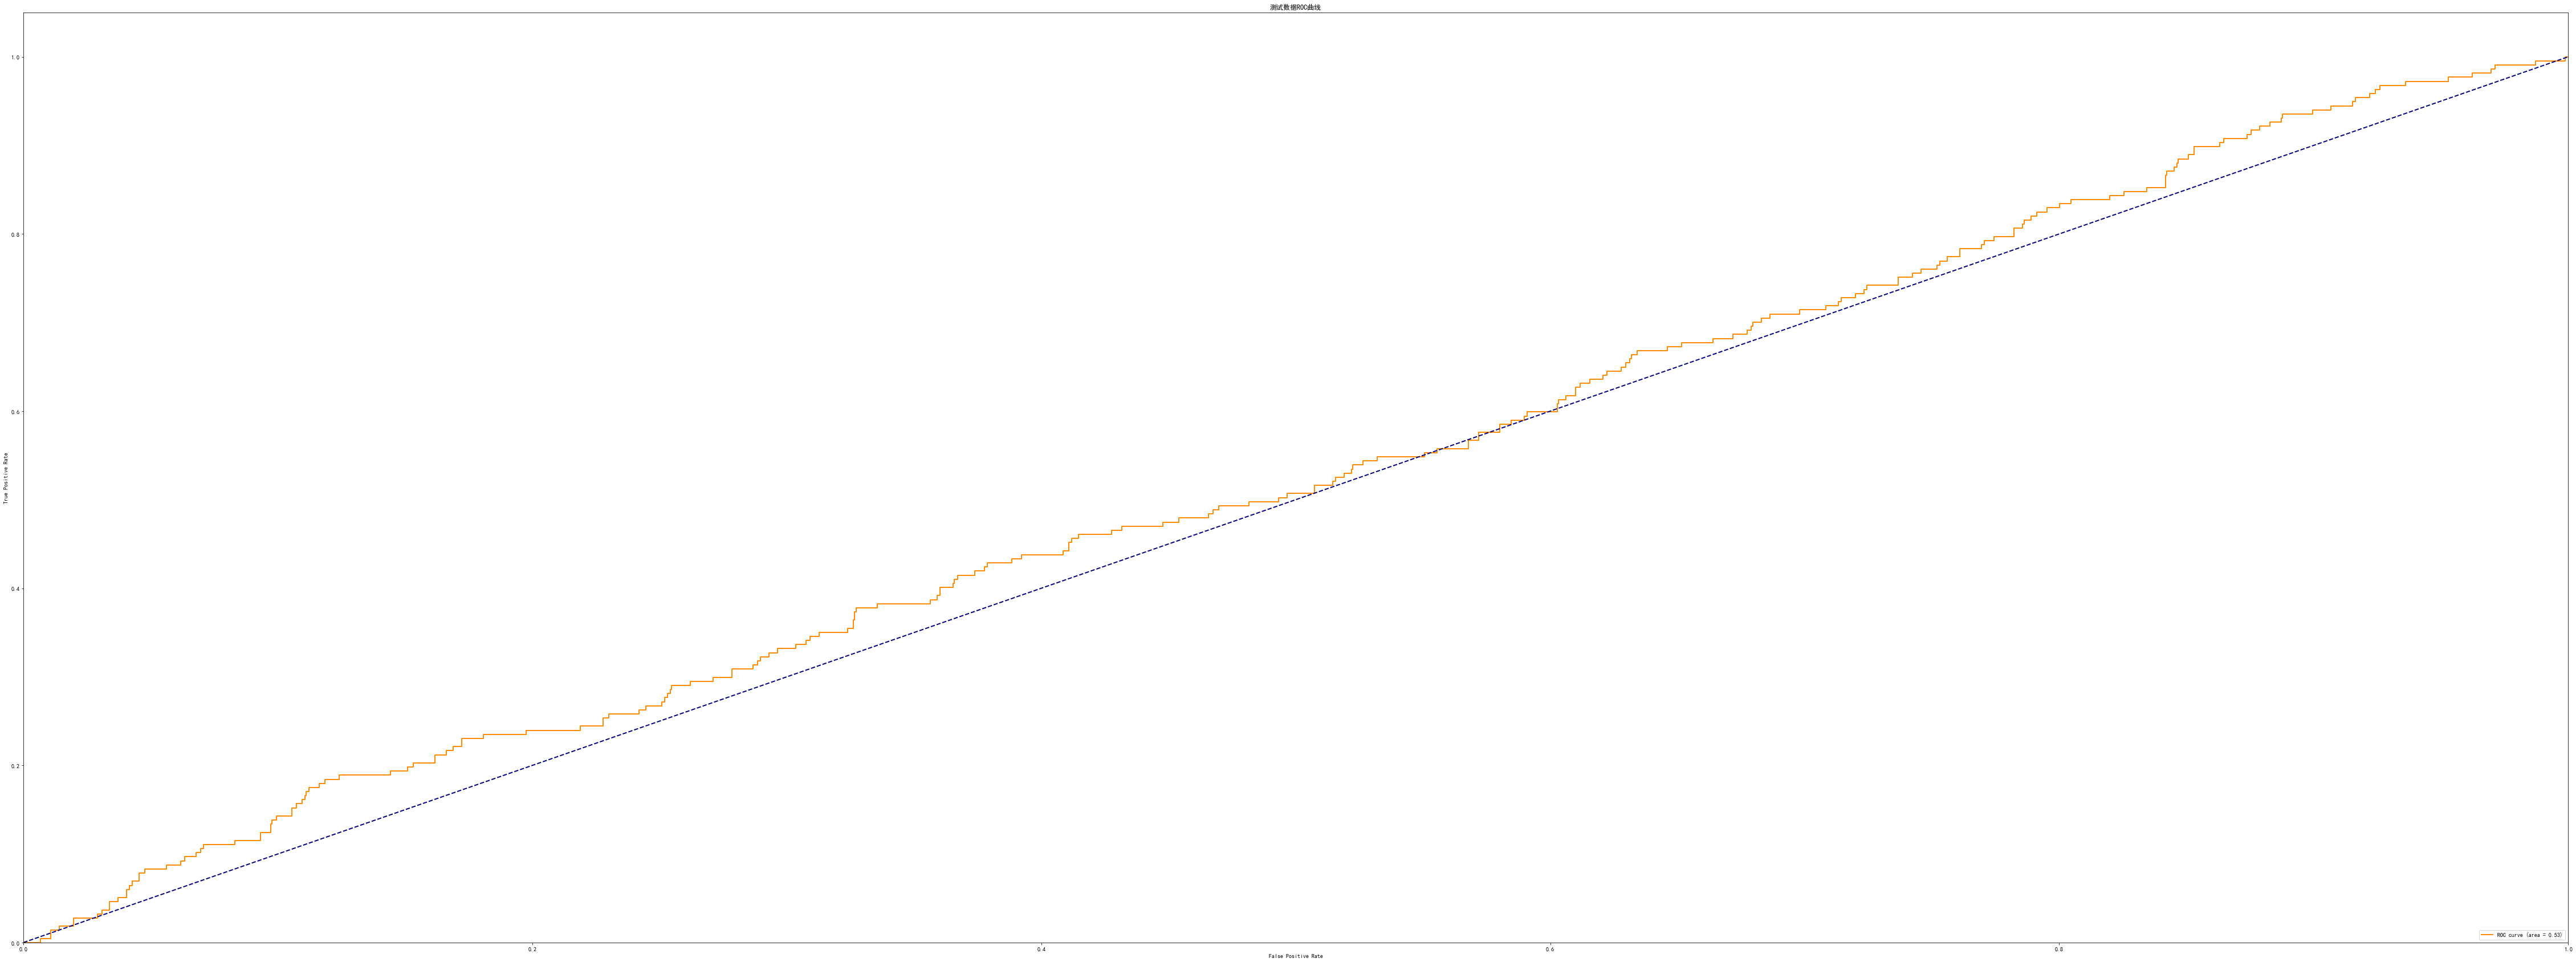

OUTLIERS :  212 INLIERS :  1787 Fast Angle-based Outlier Detector (F_ABOD)
使用算法Cluster-based Local Outlier Factor (CBLOF) 进行建模：

在训练数据集中:
Cluster-based Local Outlier Factor (CBLOF) ROC:0.6068, precision @ rank n:0.1646

在测试数据集中:
Cluster-based Local Outlier Factor (CBLOF) ROC:0.6053, precision @ rank n:0.1843


<Figure size 432x288 with 0 Axes>

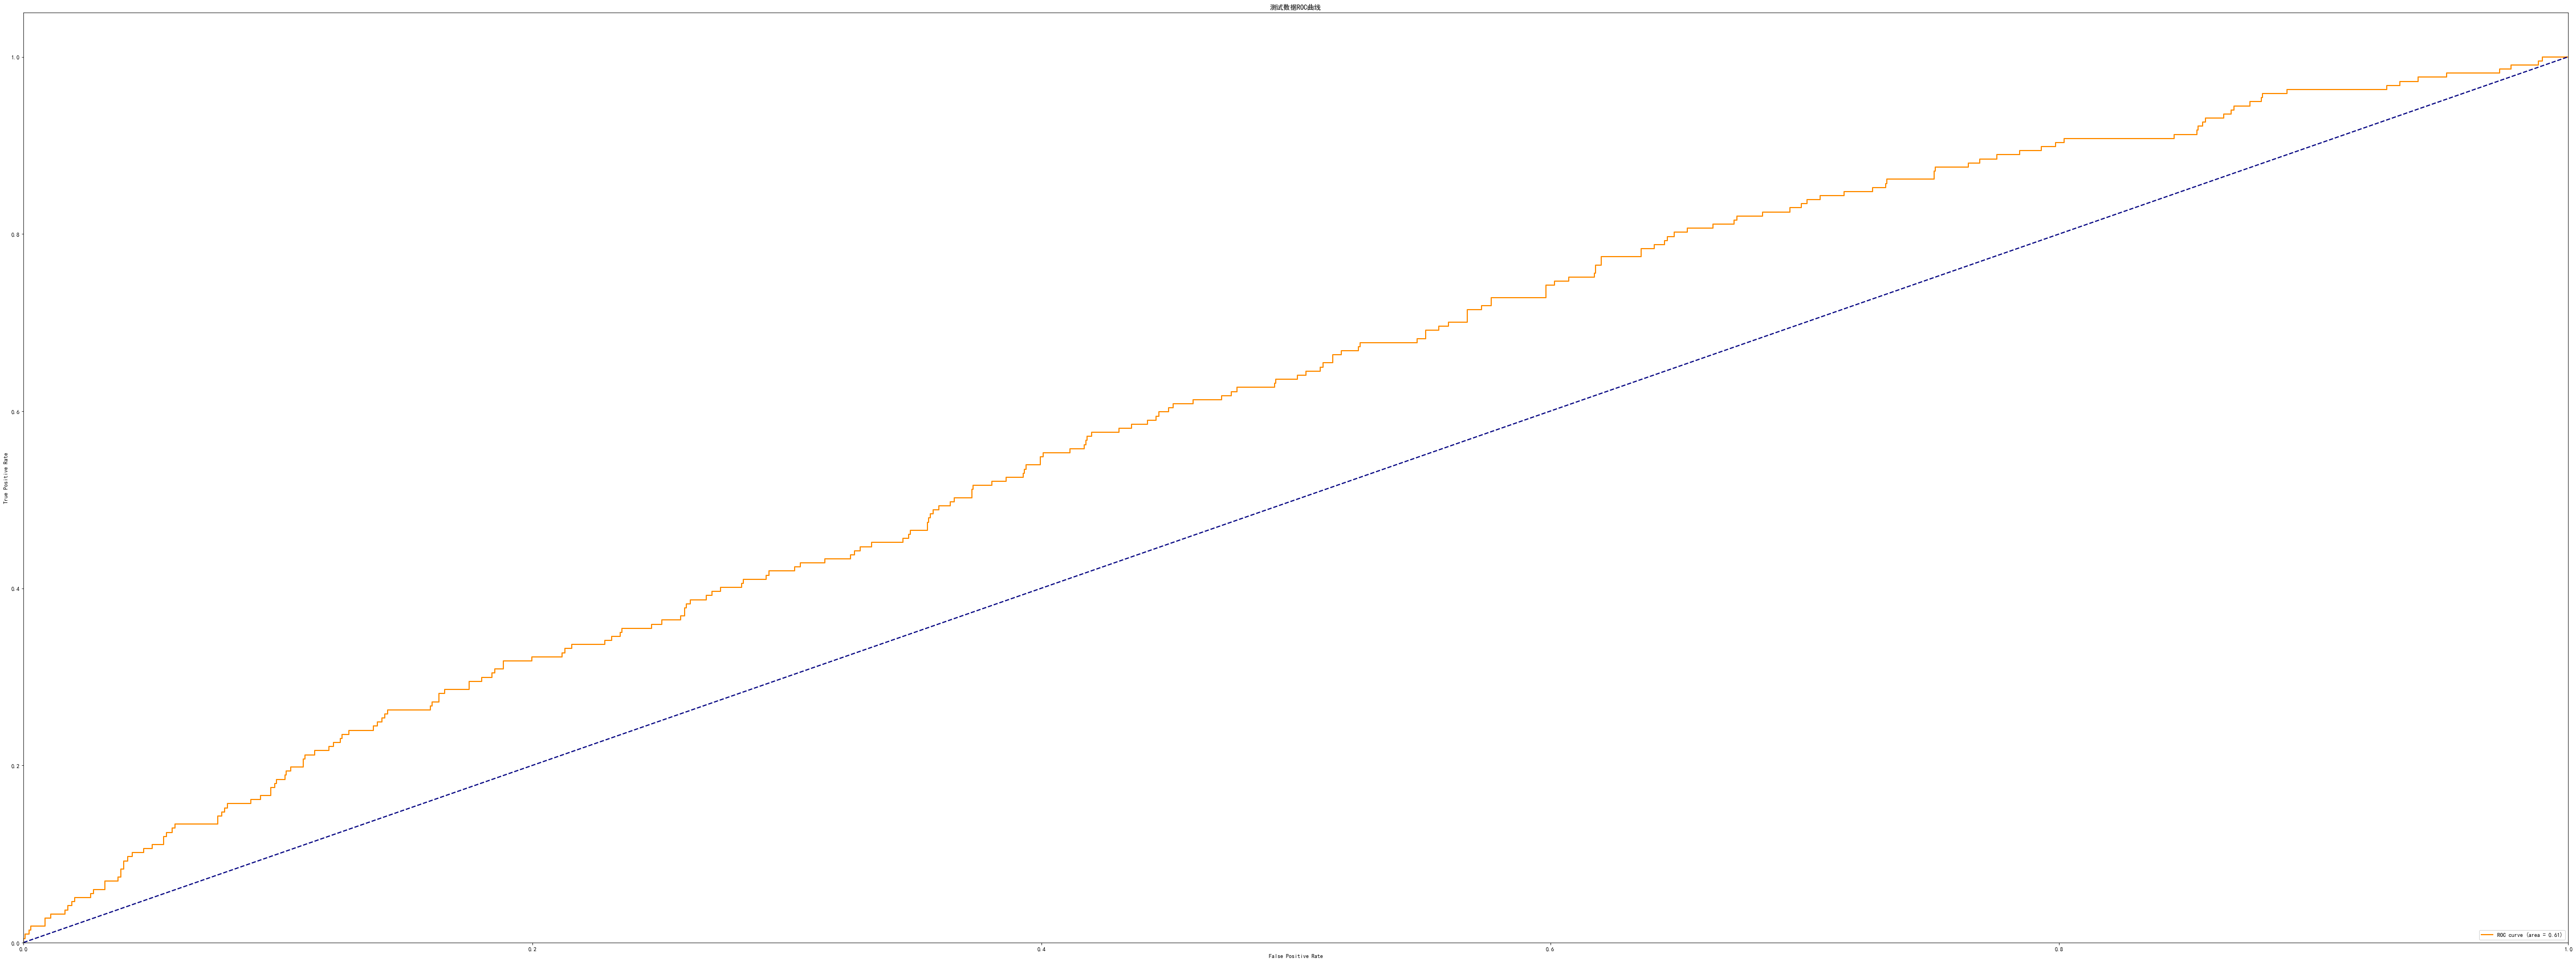

OUTLIERS :  222 INLIERS :  1777 Cluster-based Local Outlier Factor (CBLOF)
使用算法Feature Bagging 进行建模：

在训练数据集中:
Feature Bagging ROC:0.5983, precision @ rank n:0.1606

在测试数据集中:
Feature Bagging ROC:0.6026, precision @ rank n:0.1567


<Figure size 432x288 with 0 Axes>

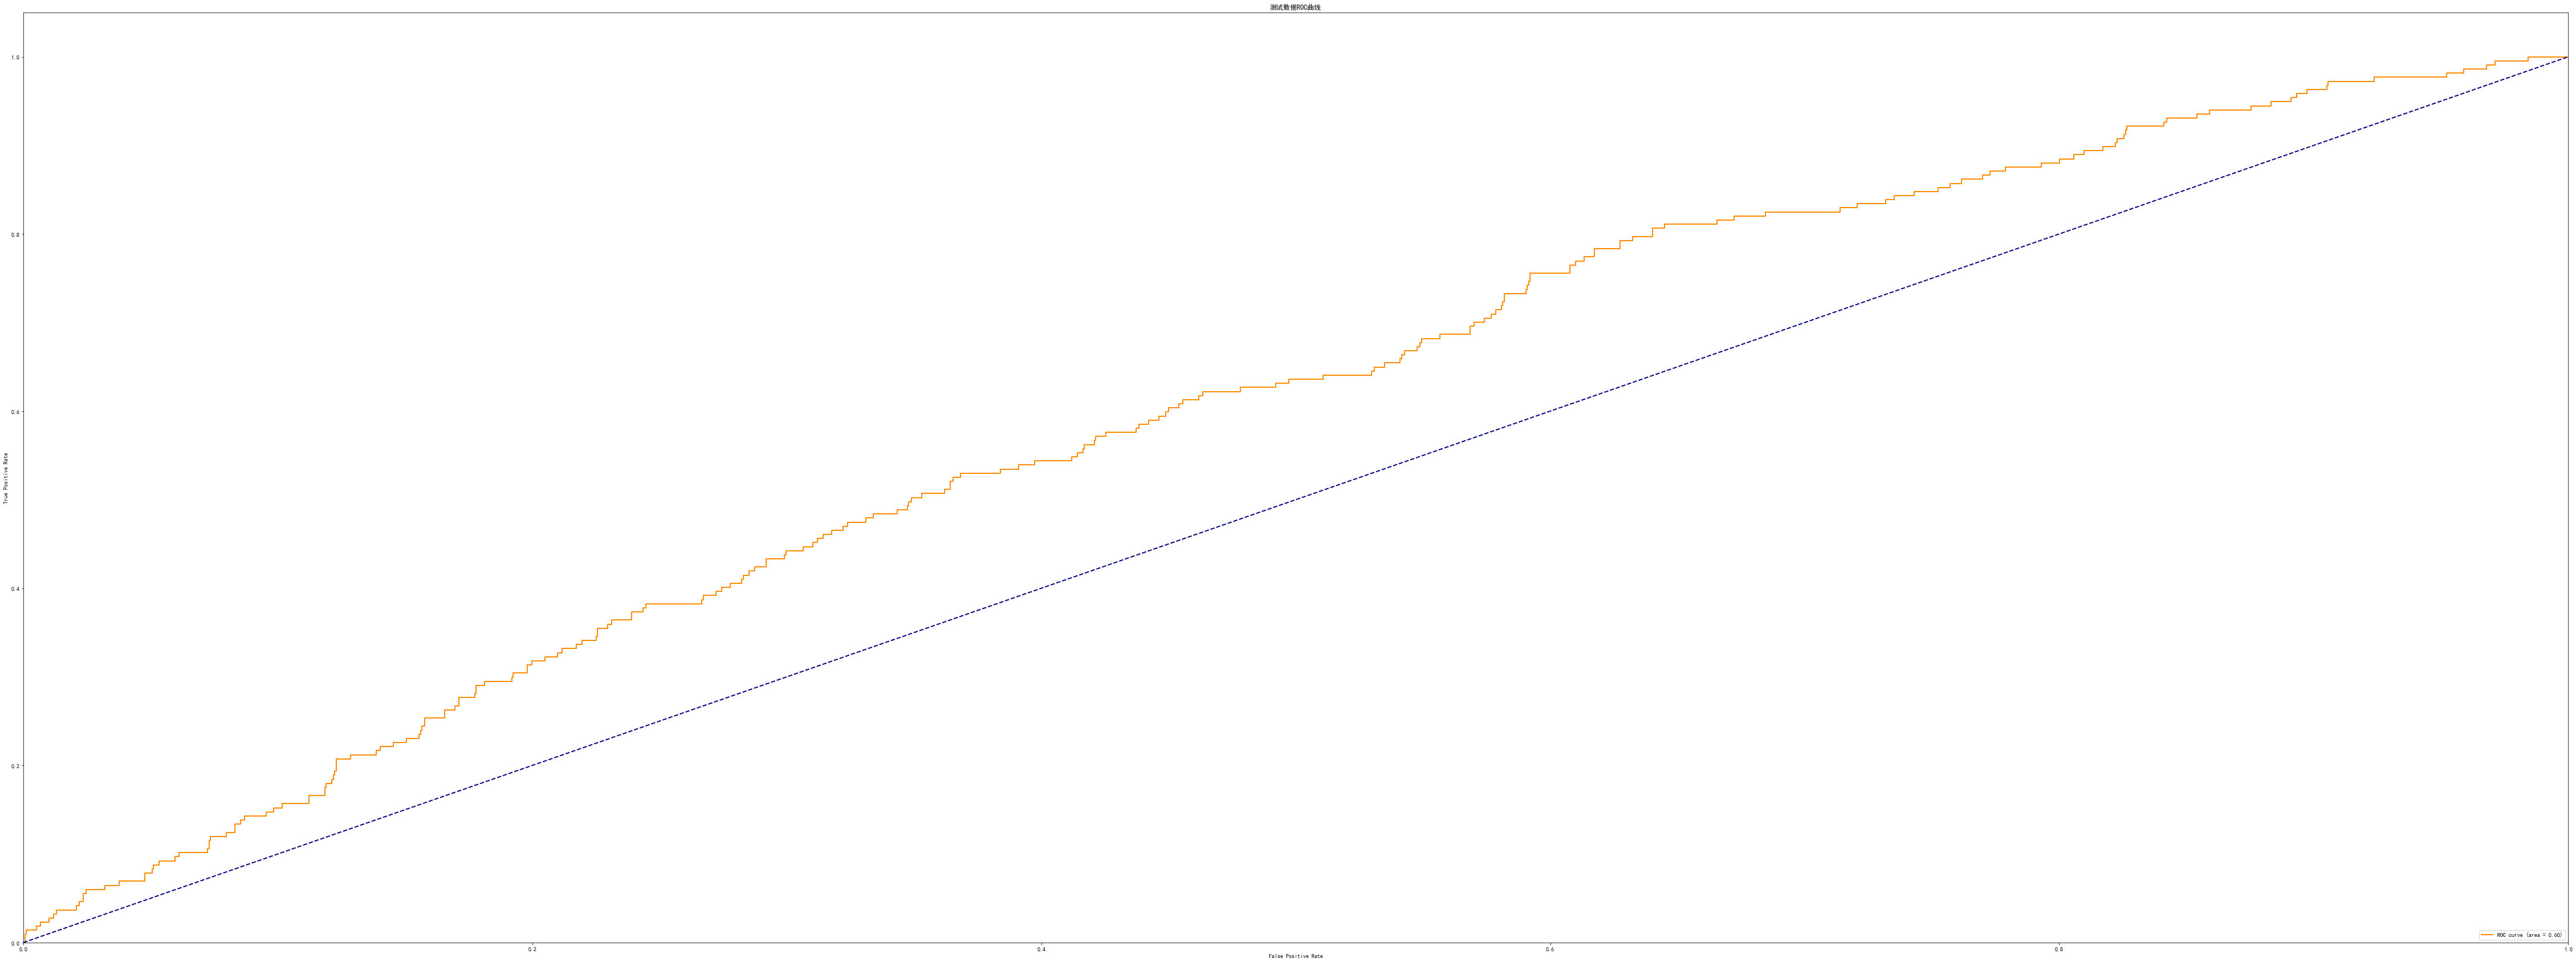

OUTLIERS :  203 INLIERS :  1796 Feature Bagging
使用算法Histogram-base Outlier Detection (HBOS) 进行建模：

在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.6106, precision @ rank n:0.1545

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.6244, precision @ rank n:0.1659


<Figure size 432x288 with 0 Axes>

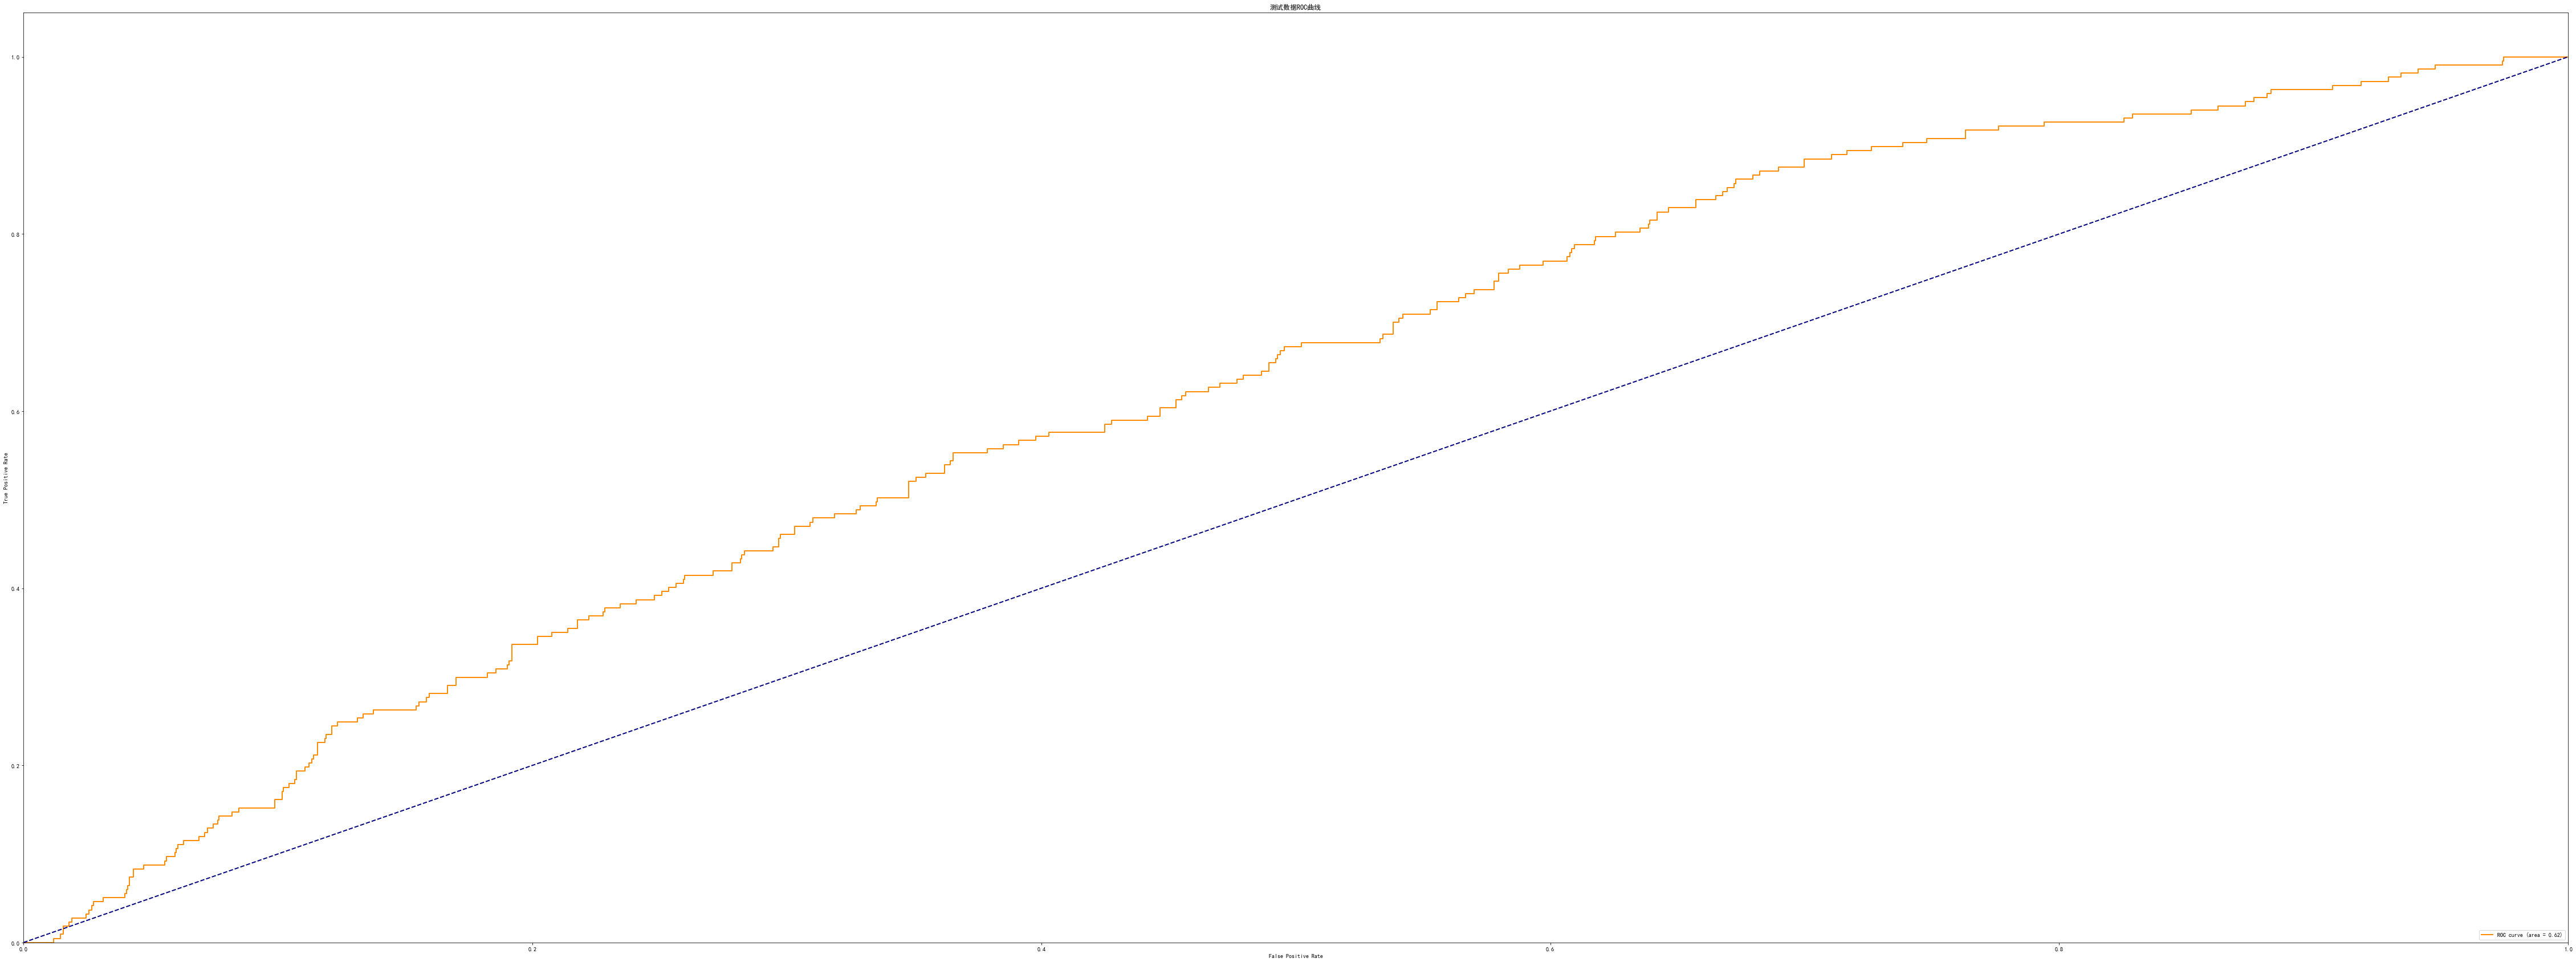

OUTLIERS :  218 INLIERS :  1781 Histogram-base Outlier Detection (HBOS)
使用算法Isolation Forest 进行建模：

在训练数据集中:
Isolation Forest ROC:0.711, precision @ rank n:0.2805

在测试数据集中:
Isolation Forest ROC:0.729, precision @ rank n:0.3226


<Figure size 432x288 with 0 Axes>

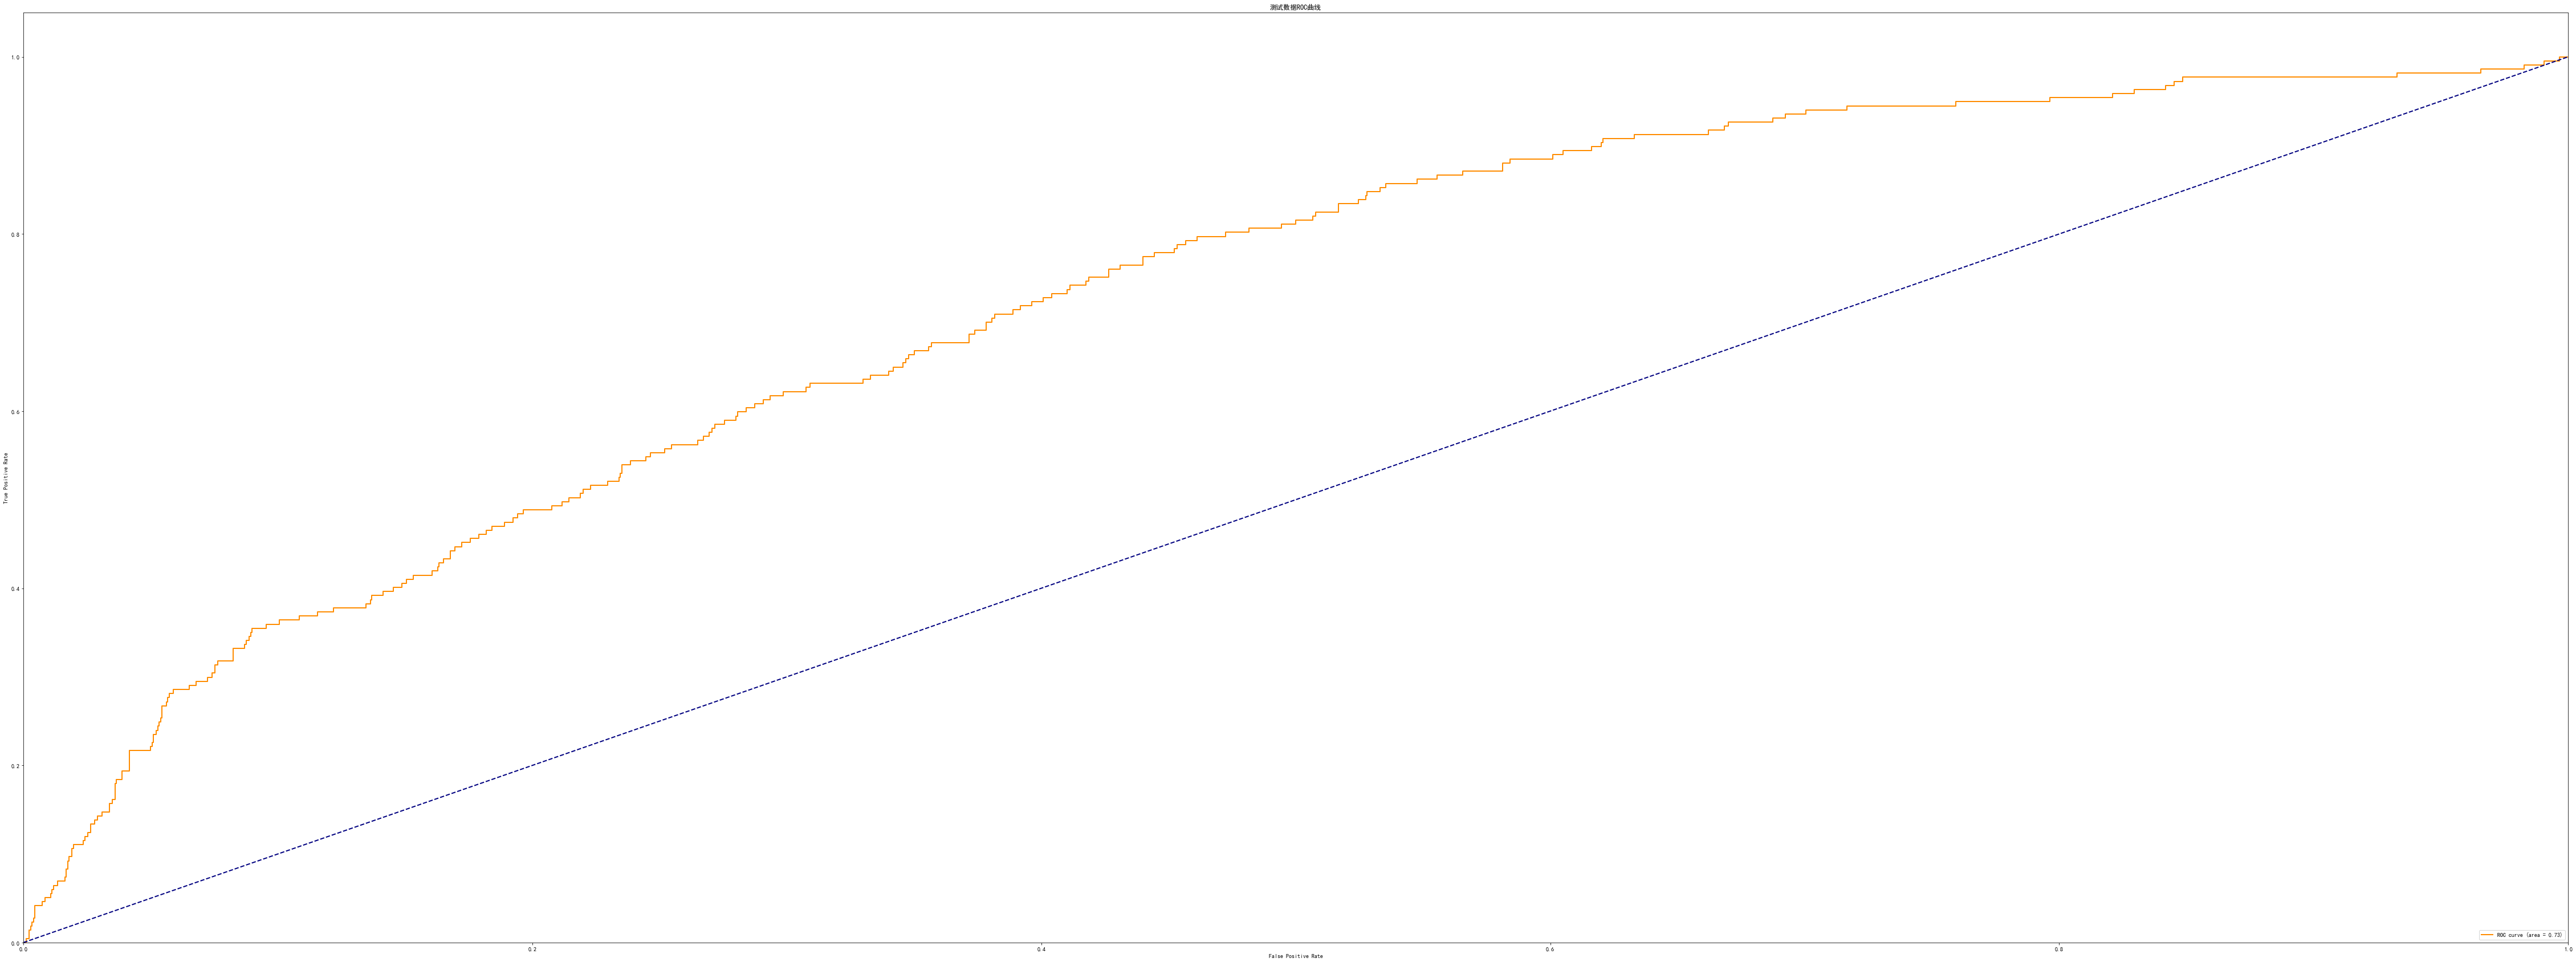

OUTLIERS :  225 INLIERS :  1774 Isolation Forest
使用算法K Nearest Neighbors (KNN) 进行建模：

在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6114, precision @ rank n:0.1646

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6209, precision @ rank n:0.1567


<Figure size 432x288 with 0 Axes>

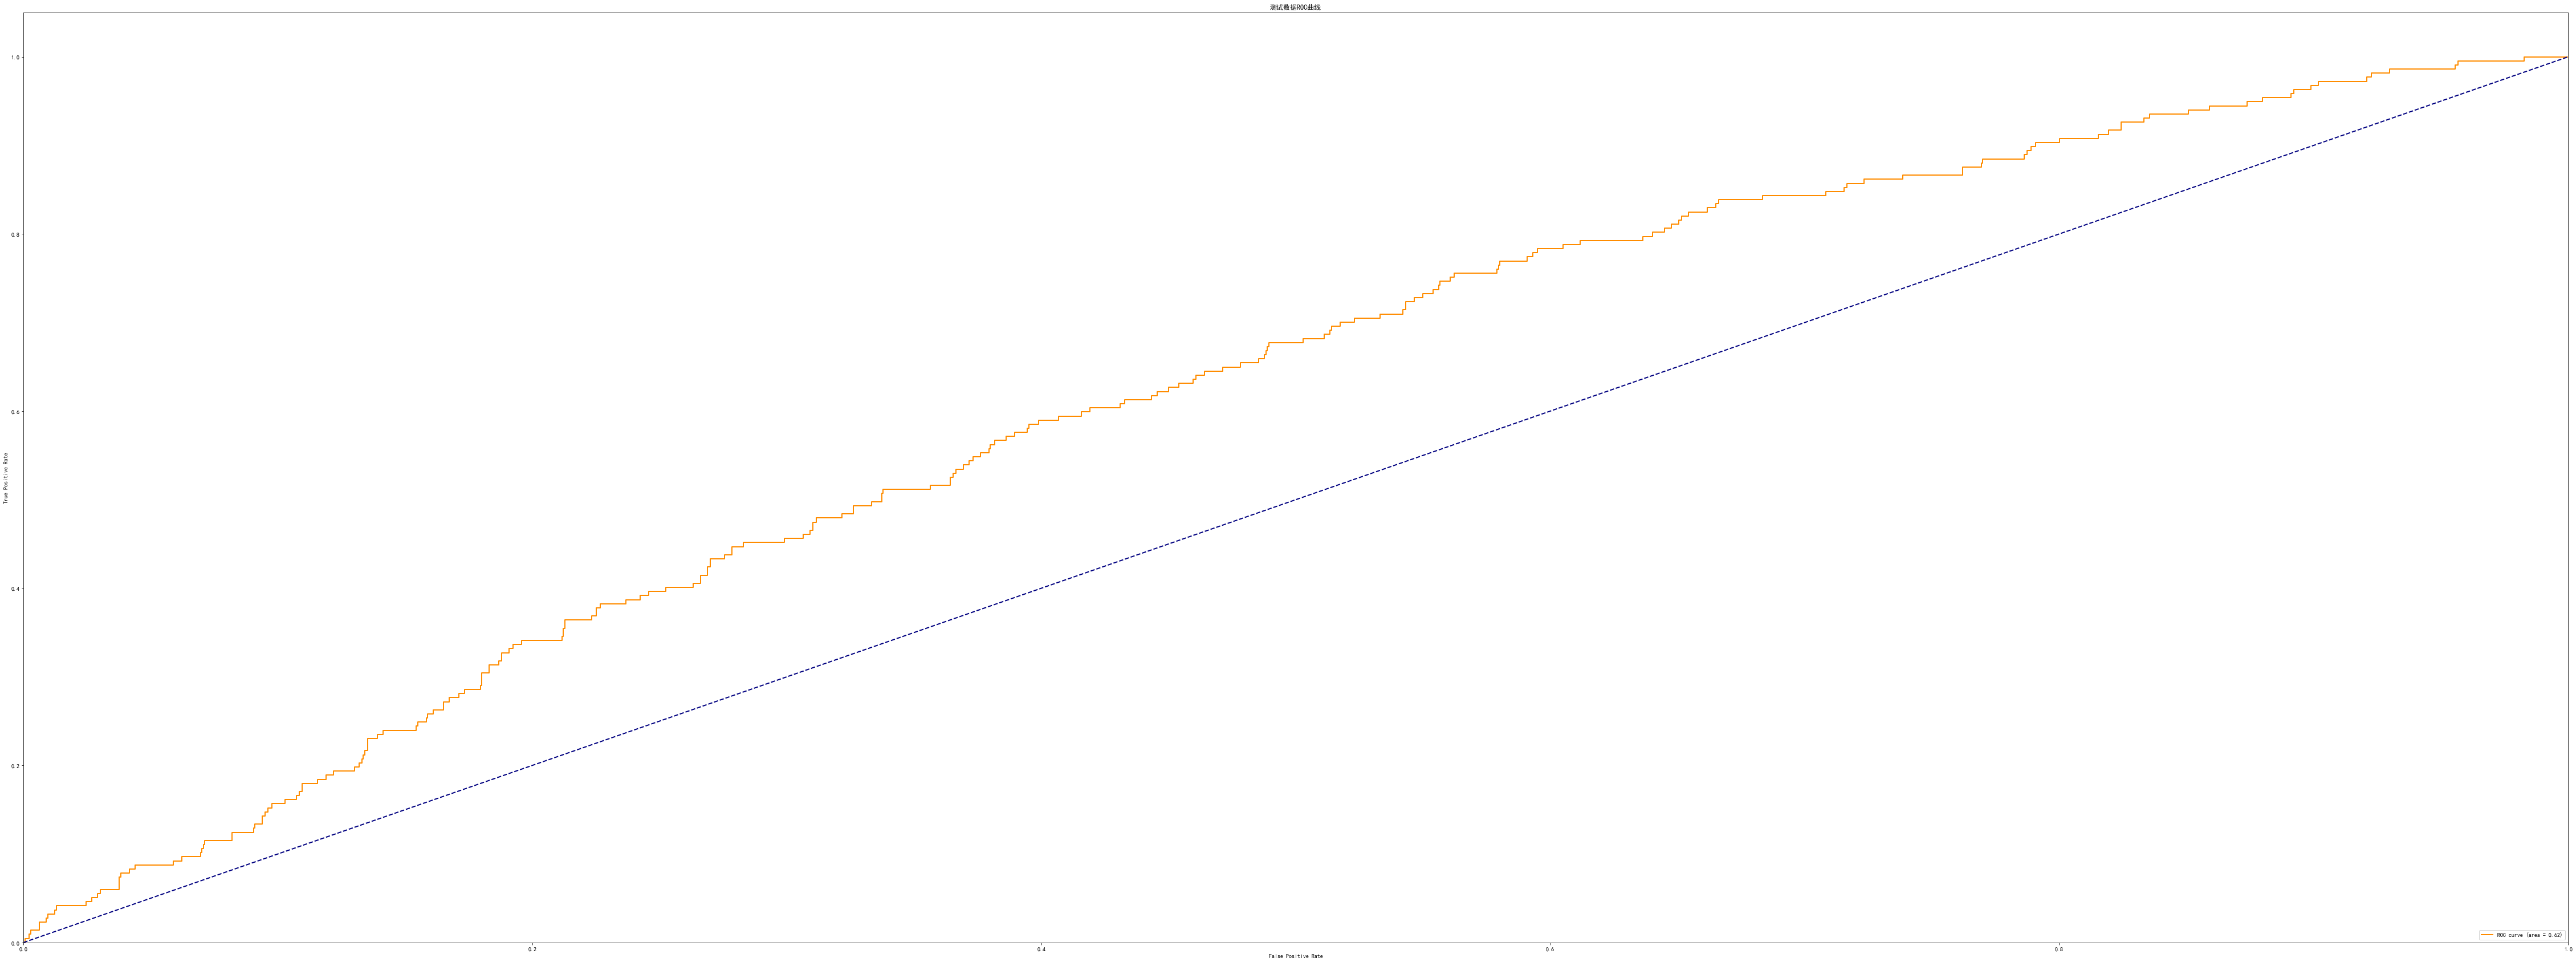

OUTLIERS :  197 INLIERS :  1802 K Nearest Neighbors (KNN)
使用算法Average KNN 进行建模：

在训练数据集中:
Average KNN ROC:0.602, precision @ rank n:0.1585

在测试数据集中:
Average KNN ROC:0.6177, precision @ rank n:0.1751


<Figure size 432x288 with 0 Axes>

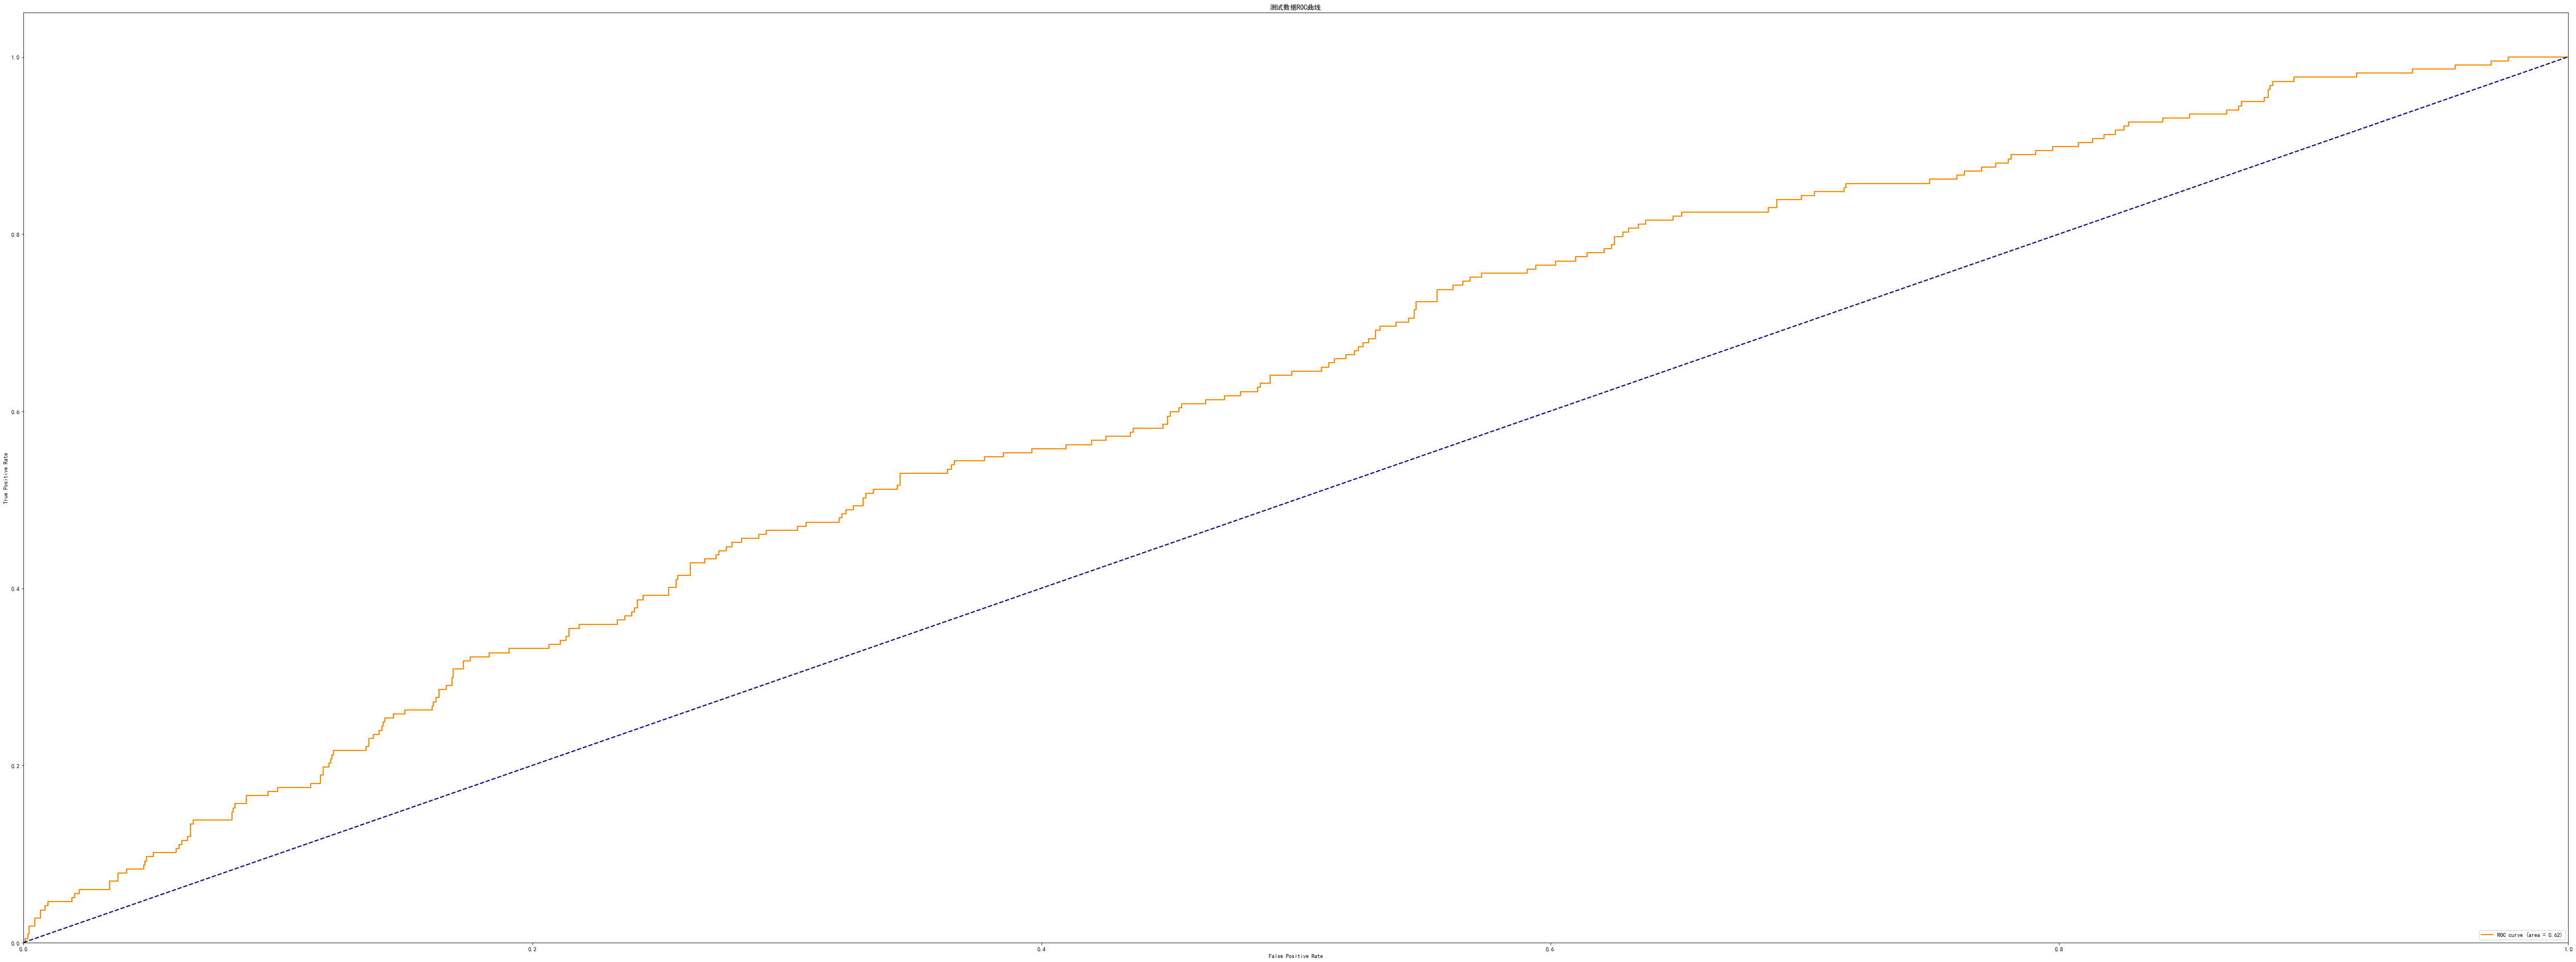

OUTLIERS :  220 INLIERS :  1779 Average KNN
使用算法Local Outlier Factor (LOF) 进行建模：

在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6056, precision @ rank n:0.1545

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6115, precision @ rank n:0.1521


<Figure size 432x288 with 0 Axes>

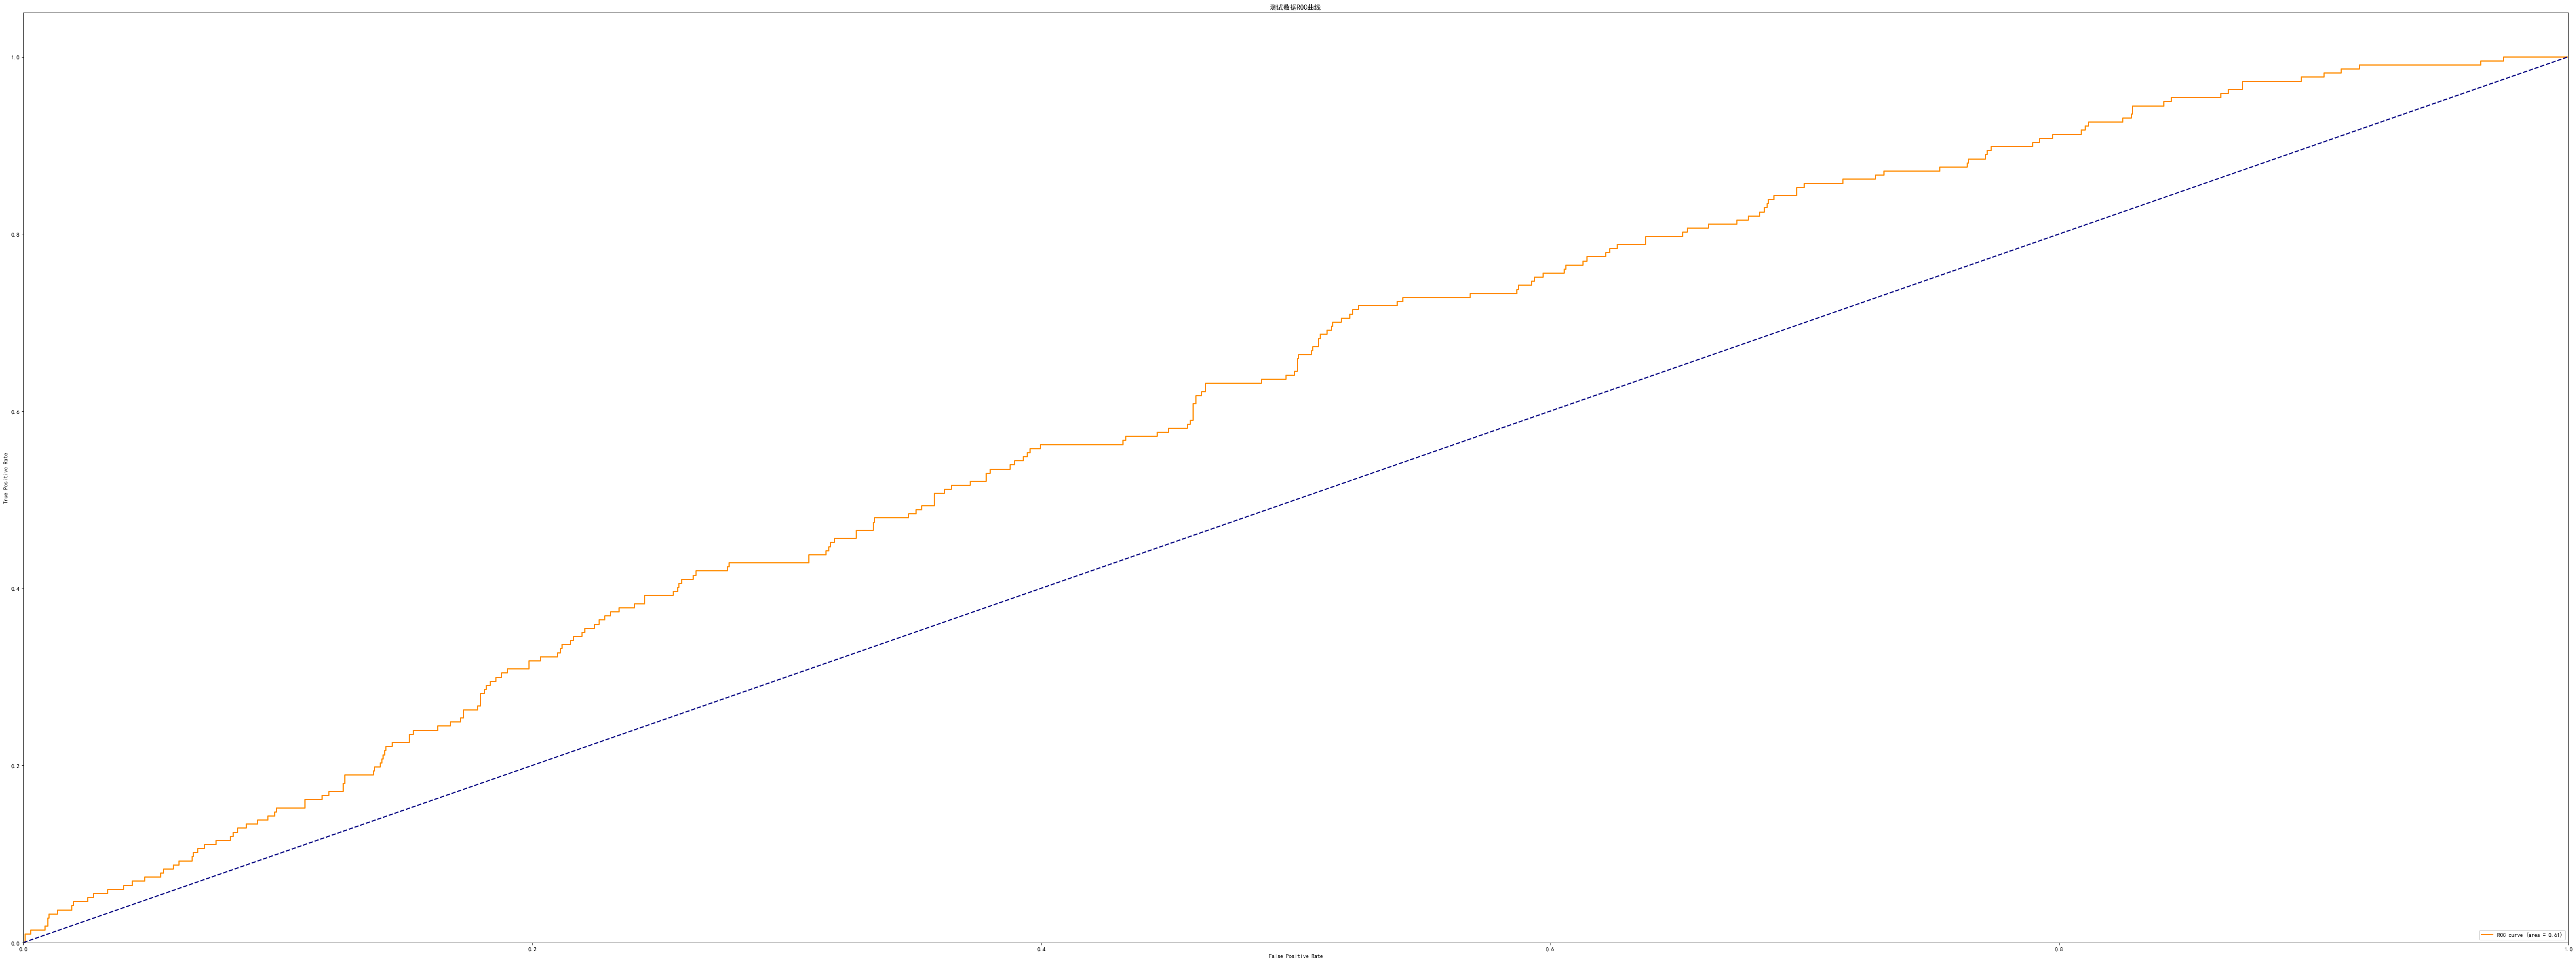

OUTLIERS :  203 INLIERS :  1796 Local Outlier Factor (LOF)
使用算法Connectivity-Based Outlier Factor (COF) 进行建模：

在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6056, precision @ rank n:0.1545

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6115, precision @ rank n:0.1521


<Figure size 432x288 with 0 Axes>

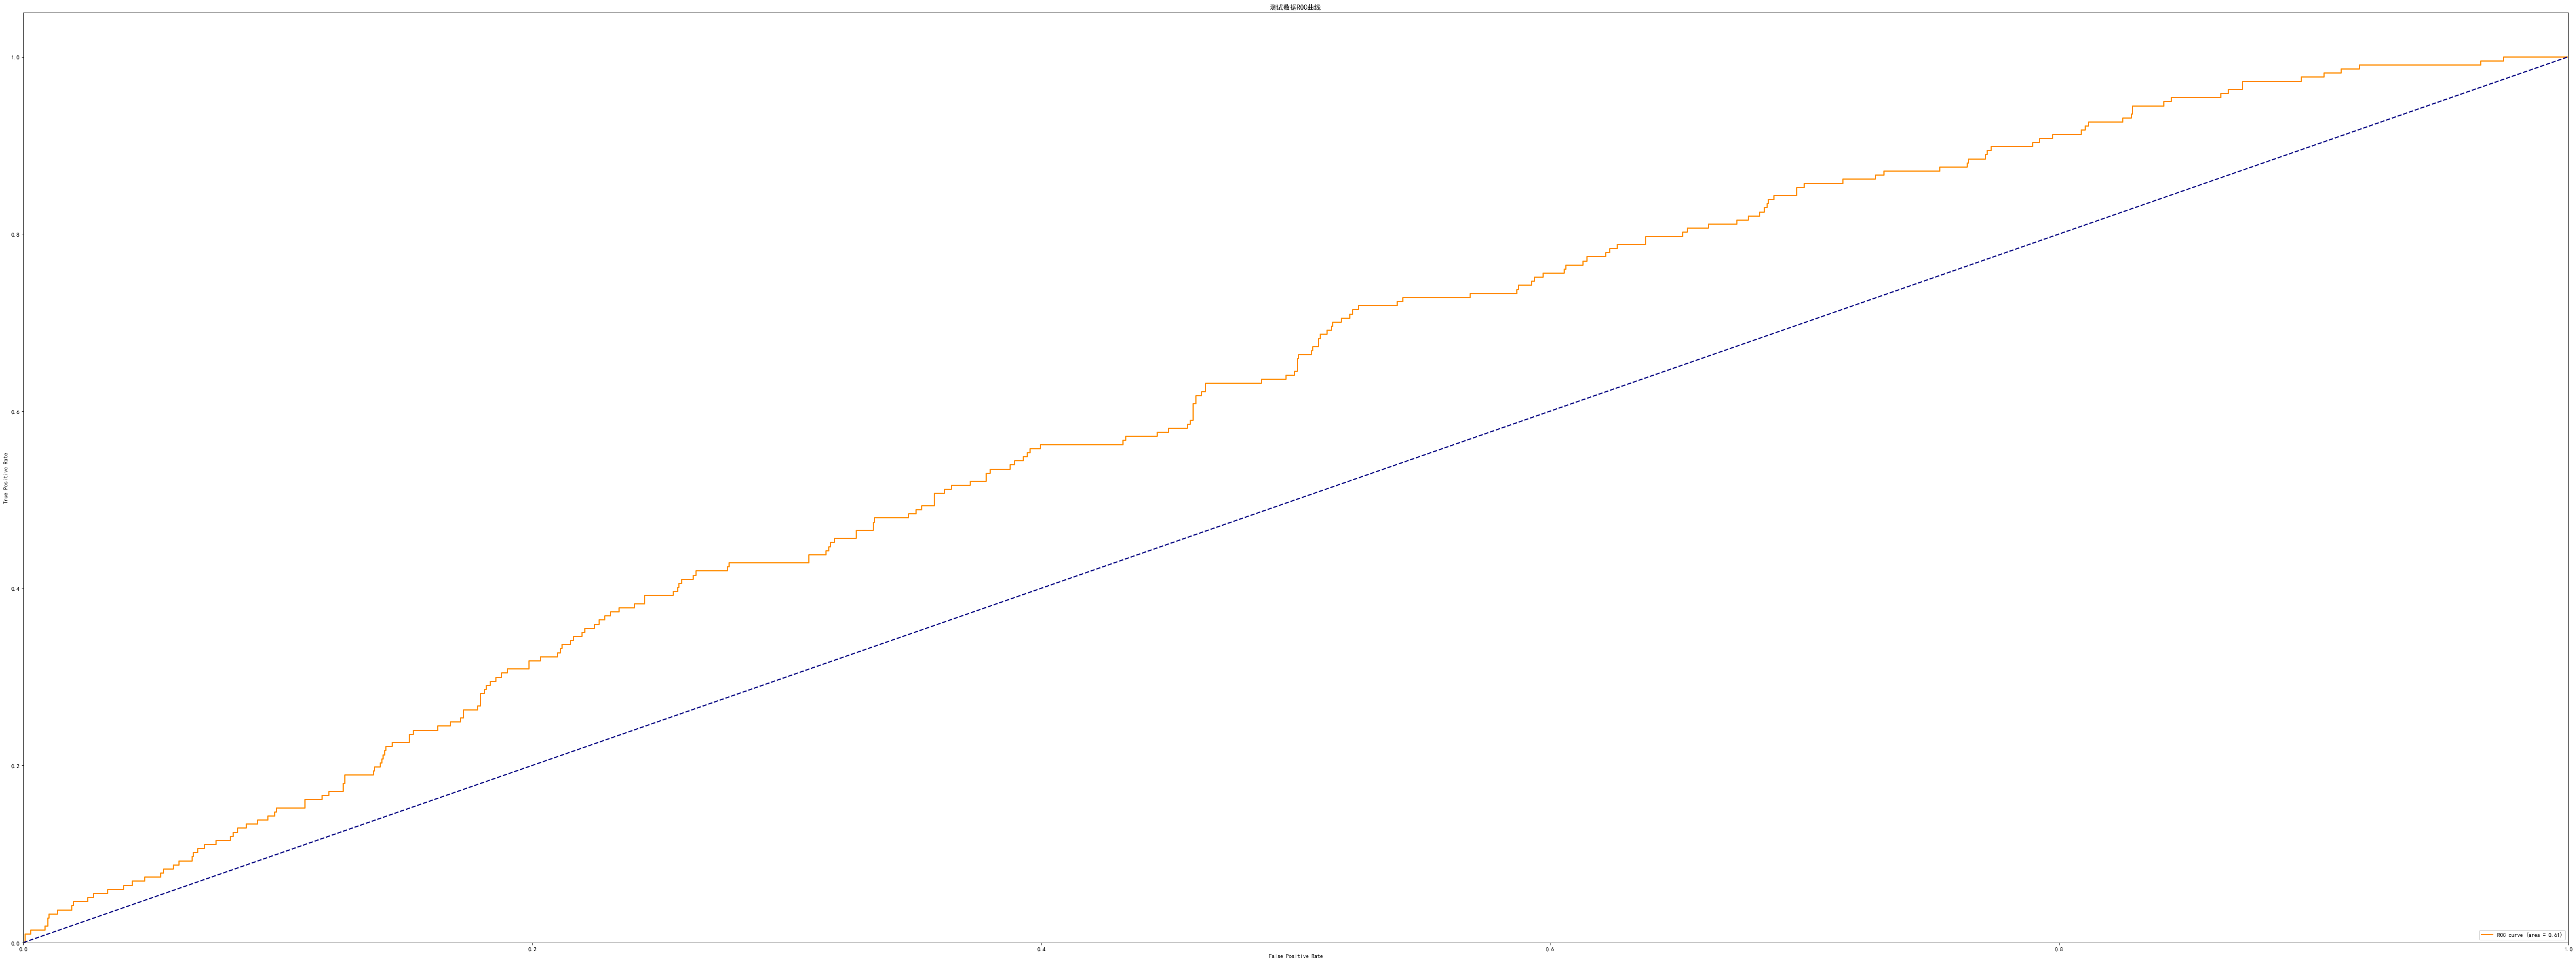

OUTLIERS :  203 INLIERS :  1796 Connectivity-Based Outlier Factor (COF)
使用算法Principal Component Analysis Outlier Detector (PCA) 进行建模：

在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6553, precision @ rank n:0.2459

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6734, precision @ rank n:0.2442


<Figure size 432x288 with 0 Axes>

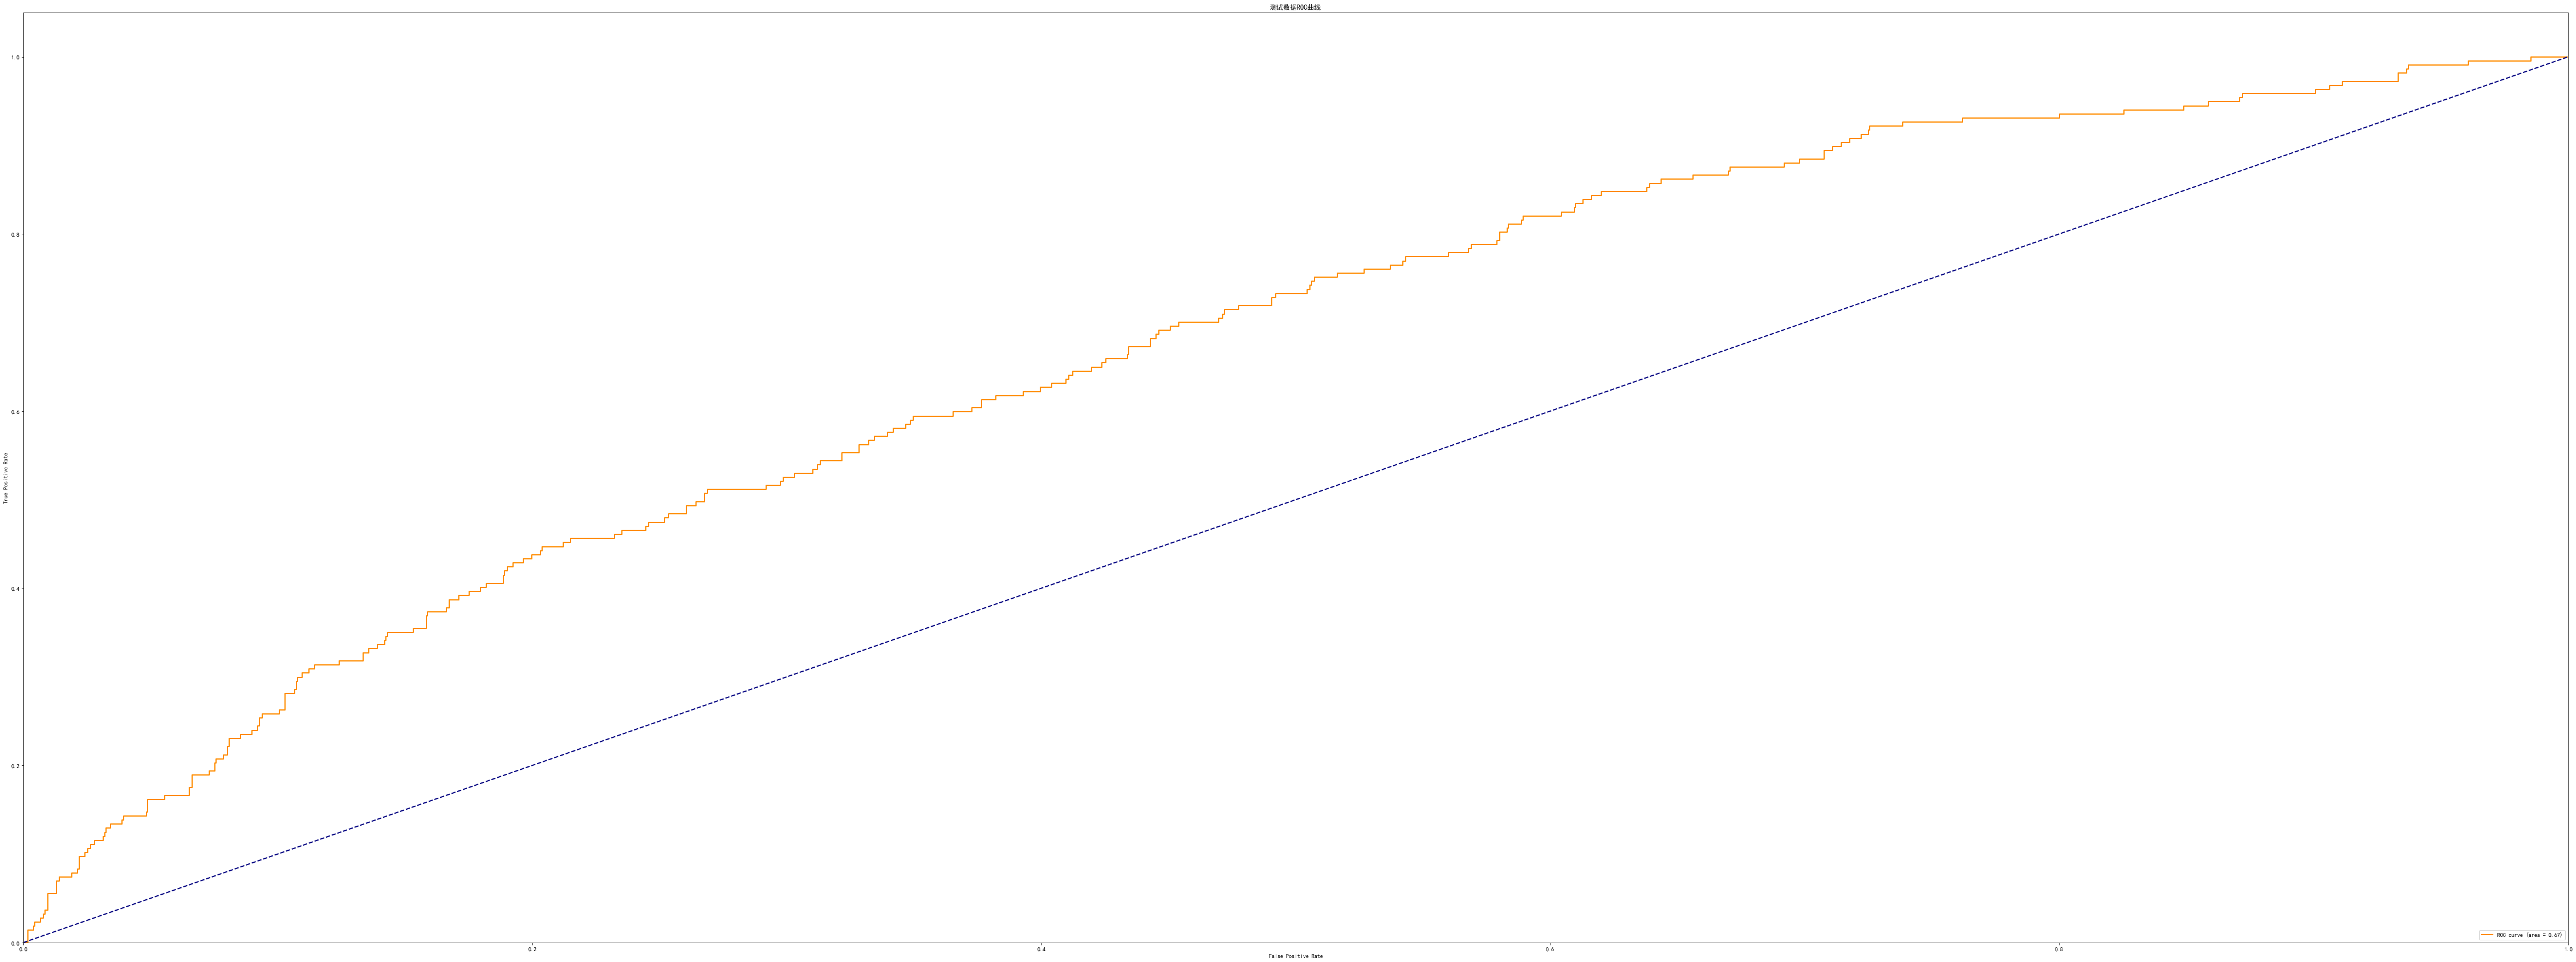

OUTLIERS :  220 INLIERS :  1779 Principal Component Analysis Outlier Detector (PCA)


In [27]:
#划分测试数据集和训练数据集
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.3,random_state=0)
for i, (clf_name, clf) in enumerate(classifiers.items()):
    print("使用算法"+clf_name+" 进行建模：")
    clf.fit(x_train)
    # 返回训练数据x_train上的异常标签和异常分值
    y_train_pred = clf.labels_  
    y_train_scores = clf.decision_scores_ 
    # 用训练好的clf来预测未知数据中的异常值
    # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
    y_test_pred = clf.predict(x_test) 
    #  返回未知数据上的异常值 (分值越大越异常)
    y_test_scores = clf.decision_function(x_test) 
    y_train_scores = y_train_scores.reshape(-1,1)
    y_test_scores = y_test_scores.reshape(-1,1)
    y_train_scores = y_train_scores.reshape(-1, 1)
    y_test_scores = y_test_scores.reshape(-1, 1)
    # if scores contain nan, change it to 0
    if np.isnan(y_train_scores).any():
         y_train_scores = np.nan_to_num(y_train_scores)
    if np.isnan(y_test_scores).any():
         y_test_scores = np.nan_to_num(y_test_scores)
#     train_scores_norm, test_scores_norm = standardizer(y_train_scores, y_test_scores)    
    print("\n在训练数据集中:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\n在测试数据集中:")
    evaluate_print(clf_name, y_test, y_test_scores)
    # 绘制ROC图
    fpr,tpr,threshold = roc_curve(y_test, y_test_scores) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
    plt.figure()
    lw = 2
    plt.figure(figsize=(80,30))
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('测试数据ROC曲线')
    plt.legend(loc="lower right")
    plt.show()
    
    # 计算离群点的个数
    n_inliers = len(y_test_pred) - np.count_nonzero(y_test_pred)
    n_outliers = np.count_nonzero(y_test_pred == 1)
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)

- 我使用了不同种类的11种方法进行建模，其中单样本检测方法有10种，包括:
    线性模型PCA；
    基于近邻的方法LOF、COF、KNN、Average KNN、CBLOF、HBOS；
    基于概率统计的方法ABOD（耗时较久）、FastABOD；
    基于离群值集合的方法Isolation Forest ；和1种离群组合框架方法 Feature Bagging。
- 该问题可以看做二分类问题，因此从ROC曲线和AUC面积中可以清楚地看到:
    结果中算法Feature Bagging在不包含niose的数据集中准确率最高，性能最好。而在包含noise的数据集中，所有算法都表现得不好，仅Fast Angle-based Outlier Detector (F_ABOD)处理的结果还行,所有算法都需要后期的参数调优。